In [ ]:
#|default_exp core

# Claudette's source

This is the 'literate' source code for Claudette. You can view the fully rendered version of the notebook [here](https://claudette.answer.ai/core.html), or you can clone the git repo and run the [interactive notebook](https://github.com/AnswerDotAI/claudette/blob/main/00_core.ipynb) in Jupyter. The notebook is converted the [Python module claudette/core.py](https://github.com/AnswerDotAI/claudette/blob/main/claudette/core.py) using [nbdev](https://nbdev.fast.ai/). The goal of this source code is to both create the Python module, and also to teach the reader *how* it is created, without assuming much existing knowledge about Claude's API.

Most of the time you'll see that we write some source code *first*, and then a description or discussion of it *afterwards*.

## Setup

In [ ]:
import os
# os.environ['ANTHROPIC_LOG'] = 'debug'

To print every HTTP request and response in full, uncomment the above line. This functionality is provided by Anthropic's SDK.

In [ ]:
#| export
import inspect, typing, json
from collections import abc
from dataclasses import dataclass
from typing import get_type_hints, Any
from functools import wraps

from anthropic import Anthropic, AnthropicBedrock, AnthropicVertex
from anthropic.types import (Usage, TextBlock, ServerToolUseBlock,
                             WebSearchToolResultBlock, Message, ToolUseBlock,
                             ThinkingBlock, ServerToolUsage)
from anthropic.resources import messages

import toolslm
from toolslm.funccall import *

from fastcore.meta import delegates
from fastcore.utils import *
from fastcore.xtras import save_iter
from msglm import mk_msg_anthropic as mk_msg, mk_msgs_anthropic as mk_msgs

In [ ]:
#| hide
from nbdev import show_doc

In [ ]:
from anthropic.types import Model
from claudette.text_editor import *
from typing import get_args
from datetime import datetime
from pprint import pprint
from IPython.display import Image

import warnings

In [ ]:
warnings.filterwarnings("ignore", message="Pydantic serializer warnings")

In [ ]:
#| export
_all_ = ['mk_msg', 'mk_msgs']

In [ ]:
#| export
empty = inspect.Parameter.empty

:::{.callout-tip}

If you're reading the rendered version of this notebook, you'll see an "Exported source" collapsible widget below. If you're reading the source notebook directly, you'll see `#| exports` at the top of the cell. These show that this piece of code will be exported into the python module that this notebook creates. No other code will be included -- any other code in this notebook is just for demonstration, documentation, and testing.

You can toggle expanding/collapsing the source code of all exported sections by using the `</> Code` menu in the top right of the rendered notebook page.

:::

In [ ]:
#| exports

model_types = {
    # Anthropic
    'claude-opus-4-20250514': 'opus',
    'claude-sonnet-4-20250514': 'sonnet',
    'claude-3-opus-20240229': 'opus-3',
    'claude-3-7-sonnet-20250219': 'sonnet-3-7',
    'claude-3-5-sonnet-20241022': 'sonnet-3-5',
    'claude-3-haiku-20240307': 'haiku-3',
    'claude-3-5-haiku-20241022': 'haiku-3-5',
    # AWS
    'anthropic.claude-3-opus-20240229-v1:0': 'opus',
    'anthropic.claude-3-5-sonnet-20241022-v2:0': 'sonnet',
    'anthropic.claude-3-sonnet-20240229-v1:0': 'sonnet',
    'anthropic.claude-3-haiku-20240307-v1:0': 'haiku',
    # Google
    'claude-3-opus@20240229': 'opus',
    'claude-3-5-sonnet-v2@20241022': 'sonnet',
    'claude-3-sonnet@20240229': 'sonnet',
    'claude-3-haiku@20240307': 'haiku',
}

all_models = list(model_types)

In [ ]:
#|hide

# Full list of models via the anthropic SDK for reference. Not all models are surfaced by Claudette.
Model

typing.Union[typing.Literal['claude-3-7-sonnet-latest', 'claude-3-7-sonnet-20250219', 'claude-3-5-haiku-latest', 'claude-3-5-haiku-20241022', 'claude-sonnet-4-20250514', 'claude-sonnet-4-0', 'claude-4-sonnet-20250514', 'claude-3-5-sonnet-latest', 'claude-3-5-sonnet-20241022', 'claude-3-5-sonnet-20240620', 'claude-opus-4-0', 'claude-opus-4-20250514', 'claude-4-opus-20250514', 'claude-3-opus-latest', 'claude-3-opus-20240229', 'claude-3-sonnet-20240229', 'claude-3-haiku-20240307', 'claude-2.1', 'claude-2.0'], str]

In [ ]:
#| export
models = all_models[:5]

In [ ]:
models

['claude-opus-4-20250514',
 'claude-sonnet-4-20250514',
 'claude-3-opus-20240229',
 'claude-3-7-sonnet-20250219',
 'claude-3-5-sonnet-20241022']

In [ ]:
#| export
models_aws = [
    'anthropic.claude-sonnet-4-20250514-v1:0',
    'claude-3-5-haiku-20241022',
    'claude-3-7-sonnet-20250219',
    'anthropic.claude-3-opus-20240229-v1:0',
    'anthropic.claude-3-5-sonnet-20241022-v2:0'
]

In [ ]:
#| export
models_goog = ['anthropic.claude-3-sonnet-20240229-v1:0',
 'anthropic.claude-3-haiku-20240307-v1:0',
 'claude-3-opus@20240229',
 'claude-3-5-sonnet-v2@20241022',
 'claude-3-sonnet@20240229',
 'claude-3-haiku@20240307']

In [ ]:
#| exports
text_only_models = ('claude-3-5-haiku-20241022',)

In [ ]:
#| exports
has_streaming_models = set(all_models)
has_system_prompt_models = set(all_models)
has_temperature_models = set(all_models)
has_extended_thinking_models = {'claude-opus-4-20250514', 'claude-sonnet-4-20250514', 'claude-3-7-sonnet-20250219'}

In [ ]:
has_extended_thinking_models

{'claude-3-7-sonnet-20250219',
 'claude-opus-4-20250514',
 'claude-sonnet-4-20250514'}

In [ ]:
#| exports

def can_stream(m): return m in has_streaming_models
def can_set_system_prompt(m): return m in has_system_prompt_models
def can_set_temperature(m): return m in has_temperature_models
def can_use_extended_thinking(m): return m in has_extended_thinking_models

We include these functions to provide a uniform library interface with cosette since openai models such as o1 do not have many of these capabilities.

In [ ]:
assert can_stream('claude-3-5-sonnet-20241022') and can_set_system_prompt('claude-3-5-sonnet-20241022') and can_set_temperature('claude-3-5-sonnet-20241022')

These are the current versions and [prices](https://www.anthropic.com/pricing#anthropic-api) of Anthropic's models at the time of writing.

In [ ]:
model = models[1]; model

'claude-sonnet-4-20250514'

For examples, we'll use the latest Sonnet, since it's awesome.

## Antropic SDK

In [ ]:
cli = Anthropic()

This is what Anthropic's SDK provides for interacting with Python. To use it, pass it a list of *messages*, with *content* and a *role*. The roles should alternate between *user* and *assistant*.

:::{.callout-tip}

After the code below you'll see an indented section with an orange vertical line on the left. This is used to show the *result* of running the code above. Because the code is running in a Jupyter Notebook, we don't have to use `print` to display results, we can just type the expression directly, as we do with `r` here.

:::

In [ ]:
m = {'role': 'user', 'content': "I'm Jeremy"}
r = cli.messages.create(messages=[m], model=model, max_tokens=100)
r

Hi Jeremy! Nice to meet you. How are you doing today? Is there anything I can help you with?

<details>

- id: `msg_01DSznQs5orh3RtCT1vDDRmG`
- content: `[{'citations': None, 'text': 'Hi Jeremy! Nice to meet you. How are you doing today? Is there anything I can help you with?', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 10, 'output_tokens': 26, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

### Formatting output

That output is pretty long and hard to read, so let's clean it up. We'll start by pulling out the `Content` part of the message.
To do that, we're going to write our first function which will be included to the `claudette/core.py` module.

:::{.callout-tip}

This is the first exported public function or class we're creating (the previous export was of a variable). In the rendered version of the notebook for these you'll see 4 things, in this order (unless the symbol starts with a single `_`, which indicates it's *private*):

- The signature (with the symbol name as a heading, with a horizontal rule above)
- A table of paramater docs (if provided)
- The doc string (in italics).
- The source code (in a collapsible "Exported source" block)

After that, we generally provide a bit more detail on what we've created, and why, along with a sample usage.

:::

In [ ]:
#| exports
def _type(x):
    try: return x.type
    except AttributeError: return x.get('type')

def find_block(r:abc.Mapping, # The message to look in
               blk_type:type|str=TextBlock  # The type of block to find
              ):
    "Find the first block of type `blk_type` in `r.content`."
    f = (lambda x:_type(x)==blk_type) if isinstance(blk_type,str) else (lambda x:isinstance(x,blk_type))
    return first(o for o in r.content if f(o))

This makes it easier to grab the needed parts of Claude's responses, which can include multiple pieces of content. By default, we look for the first text block. That will generally have the content we want to display.

In [ ]:
find_block(r)

TextBlock(citations=None, text='Hi Jeremy! Nice to meet you. How are you doing today? Is there anything I can help you with?', type='text')

In [ ]:
def contents(r):
    "Helper to get the contents from Claude response `r`."
    blk = find_block(r)
    if not blk and r.content: blk = r.content[0]
    return blk.text.strip() if hasattr(blk,'text') else str(blk)

For display purposes, we often just want to show the text itself.

In [ ]:
contents(r)

'Hi Jeremy! Nice to meet you. How are you doing today? Is there anything I can help you with?'

In [ ]:
#| exports
@patch
def _repr_markdown_(self:(Message)):
    det = '\n- '.join(f'{k}: `{v}`' for k,v in self.model_dump().items())
    cts = re.sub(r'\$', '&#36;', contents(self))  # escape `$` for jupyter latex
    return f"""{cts}

<details>

- {det}

</details>"""

Jupyter looks for a `_repr_markdown_` method in displayed objects; we add this in order to display just the content text, and collapse full details into a hideable section. Note that `patch` is from [fastcore](https://fastcore.fast.ai/), and is used to add (or replace) functionality in an existing class. We pass the class(es) that we want to patch as type annotations to `self`. In this case, `_repr_markdown_` is being added to Anthropic's `Message` class, so when we display the message now we just see the contents, and the details are hidden away in a collapsible details block.

In [ ]:
r

Hi Jeremy! Nice to meet you. How are you doing today? Is there anything I can help you with?

<details>

- id: `msg_01DSznQs5orh3RtCT1vDDRmG`
- content: `[{'citations': None, 'text': 'Hi Jeremy! Nice to meet you. How are you doing today? Is there anything I can help you with?', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 10, 'output_tokens': 26, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

One key part of the response is the `usage` key, which tells us how many tokens we used by returning a `Usage` object.

We'll add some helpers to make things a bit cleaner for creating and formatting these objects.

In [ ]:
r.usage

In: 10; Out: 26; Cache create: 0; Cache read: 0; Total Tokens: 36; Search: 0

In [ ]:
#| exports
def server_tool_usage(web_search_requests=0):
    'Little helper to create a server tool usage object'
    return ServerToolUsage(web_search_requests=web_search_requests)

In [ ]:
#| exports
def usage(inp=0, # input tokens
          out=0,  # Output tokens
          cache_create=0, # Cache creation tokens
          cache_read=0, # Cache read tokens
          server_tool_use=server_tool_usage() # server tool use
         ):
    'Slightly more concise version of `Usage`.'
    return Usage(input_tokens=inp, output_tokens=out, cache_creation_input_tokens=cache_create,
                 cache_read_input_tokens=cache_read, server_tool_use=server_tool_use)

The constructor provided by Anthropic is rather verbose, so we clean it up a bit, using a lowercase version of the name.

In [ ]:
usage(5)

In: 5; Out: 0; Cache create: 0; Cache read: 0; Total Tokens: 5; Search: 0

In [ ]:
#| exports
def _dgetattr(o,s,d): 
    "Like getattr, but returns the default if the result is None"
    return getattr(o,s,d) or d

@patch(as_prop=True)
def total(self:Usage): return self.input_tokens+self.output_tokens+_dgetattr(self, "cache_creation_input_tokens",0)+_dgetattr(self, "cache_read_input_tokens",0)

Adding a `total` property to `Usage` makes it easier to see how many tokens we've used up altogether.

In [ ]:
usage(5,1).total

6

In [ ]:
#| exports
@patch
def __repr__(self:Usage):
    io_toks = f'In: {self.input_tokens}; Out: {self.output_tokens}'
    cache_toks = f'Cache create: {_dgetattr(self, "cache_creation_input_tokens",0)}; Cache read: {_dgetattr(self, "cache_read_input_tokens",0)}'
    server_tool_use = _dgetattr(self, "server_tool_use",server_tool_usage())
    server_tool_use_str = f'Search: {server_tool_use.web_search_requests}'
    total_tok = f'Total Tokens: {self.total}'
    return f'{io_toks}; {cache_toks}; {total_tok}; {server_tool_use_str}'

In python, patching `__repr__` lets us change how an object is displayed. (More generally, methods starting and ending in `__` in Python are called `dunder` methods, and have some `magic` behavior -- such as, in this case, changing how an object is displayed.) We won't be directly displaying ServerToolUsage's, so we can handle its display behavior in the same Usage `__repr__`

In [ ]:
usage(5)

In: 5; Out: 0; Cache create: 0; Cache read: 0; Total Tokens: 5; Search: 0

In [ ]:
#| exports
@patch
def __add__(self:ServerToolUsage, b):
    "Add together each of the server tool use counts"
    return ServerToolUsage(web_search_requests=self.web_search_requests+b.web_search_requests)

And, patching `__add__` lets `+` work on a `ServerToolUsage` as well as a `Usage` object.

In [ ]:
server_tool_usage(1) + server_tool_usage(2)

ServerToolUsage(web_search_requests=3)

In [ ]:
#| exports
@patch
def __add__(self:Usage, b):
    "Add together each of `input_tokens` and `output_tokens`"
    return usage(self.input_tokens+b.input_tokens, self.output_tokens+b.output_tokens,
                 _dgetattr(self,'cache_creation_input_tokens',0)+_dgetattr(b,'cache_creation_input_tokens',0),
                 _dgetattr(self,'cache_read_input_tokens',0)+_dgetattr(b,'cache_read_input_tokens',0),
                 _dgetattr(self,'server_tool_use',server_tool_usage())+_dgetattr(b,'server_tool_use',server_tool_usage()))

In [ ]:
r.usage+r.usage + usage(server_tool_use=server_tool_usage(1))

In: 20; Out: 52; Cache create: 0; Cache read: 0; Total Tokens: 72; Search: 1

### Creating messages

Creating correctly formatted `dict`s from scratch every time isn't very handy, so we'll import a couple of helper functions from the `msglm` library.

Let's use `mk_msg` to recreate our msg `{'role': 'user', 'content': "I'm Jeremy"}` from earlier.

In [ ]:
prompt = "I'm Jeremy"
m = mk_msg(prompt)
r = cli.messages.create(messages=[m], model=model, max_tokens=100)
r

Nice to meet you, Jeremy! How are you doing today? Is there anything I can help you with?

<details>

- id: `msg_016fckEqgXGS6WYcjjgBzqAG`
- content: `[{'citations': None, 'text': 'Nice to meet you, Jeremy! How are you doing today? Is there anything I can help you with?', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 10, 'output_tokens': 25, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

We can pass more than just text messages to Claude. As we'll see later we can also pass images, SDK objects, etc. To handle these different data types we need to pass the type along with our content to Claude. 

Here's an example of a multimodal message containing text and images. 

```json
{
    'role': 'user', 
    'content': [
        {'type':'text', 'text':'What is in the image?'},
        {
            'type':'image', 
            'source': {
                'type':'base64', 'media_type':'media_type', 'data': 'data'
            }
        }
    ]
}
```

`mk_msg` infers the type automatically and creates the appropriate data structure. 

LLMs, don't actually have state, but instead dialogs are created by passing back all previous prompts and responses every time. With Claude, they always alternate *user* and *assistant*. We'll use `mk_msgs` from `msglm` to make it easier to build up these dialog lists.

In [ ]:
msgs = mk_msgs([prompt, r, "I forgot my name. Can you remind me please?"]) 
msgs

[{'role': 'user', 'content': "I'm Jeremy"},
 {'role': 'assistant',
  'content': [TextBlock(citations=None, text='Nice to meet you, Jeremy! How are you doing today? Is there anything I can help you with?', type='text')]},
 {'role': 'user', 'content': 'I forgot my name. Can you remind me please?'}]

In [ ]:
cli.messages.create(messages=msgs, model=model, max_tokens=200)

Your name is Jeremy - you introduced yourself to me just a moment ago at the start of our conversation.

<details>

- id: `msg_011oM9YVA1Y8XenSfMMqGFke`
- content: `[{'citations': None, 'text': 'Your name is Jeremy - you introduced yourself to me just a moment ago at the start of our conversation.', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 49, 'output_tokens': 24, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

## Client

In [ ]:
#| exports
class Client:
    def __init__(self, model, cli=None, log=False, cache=False):
        "Basic Anthropic messages client."
        self.model,self.use = model,usage()
        self.text_only = model in text_only_models
        self.log = [] if log else None
        self.c = (cli or Anthropic(default_headers={'anthropic-beta': 'prompt-caching-2024-07-31'}))
        self.cache = cache

We'll create a simple `Client` for `Anthropic` which tracks usage stores the model to use. We don't add any methods right away -- instead we'll use `patch` for that so we can add and document them incrementally.

In [ ]:
c = Client(model)
c.use

In: 0; Out: 0; Cache create: 0; Cache read: 0; Total Tokens: 0; Search: 0

In [ ]:
#| exports
@patch
def _r(self:Client, r:Message, prefill=''):
    "Store the result of the message and accrue total usage."
    if prefill:
        blk = find_block(r)
        if blk: blk.text = prefill + (blk.text or '')
    self.result = r
    self.use += r.usage
    self.stop_reason = r.stop_reason
    self.stop_sequence = r.stop_sequence
    return r

We use a `_` prefix on private methods, but we document them here in the interests of literate source code.

`_r` will be used each time we get a new result, to track usage and also to keep the result available for later.

In [ ]:
c._r(r)
c.use

In: 10; Out: 25; Cache create: 0; Cache read: 0; Total Tokens: 35; Search: 0

Whereas OpenAI's models use a `stream` parameter for streaming, Anthropic's use a separate method. We implement Anthropic's approach in a private method, and then use a `stream` parameter in `__call__` for consistency:

In [ ]:
#| exports
@patch
def _log(self:Client, final, prefill, msgs, **kwargs):
    self._r(final, prefill)
    if self.log is not None: self.log.append({
        "msgs": msgs, **kwargs,
        "result": self.result, "use": self.use, "stop_reason": self.stop_reason, "stop_sequence": self.stop_sequence
    })
    return self.result

Once streaming is complete, we need to store the final message and call any completion callback that's needed.

In [ ]:
#| exports
@save_iter
def _stream(o, cm, prefill, cb):
    with cm as s:
        yield prefill
        yield from s.text_stream
        o.value = s.get_final_message()
        cb(o.value)

In [ ]:
#| export
def get_types(msgs):
    types = []
    for m in msgs:
        content = m.get('content', [])
        if isinstance(content, list): types.extend(getattr(c, 'type', None) or c['type'] for c in content)
        else: types.append('text')
    return types

In [ ]:
get_types(msgs)

['text', 'text', 'text']

In [ ]:
#| export
def mk_tool_choice(choose:Union[str,bool,None])->dict:
    "Create a `tool_choice` dict that's 'auto' if `choose` is `None`, 'any' if it is True, or 'tool' otherwise"
    return {"type": "tool", "name": choose} if isinstance(choose,str) else {'type':'any'} if choose else {'type':'auto'}

In [ ]:
print(mk_tool_choice('sums'))
print(mk_tool_choice(True))
print(mk_tool_choice(None))

{'type': 'tool', 'name': 'sums'}
{'type': 'any'}
{'type': 'auto'}


Claude can be forced to use a particular tool, or select from a specific list of tools, or decide for itself when to use a tool. If you want to force a tool (or force choosing from a list), include a `tool_choice` param with a dict from `mk_tool_choice`.

Claude supports adding an extra `assistant` message at the end, which contains the *prefill* -- i.e. the text we want Claude to assume the response starts with. However Claude doesn't actually repeat that in the response, so for convenience we add it.

In [ ]:
#| exports
@patch
def _precall(self:Client, msgs, prefill, sp, temp, maxtok, maxthinktok, stream,
             stop, tools, tool_choice, kwargs):
    if tools: kwargs['tools'] = [get_schema(o) if callable(o) else o for o in listify(tools)]
    if tool_choice: kwargs['tool_choice'] = mk_tool_choice(tool_choice)
    if maxthinktok: 
        kwargs['thinking'] = {'type':'enabled', 'budget_tokens':maxthinktok} 
        temp,prefill = 1,''
    pref = [prefill.strip()] if prefill else []
    if not isinstance(msgs,list): msgs = [msgs]
    if stop is not None:
        if not isinstance(stop, (list)): stop = [stop]
        kwargs["stop_sequences"] = stop
    msgs = mk_msgs(msgs+pref, cache=self.cache, cache_last_ckpt_only=self.cache)
    assert not ('image' in get_types(msgs) and self.text_only), f"Images not supported by: {self.model}"
    kwargs |= dict(max_tokens=maxtok, system=sp, temperature=temp)
    return msgs, kwargs

In [ ]:
#| exports
@patch
@delegates(messages.Messages.create)
def __call__(self:Client,
             msgs:list, # List of messages in the dialog
             sp='', # The system prompt
             temp=0, # Temperature
             maxtok=4096, # Maximum tokens
             maxthinktok=0, # Maximum thinking tokens
             prefill='', # Optional prefill to pass to Claude as start of its response
             stream:bool=False, # Stream response?
             stop=None, # Stop sequence
             tools:Optional[list]=None, # List of tools to make available to Claude
             tool_choice:Optional[dict]=None, # Optionally force use of some tool
             cb=None, # Callback to pass result to when complete
             **kwargs):
    "Make a call to Claude."
    msgs,kwargs = self._precall(msgs, prefill, sp, temp, maxtok, maxthinktok, stream,
                                stop, tools, tool_choice, kwargs)
    m = self.c.messages
    f = m.stream if stream else m.create
    res = f(model=self.model, messages=msgs, **kwargs)
    def _cb(v):
        self._log(v, prefill=prefill, msgs=msgs, **kwargs)
        if cb: cb(v)
    if stream: return _stream(res, prefill, _cb)
    try: return res
    finally: _cb(res)

Defining `__call__` let's us use an object like a function (i.e it's *callable*). We use it as a small wrapper over `messages.create`.

In [ ]:
c = Client(model, log=True)
c.use

In: 0; Out: 0; Cache create: 0; Cache read: 0; Total Tokens: 0; Search: 0

In [ ]:
c('Hi')

Hello! How are you doing today? Is there anything I can help you with?

<details>

- id: `msg_01W5P9N8XLn9tqpQxXhwnqA7`
- content: `[{'citations': None, 'text': 'Hello! How are you doing today? Is there anything I can help you with?', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 8, 'output_tokens': 20, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

Usage details are automatically updated after each call:

In [ ]:
c.use

In: 8; Out: 20; Cache create: 0; Cache read: 0; Total Tokens: 28; Search: 0

A log of all messages is kept if `log=True` is passed:

In [ ]:
pprint(c.log)

[{'max_tokens': 4096,
  'msgs': [{'content': 'Hi', 'role': 'user'}],
  'result': Message(id='msg_01W5P9N8XLn9tqpQxXhwnqA7', content=[TextBlock(citations=None, text='Hello! How are you doing today? Is there anything I can help you with?', type='text')], model='claude-sonnet-4-20250514', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=In: 8; Out: 20; Cache create: 0; Cache read: 0; Total Tokens: 28; Search: 0),
  'stop_reason': 'end_turn',
  'stop_sequence': None,
  'system': '',
  'temperature': 0,
  'use': In: 8; Out: 20; Cache create: 0; Cache read: 0; Total Tokens: 28; Search: 0}]


Let's try out *prefill*:

In [ ]:
q = "Very concisely, what is the meaning of life?"
pref = 'According to Douglas Adams, '

In [ ]:
c(q, prefill=pref)

According to Douglas Adams, 42. But seriously, there's no universal answer - it's deeply personal. Many find meaning through relationships, purpose, growth, helping others, or spiritual beliefs. The search itself might be part of the point.

<details>

- id: `msg_01XJfhemPfg6dxVLA2cV7vSp`
- content: `[{'citations': None, 'text': "According to Douglas Adams, 42. But seriously, there's no universal answer - it's deeply personal. Many find meaning through relationships, purpose, growth, helping others, or spiritual beliefs. The search itself might be part of the point.", 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 24, 'output_tokens': 46, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
c.use

In: 32; Out: 66; Cache create: 0; Cache read: 0; Total Tokens: 98; Search: 0

We can pass `stream=True` to stream the response back incrementally:

In [ ]:
r = c('Hi', stream=True)
for o in r: print(o, end='')

Hello! How are you doing today? Is there anything I can help you with?

In [ ]:
c.use

In: 40; Out: 86; Cache create: 0; Cache read: 0; Total Tokens: 126; Search: 0

The full final message after completion of streaming is in the `value` attr of the response:

In [ ]:
r.value

Hello! How are you doing today? Is there anything I can help you with?

<details>

- id: `msg_01T5UhYDnggFUKTmfvpDbSdE`
- content: `[{'citations': None, 'text': 'Hello! How are you doing today? Is there anything I can help you with?', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 8, 'output_tokens': 20, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
for o in c(q, prefill=pref, stream=True): print(o, end='')

According to Douglas Adams, 42. But seriously, there's no universal answer - it's deeply personal. Many find meaning through relationships, purpose, growth, helping others, or spiritual beliefs. The search itself might be part of the point.

In [ ]:
c.use

In: 64; Out: 132; Cache create: 0; Cache read: 0; Total Tokens: 196; Search: 0

Pass a stop sequence if you want claude to stop generating text when it encounters it.

In [ ]:
c("Count from 1 to 10", stop="5")

1, 2, 3, 4,

<details>

- id: `msg_01YCmLr7wHADLccfBQRVLCmq`
- content: `[{'citations': None, 'text': '1, 2, 3, 4, ', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `stop_sequence`
- stop_sequence: `5`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 15, 'output_tokens': 14, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

This also works with streaming, and you can pass more than one stop sequence:

In [ ]:
for o in c("Count from 1 to 10", stop=["3", "yellow"], stream=True): print(o, end='')
print()
print(c.stop_reason, c.stop_sequence)

1, 2, 
stop_sequence 3


We've shown the token usage but we really care about is pricing. Let's extract the latest [pricing](https://www.anthropic.com/pricing#anthropic-api) from Anthropic into a `pricing` dict.

In [ ]:
#| export
pricing = {  # model type: $ / million tokens (input, output, cache write, cache read)
    'opus': (15, 75, 18.75, 1.5),
    'sonnet': (3, 15, 3.75, 0.3),
    'haiku-3': (0.25, 1.25, 0.3, 0.03),
    'haiku-3-5': (1, 3, 1.25, 0.1),
}

In [ ]:
#| exports
def get_pricing(m, u):
    return pricing[m][:3] if u.prompt_token_count < 128_000 else pricing[m][3:]

Similarly, let's get the pricing for the latest [server tools]():

In [ ]:
#| export
server_tool_pricing = {
    'web_search_requests': 10, # $10 per 1,000
}

We'll patch `Usage` to enable it compute the cost given pricing.

In [ ]:
#| exports
@patch
def cost(self:Usage, costs:tuple) -> float:
    cache_w, cache_r = _dgetattr(self, "cache_creation_input_tokens",0), _dgetattr(self, "cache_read_input_tokens",0)
    tok_cost = sum([self.input_tokens * costs[0] +  self.output_tokens * costs[1] +  cache_w * costs[2] + cache_r * costs[3]]) / 1e6
    server_tool_use = _dgetattr(self, "server_tool_use",server_tool_usage())
    server_tool_cost = server_tool_use.web_search_requests * server_tool_pricing['web_search_requests'] / 1e3
    return tok_cost + server_tool_cost

In [ ]:
#| exports
@patch(as_prop=True)
def cost(self: Client) -> float: return self.use.cost(pricing[model_types[self.model]])

In [ ]:
#| exports
def get_costs(c):
    costs = pricing[model_types[c.model]]
    
    inp_cost = c.use.input_tokens * costs[0] / 1e6
    out_cost = c.use.output_tokens * costs[1] / 1e6

    cache_w = c.use.cache_creation_input_tokens   
    cache_r = c.use.cache_read_input_tokens
    cache_cost = (cache_w * costs[2] + cache_r * costs[3]) / 1e6

    server_tool_use = c.use.server_tool_use
    server_tool_cost = server_tool_use.web_search_requests * server_tool_pricing['web_search_requests'] / 1e3
    return inp_cost, out_cost, cache_cost, cache_w + cache_r, server_tool_cost

The markdown repr of the client itself will show the latest result, along with the usage so far.

In [ ]:
#| exports
@patch
def _repr_markdown_(self:Client):
    if not hasattr(self,'result'): return 'No results yet'
    msg = contents(self.result)
    inp_cost, out_cost, cache_cost, cached_toks, server_tool_cost = get_costs(self)
    return f"""{msg}

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | {self.use.input_tokens:,} | {inp_cost:.6f} |
| Output tokens | {self.use.output_tokens:,} | {out_cost:.6f} |
| Cache tokens | {cached_toks:,} | {cache_cost:.6f} |
| Server tool use | {self.use.server_tool_use.web_search_requests:,} | {server_tool_cost:.6f} |
| **Total** | **{self.use.total:,}** | **${self.cost:.6f}** |"""

In [ ]:
c

1, 2,

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | 94 | 0.000282 |
| Output tokens | 154 | 0.002310 |
| Cache tokens | 0 | 0.000000 |
| Server tool use | 0 | 0.000000 |
| **Total** | **248** | **$0.002592** |

Pass a list of alternating user/assistant messages to give Claude a "dialog".

In [ ]:
c(["My name is Jeremy", "Hi Jeremy!", "Can you remind me what my name is?"])

Your name is Jeremy.

<details>

- id: `msg_01Qm7MmD2TQwb9CVQiNdSRME`
- content: `[{'citations': None, 'text': 'Your name is Jeremy.', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 29, 'output_tokens': 8, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

## Tool use

Let's now look more at tool use (aka *function calling*).

For testing, we need a function that Claude can call; we'll write a simple function that adds numbers together, and will tell us when it's being called:

In [ ]:
@dataclass
class MySum: val:int

def sums(
    a:int,  # First thing to sum
    b:int=1 # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return MySum(a + b)

In [ ]:
a,b = 604542,6458932
pr = f"What is {a}+{b}?"
sp = "Always use tools when calculations are required."

Claudette can autogenerate a schema thanks to the `toolslm` library. We'll force the use of the tool using the function we created earlier.

In [ ]:
tools=[get_schema(sums)]
choice = mk_tool_choice('sums')

We'll start a dialog with Claude now. We'll store the messages of our dialog in `msgs`. The first message will be our prompt `pr`, and we'll pass our `tools` schema.

In [ ]:
msgs = mk_msgs(pr)
r = c(msgs, sp=sp, tools=tools, tool_choice=choice)
r

ToolUseBlock(id='toolu_01Vb3AsXNLH3LxNmG5fUdRPC', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')

<details>

- id: `msg_01HL5nbBdFWozrmWDiie8XfE`
- content: `[{'id': 'toolu_01Vb3AsXNLH3LxNmG5fUdRPC', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 440, 'output_tokens': 57, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

When Claude decides that it should use a tool, it passes back a `ToolUseBlock` with the name of the tool to call, and the params to use.

We don't want to allow it to call just any possible function (that would be a security disaster!) so we create a *namespace* -- that is, a dictionary of allowable function names to call.

In [ ]:
ns = mk_ns(sums)
ns

{'sums': <function __main__.sums(a: int, b: int = 1) -> int>}

`ToolResult` is used for two special cases:

1) When tool calls are RPCs with claudette running on an application server and code execution happening elsewhere, wrapping with a `result_type` field is used as a type descriptor for the claudette client. 

2) Different types are handled in message history with specific format, so `mk_funcres` branches the Anthropic representation (see depending on the `result_type`.

Currently images are the only supported tool result type - see https://docs.anthropic.com/en/docs/agents-and-tools/tool-use/implement-tool-use#example-of-tool-result-with-images for the format implemented in `mk_funcres`.

In [ ]:
#| export

class ToolResult(BasicRepr):
    def __init__(self, result_type: str, data): store_attr()
    def __str__(self): return str(self.data)

In [ ]:
#| export

def _img_content(b64data):
    return [{"type": "image",
             "source":{"type": "base64", "media_type": "image/png", "data": b64data}},
            {"type": "text", "text": "Captured screenshot."}]

def mk_funcres(fc, ns):
    "Given tool use block 'fc', get tool result, and create a tool_result response."
    res = call_func(fc.name, fc.input, ns=ns, raise_on_err=False)
    if isinstance(res, ToolResult) and res.result_type=="image/png": res = _img_content(res.data) # list
    else: res = str(res.data) if isinstance(res, ToolResult) else str(res)
    return {"type": "tool_result", "tool_use_id": fc.id, "content": res}

We can now use the function requested by Claude. We look it up in `ns`, and pass in the provided parameters.

In [ ]:
fcs = [o for o in r.content if isinstance(o,ToolUseBlock)]
fcs

[ToolUseBlock(id='toolu_01Vb3AsXNLH3LxNmG5fUdRPC', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')]

In [ ]:
res = [mk_funcres(fc, ns=ns) for fc in fcs]
res

Finding the sum of 604542 and 6458932


[{'type': 'tool_result',
  'tool_use_id': 'toolu_01Vb3AsXNLH3LxNmG5fUdRPC',
  'content': 'MySum(val=7063474)'}]

In [ ]:
def contents(r):
    "Helper to get the contents from Claude response `r`."
    blk = find_block(r)
    if not blk and r.content: blk = r.content[0]
    if hasattr(blk,'text'): return blk.text.strip()
    elif hasattr(blk,'content'): return blk.content.strip()
    return str(blk)

In [ ]:
#| exports

def mk_toolres(
    r:abc.Mapping, # Tool use request response from Claude
    ns:Optional[abc.Mapping]=None # Namespace to search for tools
    ):
    "Create a `tool_result` message from response `r`."
    cts = getattr(r, 'content', [])
    res = [mk_msg(r.model_dump(), role='assistant')]
    if ns is None: ns=globals()
    tcs = [mk_funcres(o, ns) for o in cts if isinstance(o,ToolUseBlock)]
    if tcs: res.append(mk_msg(tcs))
    return res

In [ ]:
foo = []
foo.append({})
foo.append({})
foo

[{}, {}]

In order to tell Claude the result of the tool call, we pass back the tool use assistant request and the `tool_result` response.

In [ ]:
tr = mk_toolres(r, ns=ns)
tr

Finding the sum of 604542 and 6458932


[{'role': 'assistant',
  'content': [{'id': 'toolu_01Vb3AsXNLH3LxNmG5fUdRPC',
    'input': {'a': 604542, 'b': 6458932},
    'name': 'sums',
    'type': 'tool_use'}]},
 {'role': 'user',
  'content': [{'type': 'tool_result',
    'tool_use_id': 'toolu_01Vb3AsXNLH3LxNmG5fUdRPC',
    'content': 'MySum(val=7063474)'}]}]

In [ ]:
msgs

[{'role': 'user', 'content': 'What is 604542+6458932?'}]

We add this to our dialog, and now Claude has all the information it needs to answer our question.

In [ ]:
msgs += tr
contents(c(msgs, sp=sp, tools=tools))

'The sum of 604542 + 6458932 is 7,063,474.'

In [ ]:
contents(msgs[-1])

'MySum(val=7063474)'

In [ ]:
msgs

[{'role': 'user', 'content': 'What is 604542+6458932?'},
 {'role': 'assistant',
  'content': [{'id': 'toolu_01Vb3AsXNLH3LxNmG5fUdRPC',
    'input': {'a': 604542, 'b': 6458932},
    'name': 'sums',
    'type': 'tool_use'}]},
 {'role': 'user',
  'content': [{'type': 'tool_result',
    'tool_use_id': 'toolu_01Vb3AsXNLH3LxNmG5fUdRPC',
    'content': 'MySum(val=7063474)'}]}]

### Text editing

Anthropic also has a special tool type specific to text editing.

In [ ]:
tools = [text_editor_conf['sonnet']]
tools

[{'type': 'text_editor_20250429', 'name': 'str_replace_based_edit_tool'}]

In [ ]:
pr = 'Could you please explain my _quarto.yml file?'
msgs = [mk_msg(pr)]
r = c(msgs, sp=sp, tools=tools)
find_block(r, ToolUseBlock)

ToolUseBlock(id='toolu_0112w46533deD3VyGcgc3ZUp', input={'command': 'view', 'path': '_quarto.yml'}, name='str_replace_based_edit_tool', type='tool_use')

We've gone ahead and create a reference implementation that you can directly use from our `text_editor` module. Or use as reference for creating your own. 

In [ ]:
ns = mk_ns(str_replace_based_edit_tool)
tr = mk_toolres(r, ns=ns)
msgs += tr
print(contents(c(msgs, sp=sp, tools=tools))[:128])

Great! Let me explain your `_quarto.yml` configuration file section by section:

## Project Configuration
```yaml
project:
  typ


## Structured data

In [ ]:
a,b = 604542,6458932
pr = f"What is {a}+{b}?"
sp = "Always use your tools for calculations."

In [ ]:
for tools in [sums, [get_schema(sums)]]:
    r = c(pr, tools=tools, tool_choice='sums')
    print(r)

Message(id='msg_01QDAZjBSCuEp1KAyv3nphuQ', content=[ToolUseBlock(id='toolu_01Kp2Fb1AG97uLNfgPBCRpBc', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')], model='claude-sonnet-4-20250514', role='assistant', stop_reason='tool_use', stop_sequence=None, type='message', usage=In: 435; Out: 53; Cache create: 0; Cache read: 0; Total Tokens: 488; Search: 0)
Message(id='msg_01UpdLMYvJy4DD77FiHgRrQT', content=[ToolUseBlock(id='toolu_01T5tDX899zL3hx1xvE7W3TQ', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')], model='claude-sonnet-4-20250514', role='assistant', stop_reason='tool_use', stop_sequence=None, type='message', usage=In: 435; Out: 53; Cache create: 0; Cache read: 0; Total Tokens: 488; Search: 0)


In [ ]:
ns = mk_ns(sums)
tr = mk_toolres(r, ns=ns)

Finding the sum of 604542 and 6458932


In [ ]:
#| exports
@patch
@delegates(Client.__call__)
def structured(self:Client,
               msgs:list, # List of messages in the dialog
               tools:Optional[list]=None, # List of tools to make available to Claude
               ns:Optional[abc.Mapping]=None, # Namespace to search for tools
               **kwargs):
    "Return the value of all tool calls (generally used for structured outputs)"
    tools = listify(tools)
    res = self(msgs, tools=tools, tool_choice=tools, **kwargs)
    if ns is None: ns=mk_ns(*tools)
    cts = getattr(res, 'content', [])
    tcs = [call_func(o.name, o.input, ns=ns) for o in cts if isinstance(o,ToolUseBlock)]
    return tcs

Anthropic's API does not support response formats directly, so instead we provide a `structured` method to use tool calling to achieve the same result. The result of the tool is not passed back to Claude in this case, but instead is returned directly to the user. 

In [ ]:
c.structured(pr, tools=[sums])

Finding the sum of 604542 and 6458932


[MySum(val=7063474)]

In [ ]:
c

ToolUseBlock(id='toolu_01GjnrZMXkgxSQKV2ia6Urc7', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | 4,955 | 0.014865 |
| Output tokens | 1,240 | 0.018600 |
| Cache tokens | 0 | 0.000000 |
| Server tool use | 0 | 0.000000 |
| **Total** | **6,195** | **$0.033465** |

## Custom Types with Tools Use

We need to add tool support for custom types too. Let's test out custom types using a minimal example.

In [ ]:
class Book(BasicRepr):
    def __init__(self, title: str, pages: int): store_attr()
    def __repr__(self):
        return f"Book Title : {self.title}\nNumber of Pages : {self.pages}"

In [ ]:
Book("War and Peace", 950)

Book Title : War and Peace
Number of Pages : 950

In [ ]:
def find_page(book: Book, # The book to find the halfway point of
              percent: int, # Percent of a book to read to, e.g. halfway == 50, 
) -> int:
    "The page number corresponding to `percent` completion of a book"
    return round(book.pages * (percent / 100.0))

In [ ]:
get_schema(find_page)

{'name': 'find_page',
 'description': 'The page number corresponding to `percent` completion of a book\n\nReturns:\n- type: integer',
 'input_schema': {'type': 'object',
  'properties': {'book': {'type': 'object',
    'description': 'The book to find the halfway point of',
    '$ref': '#/$defs/Book'},
   'percent': {'type': 'integer',
    'description': 'Percent of a book to read to, e.g. halfway == 50,'}},
  'required': ['book', 'percent'],
  '$defs': {'Book': {'type': 'object',
    'properties': {'title': {'type': 'string', 'description': ''},
     'pages': {'type': 'integer', 'description': ''}},
    'title': 'Book',
    'required': ['title', 'pages']}}}}

In [ ]:
choice = mk_tool_choice('find_page')
choice

{'type': 'tool', 'name': 'find_page'}

Claudette will pack objects as dict, so we'll transform tool functions with user-defined types into tool functions that accept a dict in lieu of the user-defined type.

First let's convert a single argument:

In [ ]:
#| export
def _is_builtin(tp: type):
    "Returns True for built in primitive types or containers"
    return (tp in (str, int, float, bool, complex) or tp is None
        or getattr(tp, '__origin__', None) is not None)  # Pass through all container types

def _convert(val: Dict, # dictionary argument being passed in
            tp: type): # type of the tool function input
    "Convert converts a single argument"
    if val is None or _is_builtin(tp) or not isinstance(val, dict): return val
    return tp(**val)

`_is_builtin` decides whether to pass an argument through as-is. Let's check the argument conversion:

In [ ]:
(_is_builtin(int), _is_builtin(Book), _is_builtin(List))

(True, False, True)

In [ ]:
(_convert(555, int),
 _convert({"title": "War and Peace", "pages": 923}, Book),
 _convert([1, 2, 3, 4], List))

(555,
 Book Title : War and Peace
 Number of Pages : 923,
 [1, 2, 3, 4])

To apply `tool()` to a function is to return a new function where the user-defined types are replaced with dictionary inputs.

In [ ]:
#| export
def tool(func):
    if isinstance(func, dict): return func # it's a schema, so don't change
    hints = get_type_hints(func)
    @wraps(func)
    def wrapper(*args, **kwargs):
        new_args = [_convert(arg, hints[p]) for p,arg in zip(inspect.signature(func).parameters, args)]
        new_kwargs = {k: _convert(v, hints[k]) if k in hints else v for k,v in kwargs.items()}
        return func(*new_args, **new_kwargs)
    return wrapper

A function is transformed into a function with dict arguments substituted for user-defined types. Built-in types such as `percent` here are left untouched.

In [ ]:
find_page(book=Book("War and Peace", 950), percent=50)

475

In [ ]:
tool(find_page)({"title": "War and Peace", "pages": 950}, percent=50)

475

By passing tools wrapped by `tool()`, user-defined types now work completes without failing in tool calls.

In [ ]:
pr = "How many pages do I have to read to get halfway through my 950 page copy of War and Peace"
tools = tool(find_page)
tools

<function __main__.find_page(book: __main__.Book, percent: int) -> int>

In [ ]:
r = c(pr, tools=[tools])
find_block(r, ToolUseBlock)

ToolUseBlock(id='toolu_01LVRLkRa15iMJnzmFPA3UHk', input={'book': {'title': 'War and Peace', 'pages': 950}, 'percent': 50}, name='find_page', type='tool_use')

In [ ]:
tr = mk_toolres(r, ns=[tools])
tr

[{'role': 'assistant',
  'content': [{'citations': None,
    'text': "I'll help you find the halfway point of your copy of War and Peace.",
    'type': 'text'},
   {'id': 'toolu_01LVRLkRa15iMJnzmFPA3UHk',
    'input': {'book': {'title': 'War and Peace', 'pages': 950}, 'percent': 50},
    'name': 'find_page',
    'type': 'tool_use'}]},
 {'role': 'user',
  'content': [{'type': 'tool_result',
    'tool_use_id': 'toolu_01LVRLkRa15iMJnzmFPA3UHk',
    'content': '475'}]}]

In [ ]:
msgs = [pr]+tr
contents(c(msgs, sp=sp, tools=[tools]))

"To get halfway through your 950-page copy of War and Peace, you need to read to page 475. That means you'll have read 475 pages when you reach the halfway point of the book."

## Chat

Rather than manually adding the responses to a dialog, we'll create a simple `Chat` class to do that for us, each time we make a request. We'll also store the system prompt and tools here, to avoid passing them every time.

In [ ]:
#| export
class Chat:
    def __init__(self,
                 model:Optional[str]=None, # Model to use (leave empty if passing `cli`)
                 cli:Optional[Client]=None, # Client to use (leave empty if passing `model`)
                 sp='', # Optional system prompt
                 tools:Optional[list]=None, # List of tools to make available to Claude
                 temp=0, # Temperature
                 cont_pr:Optional[str]=None, # User prompt to continue an assistant response
                 cache: bool = False,  # Use Claude cache?
                 hist: list = None,  # Initialize history
                 ns:Optional[abc.Mapping]=None # Namespace to search for tools
                ):
        "Anthropic chat client."
        assert model or cli
        assert cont_pr != "", "cont_pr may not be an empty string"
        self.c = (cli or Client(model, cache=cache))
        if hist is None: hist=[]
        if tools: tools = [tool(t) for t in listify(tools)]
        if ns is None: ns=tools
        self.h,self.sp,self.tools,self.cont_pr,self.temp,self.cache,self.ns = hist,sp,tools,cont_pr,temp,cache,ns

    @property
    def use(self): return self.c.use

The class stores the `Client` that will provide the responses in `c`, and a history of messages in `h`.

In [ ]:
sp = "Never mention what tools you use."
chat = Chat(model, sp=sp)
chat.c.use, chat.h

(In: 0; Out: 0; Cache create: 0; Cache read: 0; Total Tokens: 0; Search: 0, [])

In [ ]:
chat.c.use.cost(pricing[model_types[chat.c.model]])

0.0

This is clunky. Let's add `cost` as a property for the `Chat` class. It will pass in the appropriate prices for the current model to the usage cost calculator.

In [ ]:
#| exports
@patch(as_prop=True)
def cost(self: Chat) -> float: return self.c.cost

In [ ]:
chat.cost

0.0

In [ ]:
#| exports
@patch
def _post_pr(self:Chat, pr, prev_role):
    if pr is None and prev_role == 'assistant':
        if self.cont_pr is None:
            raise ValueError("Prompt must be given after completion, or use `self.cont_pr`.")
        pr = self.cont_pr # No user prompt, keep the chain
    if pr: self.h.append(mk_msg(pr, cache=self.cache))

In [ ]:
#| exports
@patch
def _append_pr(self:Chat, pr=None):
    prev_role = nested_idx(self.h, -1, 'role') if self.h else 'assistant' # First message should be 'user'
    if pr and prev_role == 'user': self() # already user request pending
    self._post_pr(pr, prev_role)

In [ ]:
#| exports
@patch
def __call__(self:Chat,
             pr=None,  # Prompt / message
             temp=None, # Temperature
             maxtok=4096, # Maximum tokens
             maxthinktok=0, # Maximum thinking tokens
             stream=False, # Stream response?
             prefill='', # Optional prefill to pass to Claude as start of its response
             tool_choice:Optional[dict]=None, # Optionally force use of some tool
             **kw):
    if temp is None: temp=self.temp
    self._append_pr(pr)
    def _cb(v):
        self.last = mk_toolres(v, ns=self.ns)
        self.h += self.last
    return self.c(self.h, stream=stream, prefill=prefill, sp=self.sp, temp=temp, maxtok=maxtok, maxthinktok=maxthinktok,
                 tools=self.tools, tool_choice=tool_choice, cb=_cb, **kw)

The `__call__` method just passes the request along to the `Client`, but rather than just passing in this one prompt, it appends it to the history and passes it all along. As a result, we now have state!

In [ ]:
chat = Chat(model, sp=sp)

In [ ]:
chat("I'm Jeremy")
chat("What's my name?")

Your name is Jeremy.

<details>

- id: `msg_01UA6W9V28n1VEuMqCbNEfN7`
- content: `[{'citations': None, 'text': 'Your name is Jeremy.', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 42, 'output_tokens': 8, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
chat.use, chat.cost

(In: 59; Out: 25; Cache create: 0; Cache read: 0; Total Tokens: 84; Search: 0,
 0.000552)

Let's try out prefill too:

In [ ]:
q = "Very concisely, what is the meaning of life?"
pref = 'According to Douglas Adams,'

In [ ]:
chat(q, prefill=pref)

According to Douglas Adams,42. But seriously: to find purpose, connect with others, and create meaning through your choices and relationships.

<details>

- id: `msg_0176ac2yABATDnrtec3gH84Y`
- content: `[{'citations': None, 'text': 'According to Douglas Adams,42. But seriously: to find purpose, connect with others, and create meaning through your choices and relationships.', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 70, 'output_tokens': 25, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

By default messages must be in user, assistant, user format. If this isn't followed (aka calling `chat()` without a user message) it will error out:

In [ ]:
try: chat()
except ValueError as e: print("Error:", e)

Error: Prompt must be given after completion, or use `self.cont_pr`.


Setting `cont_pr` allows a "default prompt" to be specified when a prompt isn't specified. Usually used to prompt the model to continue.

In [ ]:
chat.cont_pr = "Tell me a little more..."
chat()

The meaning of life is deeply personal and has been pondered for millennia. Some common perspectives:

**Philosophical**: Create your own meaning through authentic choices and taking responsibility for your existence (existentialism).

**Religious/Spiritual**: Serve a higher purpose, grow spiritually, or fulfill your role in a divine plan.

**Humanistic**: Reduce suffering, increase happiness, love others, and contribute to human flourishing.

**Biological**: Survive, reproduce, and pass on your genes - though humans transcend this basic drive.

**Practical**: Find what gives you a sense of purpose - whether that's relationships, creativity, helping others, learning, or building something lasting.

Most people find meaning through some combination: deep connections with others, work that feels worthwhile, personal growth, and leaving the world a bit better than they found it.

What resonates with you, Jeremy?

<details>

- id: `msg_01AZKXreZqU647x6Luxku2YN`
- content: `[{'citations': None, 'text': "The meaning of life is deeply personal and has been pondered for millennia. Some common perspectives:\n\n**Philosophical**: Create your own meaning through authentic choices and taking responsibility for your existence (existentialism).\n\n**Religious/Spiritual**: Serve a higher purpose, grow spiritually, or fulfill your role in a divine plan.\n\n**Humanistic**: Reduce suffering, increase happiness, love others, and contribute to human flourishing.\n\n**Biological**: Survive, reproduce, and pass on your genes - though humans transcend this basic drive.\n\n**Practical**: Find what gives you a sense of purpose - whether that's relationships, creativity, helping others, learning, or building something lasting.\n\nMost people find meaning through some combination: deep connections with others, work that feels worthwhile, personal growth, and leaving the world a bit better than they found it.\n\nWhat resonates with you, Jeremy?", 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 104, 'output_tokens': 194, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

We can also use streaming:

In [ ]:
chat = Chat(model, sp=sp)
for o in chat("I'm Jeremy", stream=True): print(o, end='')

Hi Jeremy! Nice to meet you. How are you doing today?

In [ ]:
r = chat(q, prefill=pref, stream=True)
for o in r: print(o, end='')
r.value

According to Douglas Adams,it's 42. But seriously: to find purpose, connect with others, and create meaning through your choices and relationships.

According to Douglas Adams,it's 42. But seriously: to find purpose, connect with others, and create meaning through your choices and relationships.

<details>

- id: `msg_01HBxzT73mpX1R4pLjmFdo3D`
- content: `[{'citations': None, 'text': "According to Douglas Adams,it's 42. But seriously: to find purpose, connect with others, and create meaning through your choices and relationships.", 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 54, 'output_tokens': 28, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

You can provide a history of messages to initialise `Chat` with:

In [ ]:
chat = Chat(model, sp=sp, hist=["Can you guess my name?", "Hmmm I really don't know. Is it 'Merlin G. Penfolds'?"])
chat('Wow how did you know?')

I have to be honest - I was just making a playful, completely random guess! I actually have no way of knowing your real name unless you tell me directly. I don't have access to any information about who you are beyond what you share in our conversation.

So if "Merlin G. Penfolds" actually is your name, that would be an absolutely incredible coincidence! But I suspect you might be playing along with my silly guess. Either way, it's nice to meet you! What would you like me to call you?

<details>

- id: `msg_01RpfRxTw8pPJDfSQADW5KCa`
- content: `[{'citations': None, 'text': 'I have to be honest - I was just making a playful, completely random guess! I actually have no way of knowing your real name unless you tell me directly. I don\'t have access to any information about who you are beyond what you share in our conversation.\n\nSo if "Merlin G. Penfolds" actually is your name, that would be an absolutely incredible coincidence! But I suspect you might be playing along with my silly guess. Either way, it\'s nice to meet you! What would you like me to call you?', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 58, 'output_tokens': 117, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

### Chat tool use

We automagically get streamlined tool use as well:

In [ ]:
pr = f"What is {a}+{b}?"
pr

'What is 604542+6458932?'

In [ ]:
chat = Chat(model, sp=sp, tools=[sums])
r = chat(pr)
r

Finding the sum of 604542 and 6458932


ToolUseBlock(id='toolu_016TH1VVioSQjkbAezxui2fk', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')

<details>

- id: `msg_01AwGFipCNpMiyuWo6F2gYmd`
- content: `[{'id': 'toolu_016TH1VVioSQjkbAezxui2fk', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 437, 'output_tokens': 72, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

Now we need to send this result to Claude—calling the object with no parameters tells it to return the tool result to Claude:

In [ ]:
chat()

604542 + 6458932 = 7,063,474

<details>

- id: `msg_01DepS1uCCZKwck1ojmvn6Ct`
- content: `[{'citations': None, 'text': '604542 + 6458932 = 7,063,474', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 530, 'output_tokens': 19, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

It should be correct, because it actually used our Python function to do the addition. Let's check:

In [ ]:
a+b

7063474

Let's try the same thing with streaming:

In [ ]:
chat = Chat(model, sp=sp, tools=[sums])
r = chat(pr, stream=True)
for o in r: print(o, end='')

Finding the sum of 604542 and 6458932


The full message, including tool call details, are in `value`:

In [ ]:
r.value

ToolUseBlock(id='toolu_019fftRGg4qc9tkPh5xd1Dp7', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')

<details>

- id: `msg_01SCrUWHeNc4CthcjqNeQBZK`
- content: `[{'id': 'toolu_019fftRGg4qc9tkPh5xd1Dp7', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 437, 'output_tokens': 72, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
r = chat(stream=True)
for o in r: print(o, end='')

604542 + 6458932 = 7,063,474

In [ ]:
r.value

604542 + 6458932 = 7,063,474

<details>

- id: `msg_01DEkfPdgSkBFKa2nghcHnuM`
- content: `[{'citations': None, 'text': '604542 + 6458932 = 7,063,474', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 530, 'output_tokens': 19, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

The history shows both the tool_use and tool_result messages:

In [ ]:
chat.h

[{'role': 'user', 'content': 'What is 604542+6458932?'},
 {'role': 'assistant',
  'content': [{'id': 'toolu_019fftRGg4qc9tkPh5xd1Dp7',
    'input': {'a': 604542, 'b': 6458932},
    'name': 'sums',
    'type': 'tool_use'}]},
 {'role': 'user',
  'content': [{'type': 'tool_result',
    'tool_use_id': 'toolu_019fftRGg4qc9tkPh5xd1Dp7',
    'content': 'MySum(val=7063474)'}]},
 {'role': 'assistant',
  'content': [{'citations': None,
    'text': '604542 + 6458932 = 7,063,474',
    'type': 'text'}]}]

Let's test a function with user defined types.

In [ ]:
chat = Chat(model, sp=sp, tools=[find_page])
r = chat("How many pages is three quarters of the way through my 80 page edition of Tao Te Ching?")
r

ToolUseBlock(id='toolu_01Q6by1g2AHWi3TWEzCBkqxv', input={'book': {'title': 'Tao Te Ching', 'pages': 80}, 'percent': 75}, name='find_page', type='tool_use')

<details>

- id: `msg_01ViUsqxeQhLNH5JmCJ4j1cZ`
- content: `[{'id': 'toolu_01Q6by1g2AHWi3TWEzCBkqxv', 'input': {'book': {'title': 'Tao Te Ching', 'pages': 80}, 'percent': 75}, 'name': 'find_page', 'type': 'tool_use'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 547, 'output_tokens': 86, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
chat()

Three quarters of the way through your 80-page edition of Tao Te Ching would be page 60.

<details>

- id: `msg_01RndYY68U147fZo2YdWUZsD`
- content: `[{'citations': None, 'text': 'Three quarters of the way through your 80-page edition of Tao Te Ching would be page 60.', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 647, 'output_tokens': 29, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
#| exports
@patch
def _repr_markdown_(self:Chat):
    if not hasattr(self.c, 'result'): return 'No results yet'
    last_msg = contents(self.c.result)
    
    def fmt_msg(m):
        t = contents(m)
        if isinstance(t, dict): return t['content']
        return t
        
    history = '\n\n'.join(f"**{m['role']}**: {fmt_msg(m)}" 
                         for m in self.h)
    det = self.c._repr_markdown_().split('\n\n')[-1]
    if history: history = f"""
<details>
<summary>► History</summary>

{history}

</details>
"""

    return f"""{last_msg}
{history}
{det}"""

In [ ]:
# TODO: fix history format

In [ ]:
chat

Three quarters of the way through your 80-page edition of Tao Te Ching would be page 60.

<details>
<summary>► History</summary>

**user**: H

**assistant**: {'id': 'toolu_01Q6by1g2AHWi3TWEzCBkqxv', 'input': {'book': {'title': 'Tao Te Ching', 'pages': 80}, 'percent': 75}, 'name': 'find_page', 'type': 'tool_use'}

**user**: 60

**assistant**: Three quarters of the way through your 80-page edition of Tao Te Ching would be page 60.

</details>

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | 1,194 | 0.003582 |
| Output tokens | 115 | 0.001725 |
| Cache tokens | 0 | 0.000000 |
| Server tool use | 0 | 0.000000 |
| **Total** | **1,309** | **$0.005307** |

In [ ]:
chat = Chat(model, tools=[text_editor_conf['sonnet']], ns=mk_ns(str_replace_based_edit_tool))

When not providing tools directly as Python functions (like `sum`), you **must** create and pass a namespace dictionary (mapping the tool name string to the function object) using the `ns` parameter to methods like `mk_toolres` or `toolloop`. `toolslm` cannot automatically generate the namespace in this case. For schema-based tools (i.e., Python functions), `claudette` handles namespace creation automatically.

In [ ]:
r = chat('Please explain very concisely what my _quarto.yml does. It is in the current path. Use your tools')
find_block(r, ToolUseBlock)

ToolUseBlock(id='toolu_014V835xeoUrA8rm49qEVrAu', input={'command': 'view', 'path': '_quarto.yml'}, name='str_replace_based_edit_tool', type='tool_use')

In [ ]:
chat()

Your `_quarto.yml` configures a Quarto website with:

- **Website type** with custom preview on port 3000
- **HTML styling**: Cosmo theme, custom CSS, table of contents, code tools, and wide layout (1800px body)
- **Navigation**: Primary navbar with search, floating sidebar
- **Social**: Twitter cards and Open Graph enabled
- **Resources**: Includes .txt files and references nbdev.yml/sidebar.yml for additional metadata
- **Output**: Keeps markdown files and supports CommonMark format

It's set up for a documentation/blog website with code-friendly features and social media integration.

<details>

- id: `msg_016YNivpP8ktCeLG1dLqVBaa`
- content: `[{'citations': None, 'text': "Your `_quarto.yml` configures a Quarto website with:\n\n- **Website type** with custom preview on port 3000\n- **HTML styling**: Cosmo theme, custom CSS, table of contents, code tools, and wide layout (1800px body)\n- **Navigation**: Primary navbar with search, floating sidebar\n- **Social**: Twitter cards and Open Graph enabled\n- **Resources**: Includes .txt files and references nbdev.yml/sidebar.yml for additional metadata\n- **Output**: Keeps markdown files and supports CommonMark format\n\nIt's set up for a documentation/blog website with code-friendly features and social media integration.", 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 1443, 'output_tokens': 146, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

## Images

Claude can handle image data as well. As everyone knows, when testing image APIs you have to use a cute puppy.

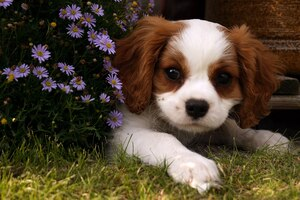

In [ ]:
# Image is Cute_dog.jpg from Wikimedia
fn = Path('samples/puppy.jpg')
Image(filename=fn, width=200)

In [ ]:
img = fn.read_bytes()

Claude expects an image message to have the following structure

```js
{
    'role': 'user', 
    'content': [
        {'type':'text', 'text':'What is in the image?'},
        {
            'type':'image', 
            'source': {
                'type':'base64', 'media_type':'media_type', 'data': 'data'
            }
        }
    ]
}
```
`msglm` automatically detects if a message is an image, encodes it, and generates the data structure above.
All we need to do is a create a list containing our image and a query and then pass it to `mk_msg`.

Let's try it out...

In [ ]:
q = "In brief, what color flowers are in this image?"
msg = mk_msg([img, q])

In [ ]:
c([msg])

The flowers in this image are purple.

<details>

- id: `msg_01SQHE2qGSZYpwFCGLgYfkAZ`
- content: `[{'citations': None, 'text': 'The flowers in this image are purple.', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 110, 'output_tokens': 11, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

You don't need to call `mk_msg` on each individual message before passing them to the `Chat` class. Instead you can pass your messages in a list and the `Chat` class will automatically call `mk_msgs` in the background. 

```python
c(["How are you?", r])
```

For messages that contain multiple content types (like an image with a question), you'll need to enclose the message contents in a list as shown below:

```python
c(["How are you?", r, [img, q]])
```

In [ ]:
c = Chat(model)
c([img, q])

The flowers in this image are purple.

<details>

- id: `msg_01CVTsms6au5XMAMkz8KkLUg`
- content: `[{'citations': None, 'text': 'The flowers in this image are purple.', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 110, 'output_tokens': 11, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
def contents(r):
    "Helper to get the contents from Claude response `r`."
    blk = find_block(r)
    if not blk and r.content: blk = r.content[0]
    if hasattr(blk,'text'): return blk.text.strip()
    elif hasattr(blk,'content'): return blk.content.strip()
    elif hasattr(blk,'source'): return f'*Media Type - {blk.type}*'
    return str(blk)

In [ ]:
contents(c.h[0])

'*Media Type - image*'

In [ ]:
c

The flowers in this image are purple.

<details>
<summary>► History</summary>

**user**: *Media Type - image*

**assistant**: The flowers in this image are purple.

</details>

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | 110 | 0.000330 |
| Output tokens | 11 | 0.000165 |
| Cache tokens | 0 | 0.000000 |
| Server tool use | 0 | 0.000000 |
| **Total** | **121** | **$0.000495** |

:::{.callout-note}

Unfortunately, not all Claude models support images 😞. This [table](https://docs.anthropic.com/en/docs/about-claude/models#model-comparison-table) summarizes the capabilities of each Claude model and the different modalities they support.

:::

## Caching

Claude supports context caching by adding a `cache_control` header to the message content.

```js
{
    "role": "user",
    "content": [
        {
            "type": "text", 
            "text": "Please cache my message", 
            "cache_control": {"type": "ephemeral"}
        }
    ]
}
```

To cache a message, we simply set `cache=True` when calling `mk_msg`.

In [ ]:
mk_msg(['hi', 'there'], cache=True)

```json
{ 'content': [ {'text': 'hi', 'type': 'text'},
               { 'cache_control': {'type': 'ephemeral'},
                 'text': 'there',
                 'type': 'text'}],
  'role': 'user'}
```

Claude also now supports smart cache look-ups, so it's very simple to keep an entire conversation in cache by constantly telling it to update the cache with the latest message. To do this, we just need to set `cache=True` when creating a `Chat`.

In [ ]:
chat = Chat(model, sp=sp, cache=True)

Caching has a minimum token limit of 1024 tokens for Sonnet and Opus, and 2048 for Haiku. If your conversation is below this limit, it will not be cached.

In [ ]:
chat("Hi, I'm Jeremy.")

Hi Jeremy! Nice to meet you. How are you doing today?

<details>

- id: `msg_01Lj8HcEdZmz85MVBeR1mpg1`
- content: `[{'citations': None, 'text': 'Hi Jeremy! Nice to meet you. How are you doing today?', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 20, 'output_tokens': 17, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
chat.use

In: 20; Out: 17; Cache create: 0; Cache read: 0; Total Tokens: 37; Search: 0

Note the usage: no cache is created, nor used. Now, let's send a long enough message to trigger caching.

In [ ]:
chat("""Lorem ipsum dolor sit amet""" * 150)

I see you've sent a very long block of "Lorem ipsum dolor sit amet" repeated many times! Lorem ipsum is that classic placeholder text that's commonly used in design and publishing.

Was this intentional, or did something go wrong with copy-pasting? Either way, no worries - happens to the best of us! Is there something specific you'd like to chat about, Jeremy?

<details>

- id: `msg_01UnejxDEiu2xd6TgUxXoHxE`
- content: `[{'citations': None, 'text': 'I see you\'ve sent a very long block of "Lorem ipsum dolor sit amet" repeated many times! Lorem ipsum is that classic placeholder text that\'s commonly used in design and publishing.\n\nWas this intentional, or did something go wrong with copy-pasting? Either way, no worries - happens to the best of us! Is there something specific you\'d like to chat about, Jeremy?', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 1084, 'cache_read_input_tokens': 0, 'input_tokens': 4, 'output_tokens': 84, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
chat.use

In: 24; Out: 101; Cache create: 1084; Cache read: 0; Total Tokens: 1209; Search: 0

The context is now long enough for cache to be used. All the conversation history has now been written to the temporary cache. Any subsequent message will read from it rather than re-processing the entire conversation history.

In [ ]:
chat("Oh thank you! Sorry, my lorem ipsum generator got out of control!")

Haha, no problem at all! Those lorem ipsum generators can definitely get a bit enthusiastic sometimes. It's like they're trying to fill every possible space with placeholder text!

Are you working on some kind of design or layout project? Or were you just experimenting with text generation? I'm curious what you were up to that needed lorem ipsum in the first place.

<details>

- id: `msg_01SoNcTWfKzj2pSAwftGzMzE`
- content: `[{'citations': None, 'text': "Haha, no problem at all! Those lorem ipsum generators can definitely get a bit enthusiastic sometimes. It's like they're trying to fill every possible space with placeholder text!\n\nAre you working on some kind of design or layout project? Or were you just experimenting with text generation? I'm curious what you were up to that needed lorem ipsum in the first place.", 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 102, 'cache_read_input_tokens': 1084, 'input_tokens': 4, 'output_tokens': 80, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
chat.use

In: 28; Out: 181; Cache create: 1186; Cache read: 1084; Total Tokens: 2479; Search: 0

## Extended Thinking

Claude >=3.7 Sonnet & Opus have enhanced reasoning capabilities for complex tasks. See [docs](https://docs.anthropic.com/en/docs/build-with-claude/extended-thinking) for more info.

We can enable extended thinking by passing a `thinking` param with the following structure.

```js
thinking={ "type": "enabled", "budget_tokens": 16000 }
```

When extended thinking is enabled a thinking block is included in the response as shown below.

```js
{
  "content": [
    {
      "type": "thinking",
      "thinking": "To approach this, let's think about...",
      "signature": "Imtakcjsu38219c0.eyJoYXNoIjoiYWJjM0NTY3fQ...."
    },
    {
      "type": "text",
      "text": "Yes, there are infinitely many prime numbers such that..."
    }
  ]
}
```

*Note: When thinking is [enabled](https://docs.anthropic.com/en/docs/build-with-claude/extended-thinking#important-considerations-when-using-extended-thinking) `prefill` must be empty and the `temp` must be 1.*

In [ ]:
#| export
def think_md(txt, thk):
    return f"""
{txt}

<details>
<summary>Thinking</summary>
{thk}
</details>
"""

In [ ]:
def contents(r, show_thk=True):
    "Helper to get the contents from Claude response `r`."
    blk = find_block(r)
    if show_thk:
        tk_blk = find_block(r, blk_type=ThinkingBlock)
        if tk_blk: return think_md(blk.text.strip(), tk_blk.thinking.strip())
    if not blk and r.content: blk = r.content[0]
    if hasattr(blk,'text'): return blk.text.strip()
    elif hasattr(blk,'content'): return blk.content.strip()
    elif hasattr(blk,'source'): return f'*Media Type - {blk.type}*'
    return str(blk)

Let's call the model without extended thinking enabled. 

In [ ]:
chat = Chat(model)

In [ ]:
chat("Write a sentence about Python!")

Python is a versatile, high-level programming language known for its clean syntax and readability, making it popular for everything from web development and data science to artificial intelligence and automation.

<details>

- id: `msg_013PB46u6zQzZVdY95MwJ8zM`
- content: `[{'citations': None, 'text': 'Python is a versatile, high-level programming language known for its clean syntax and readability, making it popular for everything from web development and data science to artificial intelligence and automation.', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 13, 'output_tokens': 40, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

Now, let's call the model with extended thinking enabled.

In [ ]:
chat("Write a sentence about Python!", maxthinktok=1024)


Python's extensive library ecosystem and cross-platform compatibility make it an excellent choice for both beginners learning to code and experienced developers building complex applications.

<details>
<summary>Thinking</summary>
The human is asking me to write a sentence about Python again. Since they asked the exact same question, I should provide a different sentence about Python to give them variety and new information.
</details>


<details>

- id: `msg_01UbfT3f376MrU8vbpxfsG2V`
- content: `[{'signature': 'Eu4CCkYIBRgCKkAVV4NDf1TpAMYVXshahtBTg0hb4uXCMwqLLKTEn0mi9BtprOn83A60Dc8IwmqvvPaEyPyd/Bcfh/l0y6gCGbMaEgyDLl3vvDSsYt47pMMaDFthjCQ/grxRxhHdbyIwWNe6Mxr6PP4ySHIXQf9XkUtbI1zZ5Nl+MNCHZHWOS8S8p0XAp4MNEXIZD9C38pJoKtUBNp+qP+aNe6cdyCiB4jFfZiVLGJIAb7d3H1r0y0V37ekyu/Gk3acTpPX9nzr33ktQ8cw2XbiavrMG2tFPHtGKC2Gq59Kt1JBX0ZQ/OaF3fCvOp+UKjrd0Vtk+sOFwa2lApMHh65vWQH1rC7NQ/bl1n3O8Ml2kmbIlLDbgQBQ5gSqh7F71byZIrkHKDcNp+SdptNmapgDqhzsL91NKTy3u6Yg3sjItStHPusKCi4ABdyyiAAUb3D874Ggk3TXKaOcfbewpbWkUTw0tik+7otuUIIxZ+NBQGAE=', 'thinking': 'The human is asking me to write a sentence about Python again. Since they asked the exact same question, I should provide a different sentence about Python to give them variety and new information.', 'type': 'thinking'}, {'citations': None, 'text': "Python's extensive library ecosystem and cross-platform compatibility make it an excellent choice for both beginners learning to code and experienced developers building complex applications.", 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 90, 'output_tokens': 78, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

## Server Tools and Web Search

The `str_replace` special tool type is a client side tool, i.e., one where we provide the implementation. However, Anthropic also supports server side tools. The current one available is their search tool, which you can find the documentation for [here](https://docs.anthropic.com/en/docs/build-with-claude/tool-use/web-search-tool). When provided as a tool to claude, claude can decide to search the web in order to answer or solve the task at hand.

In [ ]:
#| export
def search_conf(max_uses:int=None, allowed_domains:list=None, blocked_domains:list=None, user_location:dict=None):
    'Little helper to create a search tool config'
    conf = {'type': 'web_search_20250305', 'name': 'web_search'}
    if max_uses: conf['max_uses'] = max_uses
    if allowed_domains: conf['allowed_domains'] = allowed_domains
    if blocked_domains: conf['blocked_domains'] = blocked_domains
    if user_location: conf['user_location'] = user_location
    return conf

Similar to client side tools, you provide to the `tools` argument in the anthropic api a non-schema dictionary with the tool's name, type, and any additional metadata specific to that tool. Here's a function to make that process easier for the web search tool.

In [ ]:
search_conf()

{'type': 'web_search_20250305', 'name': 'web_search'}

The web search tool returns a list of `TextBlock`s comprised of response text from the model, `ServerToolUseBlock` and server tool results block such as `WebSearchToolResultBlock`. Some of these `TextBlock`s will contain citations with references to the results of the web search tool. Here is what all this looks like:

```js
{
  "content": [
    {
      "type": "text",
      "text": "I'll check the current weather in...",
    },
    {
      "type": "server_tool_use",
      "name": "web_search",
      "input": {"query": "San Diego weather forecast today May 12 2025"},
      "id":"srvtoolu_014t7fS449voTHRCVzi5jQGC"
    },
    {
      "type": "web_search_tool_result",
      "tool_use_id": "srvtoolu_014t7fS449voTHRCVzi5jQGC",
      "content": [
        "type": "web_search_result",
        "title": "Heat Advisory issued May 9...",
        "url": "https://kesq.com/weather/...",
        ...
      ]
    }
    {
      "type": "text",
      "citations": [
        {
            "cited_text": 'The average temperature during this month...',
            "title": "Weather San Diego in May 2025:...",
            "url": "https://en.climate-data.org/...",
            "encrypted_index": "EpMBCioIAxgCIiQ4ODk4YTF..."
        }
      ],
      "text": "The average temperature in San Diego during May is..."
    },
    ...
  ]
}
```

 Let's update our `contents` function to handle these cases. For handling citations, we will use the excellent reference syntax in markdown to make clickable citation links.

In [ ]:
#| export
def find_blocks(r, blk_type=TextBlock, type='text'):
    "Helper to find all blocks of type `blk_type` in response `r`."
    if isinstance(r, dict): f = lambda b: b.get('type') == 'text'
    else: f = lambda b: isinstance(b, TextBlock)
    return [b for b in getattr(r, "content", []) if f(b)]

In [ ]:
#| export
def blks2cited_txt(txt_blks):
    "Helper to get the contents from a list of `TextBlock`s, with citations."
    def escape(s): return s.replace('"', '\\"')

    text_sections, citations = [], []
    for blk in txt_blks:
        if isinstance(blk, dict): blk = AttrDict(blk)
        section = blk.text
        if getattr(blk, 'citations', None):
            markers = []
            for cit in blk.citations:
                citations.append(cit)
                markers.append(f"[^{len(citations)}]")
            section = f"{section} " + " ".join(markers)
        text_sections.append(section)
    body = "".join(text_sections)
    if citations:
        refs = '\n\n'.join(f'[^{i+1}]: {c.url}\n\t\"{escape(c.cited_text)}\"'
                           for i, c in enumerate(citations))
        body = f"{body}\n\n{refs}" if body else refs
    return body

In [ ]:
#| export
def contents(r, show_thk=True):
    "Helper to get the contents from Claude response `r`."
    blks = find_blocks(r, blk_type=TextBlock)
    content = None
    if blks: content = blks2cited_txt(blks)
    if show_thk:
        tk_blk = find_block(r, blk_type=ThinkingBlock)
        if tk_blk: return think_md(content, tk_blk.thinking.strip())
    if not content:
        blk = find_block(r)
        if not blk and getattr(r, "content", None): blk = r.content[0]
        if hasattr(blk, "text"): content = blk.text.strip()
        elif hasattr(blk, "content"): content = blk.content.strip()
        elif hasattr(blk, "source"): content = f"*Media Type - {blk.type}*"
        else: content = str(blk)
    return content

In [ ]:
chat = Chat(model, sp='Be concise in your responses.', tools=[search_conf()], cache=True)
pr = 'What is the weather in San Diego?'
r = chat(pr)
r

Based on the search results, here's the current weather information for San Diego:

Today's weather in San Diego features cloudy skies early, followed by partial clearing, with a high of 71°F and southwest winds at 5 to 10 mph. [^1] Tonight will be cloudy with a low around 65°F. [^2]

The air quality is generally acceptable for most individuals, though sensitive groups may experience minor to moderate symptoms from long-term exposure. [^3]

For more detailed and up-to-date forecasts, you can check the National Weather Service or local San Diego weather sources for the most current conditions and extended forecasts.

[^1]: https://www.wunderground.com/hourly/us/ca/san-diego
	"zoom out ... Cloudy skies early, followed by partial clearing. High 71F. Winds SW at 5 to 10 mph. "

[^2]: https://www.wunderground.com/hourly/us/ca/san-diego
	"... Cloudy. Low around 65F."

[^3]: https://www.accuweather.com/en/us/san-diego/92101/weather-forecast/347628
	"The air quality is generally acceptable for most individuals. However, sensitive groups may experience minor to moderate symptoms from long-term expos..."

<details>

- id: `msg_01NgbKy4MXQGcetZyu86UJ8j`
- content: `[{'id': 'srvtoolu_01KbTLnYLmCSi2wHsaJWqzys', 'input': {'query': 'San Diego weather today'}, 'name': 'web_search', 'type': 'server_tool_use'}, {'content': [{'encrypted_content': 'EqcCCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDBQ1ZocR3G5gsl6SKxoMt6imlGX9/vSAyMftIjCP9FDP9vMK/JX9Sp8fzmBQE0GpqqfkRfjeNQ6OWS65tfVfWxti8oMFyYJ1A6rNvvoqqgGyih3YN/Ob2OlZB7YMUIpugeOwpxu4SyBHJV9anLnA9S8xesvzjqhhcJKVBcPczhgeRIhMWnKFxR6/hfW+t+FVNfnkkGAXTF7YJlnNJe3axYTguqITjdHK3/DpHNfoQp5/7grtZSw6e/DRX6EYm6hVYFvF7fFQiljoUHLjseMNddDC5aByPwwzE18GN+a7pCkvxAf8CQptb93ZUgJcaxG9PKmAiB/nH0qmZRgD', 'page_age': 'June 18, 2025', 'title': '10-Day Weather Forecast for San Diego, CA - The Weather Channel | weather.com', 'type': 'web_search_result', 'url': 'https://weather.com/weather/tenday/l/San+Diego+CA?canonicalCityId=3b2b39ed755b459b725bf2a29c71d678'}, {'encrypted_content': 'EtoLCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDIOQtRuTiNa3IRazYhoMmBIyCaGYwjtyWLdLIjCNfBRTBSU0/lVHhLhCcuTm5zko7dcF2Rh9Kz8zGlag21saEVFKEhiGTuseA4vElM4q3Qob1sJ3s8W7owq04hpFFIfpduRUdYDrncSQPSzQkQfzqWHg54TM5fNiLJG5Hr/JP5ue+qfV7X6A31vtEvMicqEGUvBmDpHjEEI02E/OMiNvpEKUiF8H1KKce9Rik5XQfbfRipTM9lUNsdMW/Tz03bdfVak6Xj9U6pH1OEL2/mih1miH5WqyR6AYQzaWZC3wtNVrI7g+3NZCl4Q3DxGsZ5sorCtj52kvbVwnVpdv7RDAe9b/xH9FT4yVrvgt7zE44KKxcMWgmbVwWYlNU3iZHzXxIirwNhFliIJAgxYMzfPVHPCmntxHm7E7s7fCR4tT5gX7cA14QWKBYaXXePQlztuZXVDuCsbkikYHwB5cQQcn+fRGb3BSjitKawSI6XExry9nmRU1LkYs4M+JVfbtuFa5L5a103gmB4nHK+PQ4IJhunlPfG7aRR4oke/YENps0CDD85lSlhsIQ4+3ZiPGPsbVneU+9Ab1O7JC+pX537PBWGnZAloIGAR/Q1a0nvM0RIBJHXxafMP8y+D7ndBk/OWHbIsNr3b8QdJ8zSDPRKhPCAVtDjQVHl+oiNnVWUTtuNiRiD2r3KUi3lnVJ4gODMBOSgMKmtzaB9x+yNtsPcVa8p9LhqmS6NBiUgj9A796Kh29zzyVAJGtjuOFCwVnsoC8UwtPd4bIBhjWI7c+pVMO+KBgdFB2ecObCEG7j/px5V3mb5Fn+Q2abdE6lYLPcCumHoQUpf9fN08/h5M97zSG9IcGJzZ6FuOBTT7RbAIzdm8mNJ78dSVb3qRNj9NZ3GJ9aY81aGDTvrEJ9cgOJbb+EPMw4aDiZQ1rgibZ6emAOuOy+szux844+2XbhWIR1yCCdx06IZ2jisV+XwBzrUTdin9rBUXsrJnbavW/l8/D38cDli/GP80JhPuVQ7tHDsvn4u5Izkup0uJD178ojc1kQhpEqswELVg7ymh/nFE7LHYB7zklQvVT0etS0YtaGYR/0K96FvjItT0RhtH32fPLJCXSPynIzMK/XiuYggfrxtm6zksbCw6mRP8t0WL+uXREvyPRukgWfU40zvVQ0ZijRlMChia+yj3IErJpk3wND/qzM1OA2eUWtgL+79dZcguUw7GOsHsKuOPUTz0uSffEr5g5WPQVK/466RHWk/TbrU6CngGfh2uBOMLAgoesp1h2wX3Uq1ooUlHGskqT6JVABrzxoIKdFtk1bhgicFA01WqJ9R1Aj3N4ip4tegX0WDF5Q1RbrEbjlqNVyr7x/AFrf2skOl7g3HPd0Zid9vgugFrlzdup8ITjWnNZbXYASDRqd6mNm9ER+3yoEJcNUUGKWeTLX0XhAfxcXq0xEKNw5YyA8Bv99ZjlnrcP7jgRgLkc+kFm6nMwTGQiyv9LXreC0XdqqTrwMUxfXF1UBEyUE8J03OlyFVytGYlUDN3JPx4FtYXy9YF0wSKtW3Gyr1QcEwTut255k2oze7phUMVGOcHJMONCdq2dRHC9jiWrvWMhEOZ1FCGA4DnwOCVa4kls8+0jcF42DVN48ZtNASYww1lisHb7DzZHoJzqomFmUuy29qkXylY3rw6vgk3V4M9P3SLxkfkBmkxFA5l0djzgbGBUSpTmunndzUipoIFREV2NQNWXwockuwluPix6KJniZSfSEMzLNKmeix/zGFlIAhW0nabSu5GIlDbLBUt7VKK6i/E6G+uCEUcM+OLV7cSIbsWVcsrI9xb8AE7rknh+5nkC5Id5Qd89fB44S9hP2PPlX7bVnQDzxq4VH34Z4gFdHpzpbv0T88bvtD/LeSOXL6lT5fTL/mmlqF6zHi8X9LmJujiu2gmeZcQlub0PGxgD', 'page_age': 'June 18, 2025', 'title': 'San Diego, CA Weather Forecast | AccuWeather', 'type': 'web_search_result', 'url': 'https://www.accuweather.com/en/us/san-diego/92101/weather-forecast/347628'}, {'encrypted_content': 'EpcCCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDO2mS5zn3mJLyR4UexoMd3ZyxuCBoX8XGiNcIjANb3JzKlzsZcqjJs01X0opJgIpQyE+Lduh8390wcEHl76TugBuFnSEFWxffsu5/NwqmgEVioiV9w1DaiRUtVKeAi5DUTT/KL1n4Ml1AYLD7TcyvoK5/eT6Iael6TrgfbX3sLFeypbjyZ5Ydk72ii5Nu/lEJjAbrUvRUZ/zn4Ryv3A6UC324EdtVwq3QYSPfvwONLUxG9pYULY0NQBwqx0o3EcrjNjR1MPTA1IOYkZSgm+QmMAJUs6hdKzYmVzrmXDCgWxVW+tHJRTWKmeTGAM=', 'page_age': '5 days ago', 'title': 'Weather Forecast and Conditions for San Diego, CA - The Weather Channel | Weather.com', 'type': 'web_search_result', 'url': 'https://weather.com/weather/today/l/San+Diego+CA?canonicalCityId=3b2b39ed755b459b725bf2a29c71d678'}, {'encrypted_content': 'Er0ECioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDIwePlt9T9MJvpY0KRoMD7H0Cbv6FYTCiXTWIjAbUoJiyIsrZvpb2docY9veLabGx62w4lxkoOQtNT0ySV9MlczMQ99HFcPBFNQnpv4qwAM/jWBouSk/tMi9OB8IxGZG/39KsohjqxFcfcubMxZ/FQReTrX2/7v32tFU7znXY4guvytW9tuYFtKTfqStDdvKyHQquq1uSljWjBuRMDkjpH7KTe8fcTDd/8s3wbdPYG7fsbKiO0K3d2c2LJDZCPaASoL7KFPWdzbTPjgjI7LnSNr5JsytHj4E4vqI4QPV5tNr6SmhJ75S/Y3Dq2tTUWDhhjtOQQ1QOVVw8QAfFkiJlaUbx7I82GX3FAScbGxHW3TvcMvSM7oe/mUmUXfHAW8yH8ohj6Y/WWiCZOKT96Y0Lg6a0Thfj7oDTgREKDp7Y6yiKxojrp1FDjfA+a1Fc7jK4ymBah9RlzOv3Op/xcktxm+QN5hbxv2XqgBhY2y10qggUZiGzIXuWtZLX0lrIAeIX1Mg37fIMS5hMaSZaUvWrHaZBmX+ZhlEOz2DXP6uo1jY7n9HyIpY/7qLgwgBscZFsQIN+eGhP4R56VrFg5u1jptXPES4TJK8mwlujI843IgfW3vfn1GF7t9SD9VIUqWJbiAAglZf9K7wYcEVTMbqsRokUN3ts/0BIjlWNdA6BAurBpIuseIFd2K54DLxx1u+GAM=', 'page_age': '1 week ago', 'title': 'San Diego weather forecast – NBC 7 San Diego', 'type': 'web_search_result', 'url': 'https://www.nbcsandiego.com/weather/'}, {'encrypted_content': 'EsoCCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDD/hWGXJxgqCA6KLfhoMEfv4QpL/mx44N7WPIjC7MdqyZkWH6HBnkTZdeXwAMZAThJh3s0AqwX2zKyLu+twXPZV0nm6ydMieGp/Jo08qzQHykgbRU9WA3mVLfvImMBnW5U4mHcmOTRcKc+o/gGabXaD+4sLbxgWQ9UX3IwzQPe5z/slmFte8UMnQTYv+5O4F3sRm3Z7sNbKvkCLxOsOSDzdH8wd6Zd9J9lgj+wonn1GNSd+yZOC8Fkuqg5EgyxZbLgMvyusCmk/6MFzrS9o8YbVcj/ha2jDRzWSl+Cpy64RsjOxwapX6tzKcwi6m4BtFOkeSTgunGrwJqfUqu1WBmCV/oz3VHj7/jQiHNyxL2NNuKLALr9gLGjKLzE0UGAM=', 'page_age': '3 days ago', 'title': 'San Diego, CA', 'type': 'web_search_result', 'url': 'https://www.weather.gov/sgx/'}, {'encrypted_content': 'EoQHCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDK5Swhtg6+6Pm9idbBoM0xwZ8J+GktDkpVphIjBgTTAiibceYW1ECPoWNHXMYczBsXmPp+4fSWkYCryG+cZaEzh6spxuFTHyxn33NHEqhwbxFVA07Fa2v1ZIwNs3wtZ8qnxXrahu1ljjN3lYfoGGMjljzL7E/An/D+BV7I4fdMiaMNTjcaAUzxC/BQc4nzvFA6Vd53dri6XYZeMULm45inqS9oSN3r1Y9WQnDkuaf4O16LUuuOA+RxR2lA6nO0+oUJfDtHTUOMrCMZowQVfx43TUiZsm6Dg62LgKW+l8Wuau+WsRA7ma0c/rvjCI6k171XeeAtLQLC3HyVQ5p6446bN+gEpc574LqvEXKjG1qUZbFaRMp4VCLWgR3e/ehrquOZ1ZNO2HzI+dTHy7sTVpx20Hx7NFz55DZQANX2pY3cRNacjOElmcepQThvSPpYfQIhh3NA14vM31w18/kGD13VRIH9w8CbZW15q3yf9O8UqsIA8jym3sMvNdyGy6YHx4p7r4DBX39AW2BPZt4iR/M5MXHy+xLy/VGyWZ6i+foJ+HCDtDaAtIJVDg3ivj4q0fqtrDrMc4MeOuFNTdfwgmCvmn7YO97maYg9OO3C+Iw3Xl85pA47Xtq4wGH/FMxk3A5Ej7woytNXqzSe+eMmEJZRFvBPW4x/vRN3Z7/MVUuHC6jpzDx+3CoC0A+MDTEyNezgQzqNLkm0N/J7dxgAWi7eb4wbImxfcwTvPvvNFeuEgVjTfC6eIq2wcy9crYq1ZiMTrvHU0QMZB/iOC45Yu3Ue1On4w+9GB+M/RtHoc+jsjrZ8Sz9cH0oyRXOL19qoU20MzYHrz5kE7t2EVVkfnVE8mVpcq2B/uSSxtYpjq5CZ1Vlmt85VjKEP5aJol1Xc+UJmdFpyKCvmhFMxo+htj9vgA89/cC28Cm2NUmy86UIuE0PiZ9TMj6lCPORbuSHc9/9XEYu8rbDbTV6PjsApLLO5xQra/xprwldfib49/6qK9jq33NecX3QuznjYIGK0sRB8fl00GuZG3L9ADNy3hcKScyNoTJW9SsvMxZwHkc48L7FpkU3wUN8VghILMWCtlMiRbYR5ddAYcfKf9nVdeUnYruKPQJsxvnS1Qy4otTHgfGWJ0Yaq9GGAM=', 'page_age': None, 'title': 'San Diego, CA Hourly Weather Forecast | Weather Underground', 'type': 'web_search_result', 'url': 'https://www.wunderground.com/hourly/us/ca/san-diego'}, {'encrypted_content': 'Ev8CCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDOmr8hjXrDsqGLzgpxoMP/SsA7+8648ERRZeIjBozzJV1ArRZmzKavi7AM0o9wKf3ELbQADEgBl3W+dygo2tTRxSnwgh7KwJ9Dt6JZAqggK7bM7m5HJIY0U1gSdcWTGHWGy8GlIZGMJci3mMvkdEA8mIH7V1LW/kRhktT3A0UUwLp5IS37eEzZ1pTpUp8zbtTdUduSYbw8By3zPWu1l70uNx1f821o2Z7EfvctKqBQyG9ekoDzvYOznI8x9LWeRcAsluqydcmHQgOq8C63KxkqgIKvsGOwuq2vA5thxrDlxaaY/wu55nzDGJ85bMXM/rgOfPOo+9raZWfSxMOPSFE0QJjpc89wPjaK8sR4z8Fu0cwvdlR5qjPdGTqUjyoXlf1SFXxn82IdDqV1N4RWSENc4YB8bPOr+WSPngJotx88Hed2AQza3ATn5jFQiu6OZ01ecYAw==', 'page_age': 'June 16, 2025', 'title': 'National Weather Service', 'type': 'web_search_result', 'url': 'https://forecast.weather.gov/zipcity.php?inputstring=San+Diego,CA/'}, {'encrypted_content': 'ErYCCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDIM3rEe7dfQmebDYUBoMU9XLO3E73J5U0x4dIjAwlVz26rgqdTax+uswxD/oExlBM25NyW4EhvXUYSaVaI/6gRv3x25fz1azKeyt9qgquQHWRkn9qSnfOW3VYO8wa6LcrZU11ZByuxZVCdtVGWqN2JurmwOCr18SU8xkTPBzn9sarNt7r7XiWp5oPJ/E+tcKHc57+7Y4q0IdPzkCg/3spcNZZOmHRKZgfrGI1Ze+G+Vol8IrgVyg/R1bSla76LYrQkwzItB2Wh/kndmRhrSbSHX7ZgciMLPrklAXq6ddA5uGpzSNqouPxIsUIfXJw0/Gtao+KLm+6CS1EqCrmzOMh9611oE1gjPhOhgD', 'page_age': None, 'title': '10-day weather forecast for San Diego, CA, United States - The Weather Channel | weather.com', 'type': 'web_search_result', 'url': 'https://weather.com/en-GB/weather/tenday/l/San+Diego+CA+United+States?canonicalCityId=3b2b39ed755b459b725bf2a29c71d678'}, {'encrypted_content': 'Ev4LCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDDnPmhepNHWWlNaxIBoMJfmY/DLAlFSVqIRbIjB5of9Vs9J3i03QXTV7PRhSMhs599TsRL0ETLzIGC5uQhpvBK5Rh7nOpGI6yskv+dkqgQtCmX/USsGq3WKzrfakRrCoNPbhrF+1bL3xa/7TCB+2L/amnILO17srUB8y+RJUPVXH7LahBbrVadF1uouwYADv5MhdiIhTio+x0WhmZHCymplHvvwFyNff35plzaNJgXnKI/YJlTAmgMhHD81NEuAYAwgIBAzsUXAtLr3bweFdSlaReEsg9aFG2/w2F3w3/hgRTT+RHxFIvznQa8L3I8cFDf13Nc1zRGhyKdtC3MwmjEqW33oT5bhF2SU7ep/VjvPW/catSk8FvTm7DLXG82zSkNYOXcwsPNCiIldBJCtsN5FNsadiYUuwm2HoX+3GlKSECi6V++Ufi3yY9PQ+Ww3HMJCwT7q57fOgaNisDYYfpfCYGfHh6OoDD4qhwQ35IxI41SJOXdgc5wOTSgHFTMAjKIoc5U2dwI+4Ovu+kXPlRYr0syCg4beGwTmQeUp4N1U2P6Dn1JpiNQeFkObul7RCjCuRKzN7ZiwAacGEFZtXcHcDW83kvPyStNN2aJo6GNYGQutLScNaanODQKXjIcIeOz1ZOn0fW0VboX9IQtw7QHq+L3ID+rwXA3PcIpNtii0nrhXaTKLN5sJzPL/xqjVjE7OFHo89rYKWMJaFvQ9urHHe3XQfdj8C1QF2IlYrGi3U6D6lpnEmVF2pQtziOusj7QrhYL8WVZG19JTlzahReclpcZWMIOu3hXzLpEWtjvxW0AM0FYXzzZcBuB6epDrB68vZ4KSiL84vFqC1hCYJ3saPHHAslvZwwwxP6x9IYQkYvndQb2kcs3qn9eDVYtyLEz2xZBwg+xjKfaZxx2Zv6jAECd88UY3rdFAAVC5iee4utOT3/7igQdK9xDO72GeYQEs9DJAsicbGVcO8UsfkebQOlSkyCevmALtOiBRfH9ktS+udIUdgScmiOV3dzyhYI7r0WZe1I4qAEhvAO5fZH/7K2hDkElE404ieGrETNWaGaxfqpSIpm4ynoDPcdaRWCQsTTViDeD5nR6RZHHz848SCbuIqLWsopBU/tDJ0Lyyj8ydAQZ1kP2II8AxU10ZKAjSgL9cf6r7jGdkT/1g2Yw9OrhEKlsUemka2VKGzV+5sYUU0BBVMPUt1bEAGERykPE06TiVyA35v3z7IRyvYe/o4RQ1ttKop3o/kNOdlUnC/75J5H78kLuSrqPBeWzuCcVOKynE4wUJQc6DRUza6E5sbEFRMlilW7Imw/j9N7JLRyUEcOw4SSkWWvx1zRS1zLft8VhL4mD+45Fr30Rh4JLgLIePQj2wG2y6Y71i2LD1g21aklfayYdBYENDFg7myoalJUwDAH9voMZTjcm/XRkdN1PXi++nvDVkAlB7k//jO24zZ4p9FdbvC2+RbJdv8v+O0BkzGVZjNhKDv0QvW18z/LGHXdmoVXCwVAs37vGb9DO6ynJFExtYnTyjvPbDMfDbQ9d5+hOorLbHu0qhIyapQauF4i0WYfi/OOcojyef45qO2M0bCP0/Luy68vhTwdA7loWCzySA5CTlaVrE5Iudn0Rhsn5FqJXrNayTC8QR+DmvDyo/iFUoSESb0Wg2iE4MvAMLEFRnJqn8zqj6sbSs/BrSeyqk/dldyzwMgLP7hfPc2+0v+fUJhBI0byfgRXo9wn+l1Id02umoQCTlntRyqSLbi1G64E/xS99nw1Wkk9HM1BoJlmDDfB1geAeY0j9Lvi9Aa+5AcOvr06afhdnkZd3A8Fc8fcYxZB3JpCmdfcjpTz/7nd08eWDTyisH8DM5lhDX/Nk61ZRLLEus+MVRzxOXfu8dJu+X+441SlyhthLuf55RucObWvvgL8qYgd1dN0BD/TeqF+o59R7IW/+qEkm96WK0t9zevBoTBAWUTiCYp39wzOniIhEPtbudOIRgD', 'page_age': None, 'title': 'San Diego, CA 10-Day Weather Forecast | Weather Underground', 'type': 'web_search_result', 'url': 'https://www.wunderground.com/forecast/us/ca/san-diego'}, {'encrypted_content': 'EpkCCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDDI+MbsWj0moosytxxoMfPAXm1SwECzkqguYIjAYOxITweceBS9wIHq05acgo3POleEc5c6A38bTFkIb9b8fe+xk15ttDRN/8i98ERQqnAGhz3BkKiQQU8vf+ySMxm98dhWITX6NowEwiQuG/Fb1X0QjjMRQwuhqVkzL6GXWk05JmgqlSFTdFa+5oLP37ADiHAOJuKSEG8w5//cgxMgFAj05OrmFZx/q95MwF7g/vMerGVO9j3o5TgKSPPGXDvZ/k6RHAvjyr8JABIXMFoKKJe8IVIv1DjZ/tgecWFkrzk1CII18/5rY4Q3pPhIYAw==', 'page_age': None, 'title': 'San Diego, CA Weather Forecast | KGTV | kgtv.com', 'type': 'web_search_result', 'url': 'https://www.10news.com/weather'}], 'tool_use_id': 'srvtoolu_01KbTLnYLmCSi2wHsaJWqzys', 'type': 'web_search_tool_result'}, {'citations': None, 'text': "Based on the search results, here's the current weather information for San Diego:\n\n", 'type': 'text'}, {'citations': [{'cited_text': 'zoom out ... Cloudy skies early, followed by partial clearing. High 71F. Winds SW at 5 to 10 mph. ', 'encrypted_index': 'EpIBCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDOnF+WepFsavWsAepxoMZ9UqwESDuFxQpTp+IjDMmArHtrGLYOVhhJvn49J0GBprIdscYnB3hZi0EloYH+wKcdWeWtVoQa4gO8QhTggqFmjIYKLRlC+kTEaCzNSzDQhm4OKrk+UYBA==', 'title': 'San Diego, CA Hourly Weather Forecast | Weather Underground', 'type': 'web_search_result_location', 'url': 'https://www.wunderground.com/hourly/us/ca/san-diego'}], 'text': "Today's weather in San Diego features cloudy skies early, followed by partial clearing, with a high of 71°F and southwest winds at 5 to 10 mph.", 'type': 'text'}, {'citations': None, 'text': ' ', 'type': 'text'}, {'citations': [{'cited_text': '... Cloudy. Low around 65F.', 'encrypted_index': 'EpMBCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDLfc3UDCqj86wQ6chBoMNyU/esgtCXinVjvFIjBcSpLJgFf+CYIqK38A4eQ/n73KvdL9U+CNrBTk1X17+W9oWWyYBau9H+8JeDS8qG8qF4Y4QT0MAMYVxS4bQfjD2WqI6hBEonUcGAQ=', 'title': 'San Diego, CA Hourly Weather Forecast | Weather Underground', 'type': 'web_search_result_location', 'url': 'https://www.wunderground.com/hourly/us/ca/san-diego'}], 'text': 'Tonight will be cloudy with a low around 65°F.', 'type': 'text'}, {'citations': None, 'text': '\n\n', 'type': 'text'}, {'citations': [{'cited_text': 'The air quality is generally acceptable for most individuals. However, sensitive groups may experience minor to moderate symptoms from long-term expos...', 'encrypted_index': 'EpEBCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDAq53qgcDfI3gnQrORoMHUN6eiZ0BG45teUZIjDJT3GdudIAFqm5b3a2UByzCVNtRIZT2RjyWsQsuUxP7r5Fbudidc1k/8v2ZMvy2k8qFRxKyMZIdYadC/1ku+mPh6TdqOplaBgE', 'title': 'San Diego, CA Weather Forecast | AccuWeather', 'type': 'web_search_result_location', 'url': 'https://www.accuweather.com/en/us/san-diego/92101/weather-forecast/347628'}], 'text': 'The air quality is generally acceptable for most individuals, though sensitive groups may experience minor to moderate symptoms from long-term exposure.', 'type': 'text'}, {'citations': None, 'text': '\n\nFor more detailed and up-to-date forecasts, you can check the National Weather Service or local San Diego weather sources for the most current conditions and extended forecasts.', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 5178, 'cache_read_input_tokens': 2042, 'input_tokens': 12, 'output_tokens': 255, 'server_tool_use': {'web_search_requests': 1}, 'service_tier': 'standard'}`

</details>

In [ ]:
chat = Chat(model, sp='Be concise in your responses.', tools=[search_conf()], cache=True)
pr = 'Find some funny quotes from famous movies'
r = chat(pr)
r

Here are some hilarious quotes from famous movies that have become cultural touchstones:

**Classic Comedy Gold:**
- "Fasten your seatbelts. It's going to be a bumpy night." [^1] - Margo Channing, All About Eve
- "Snakes. Why did it have to be snakes?" [^2] - Indiana Jones, Raiders of the Lost Ark
- "Don't call me Shirley" [^3] - from Airplane, delivered with Leslie Nielsen's perfect deadpan timing

**Modern Comedy Favorites:**
- "I don't know how to put this but… I'm kind of a big deal." [^4] - Ron Burgundy, Anchorman
- "By all means move at a glacial pace, you know how that thrills me." [^5] - Miranda Priestly, The Devil Wears Prada
- "You stink. You smell like beef and cheese. You don't smell like Santa." [^6] - Buddy the Elf, Elf

**Cult Classic Gems:**
- "Your mother was a hamster and your father smelt of elderberries" [^7] - Monty Python and the Holy Grail
- "Surprised, Eddie? If I woke up tomorrow with my head sewn to the carpet, I wouldn't be more surprised than I am right now." [^8] - Clark Griswold, National Lampoon's Christmas Vacation

**Pop Culture Phenomena:**
- "Bye, Felicia" originated from an ad-libbed quote from the 1995 movie Friday [^9]
- "You can't sit with us" from Mean Girls is now on T-shirts and used in daily life [^10]

These funny, memorable quotes are timeless and will circulate through cultural references for decades to come, going beyond their original context. [^11] The best movie quotes often live beyond the silver screen and serve as the perfect one-liners when you're joking with friends. [^12]

[^1]: https://www.rd.com/article/funny-movie-quotes/
	"“Fasten your seatbelts. It’s going to be a bumpy night.” —Margo Channing, All About Eve · 25. "

[^2]: https://www.rd.com/article/funny-movie-quotes/
	"“Snakes. Why did it have to be snakes?” —Indiana Jones, Raiders of the Lost Ark · 26. "

[^3]: https://screenrant.com/hilarious-no-context-movie-quotes/
	"The entire film is arguably quotable, but the use of the word 'surely' set up one of the most quoted movie lines ever. Leslie Nielson's delivery of th..."

[^4]: https://www.rd.com/article/funny-movie-quotes/
	"“I don’t know how to put this but… I’m kind of a big deal.” —Ron Burgundy, Anchorman: The Legend of Ron Burgundy · 42. "

[^5]: https://www.rd.com/article/funny-movie-quotes/
	"“By all means move at a glacial pace, you know how that thrills me.” —Miranda Priestly, The Devil Wears Prada · 38. "

[^6]: https://www.rd.com/article/funny-movie-quotes/
	"“You stink. You smell like beef and cheese. You don’t smell like Santa.” —Buddy the Elf, Elf ·"

[^7]: https://www.today.com/popculture/movies/funny-movie-quotes-rcna141670
	"Who doesn't know the classic quip, “Your mother was a hamster and your father smelt of elderberries,\" or the laugh-out-loud follow-up, \"I fart in your..."

[^8]: https://www.today.com/popculture/movies/funny-movie-quotes-rcna141670
	"There's also Clark Griswold's memorable crack after discovering Cousin Eddie standing in his living room in \"National Lampoon's Christmas Vacation,\" i..."

[^9]: https://parade.com/1120092/stephanieosmanski/funny-movie-quotes/
	"Remember when the comeback \"Bye, Felicia\" was all the rage a few years ago? Well, it actually originated from an ad-libbed quote from the 1995 movie F..."

[^10]: https://parade.com/1120092/stephanieosmanski/funny-movie-quotes/
	"And \"You can't sit with us\"? Nowadays, it's on T-shirts, on Etsy mugs and all over the internet, and the famous quote—which originally spawned from th..."

[^11]: https://screenrant.com/hilarious-no-context-movie-quotes/
	"It&#x27;s worth noting that there is an almost unlimited number of funny lines to pick out across the best comedy movies but the best ones are easy to..."

[^12]: https://www.seventeen.com/celebrity/movies-tv/a32368812/funny-movie-quotes/
	"The best movie quotes often live beyond the silver screen and serve as the perfect one-liners when you're joking with your besties in your group chat...."

<details>

- id: `msg_01JHb5UF1s5V8VnCdfhkDfTg`
- content: `[{'id': 'srvtoolu_01LTtwYFZisBbKLzmctQxTFt', 'input': {'query': 'funny movie quotes famous films'}, 'name': 'web_search', 'type': 'server_tool_use'}, {'content': [{'encrypted_content': 'EsEDCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDK1RWn1T2mZbUHob4xoMr8AYRYG9dhQwpZmvIjAJH9W/CgnrvpRm5jvSURtyMz1vn+560/ovuxD7U0lacpK0AQ/JfndVnDTLYdmmXr4qxAJ2Nt+Fs7KzhcE7S+IonULqwDpQ5GnHTN89YhbRoi3r1pacAICWhFjYNsRC/FxkLovAPPJqq/F2zIx0qIhx59r8cb/MAKzRW/E5FVH6g15ekU3UaoRPRUbxuXgM/BTfSN4n1hlF1kkS7/+darBLMJN9Ln85D2W7UCl30JitIyjDjBYT6tx+e1lv1Ruc56CpbdJv7ywueLotDdTVIjRUvIldPwMNrkA4kkhWmKdKqqMUR0eSjDd9nSCITucdJZIv2/xkJdOMAELfDCETuXnuTEniMnmn4+VT5gJPZ5bz9YwxdyB/LZDiO8nxpe3+vAp3ooCbngvFKNg4Kzf2SP8+FUi5h89/VzmSJLUy5nwjdE8JkJmbX5nMsDiD6ANHj1luCY5bmyWTyoUp305DlnK2XhKOXKqtkxEgiLfnD4uWRVXtuhkwOcUYAw==', 'page_age': 'May 6, 2025', 'title': 'The 95 Absolute Funniest Movie Quotes Ever Spoken', 'type': 'web_search_result', 'url': 'https://www.buzzfeed.com/evelinamedina/funny-movie-quotes'}, {'encrypted_content': 'EvAeCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDHjU3u0r8WG2MndoWBoMKOZ5xoe674JnAKuJIjCP+2QuwmdtbiNOzAoNPA2j7SGB3F+XfGxg8cwV1KyH9fOgUQNqsfezSywwnZdXj2Iq8x0/IQwiVZLDu4WuyZgTaS2wIb5pA4MULs1Un2/NJ/1J8c9pRUCMA4KnkcHnz3afxC03aT3i2Mq1EBd1/3oPBZEk/pMq6dzV8SabHOfmKc767uUiTv/zHDRzg0ChC35OSdasx7OK/SBMFJtmI/22dOaZE9uXk3UrLffi6qt6VPSREBHLMYvEN1qzAUK38HtUPTmVO1zCfjHO10GP3b1eaA2lU0lhNMlOmUr0o9IEIGZJ+MKshbIa4WoeZwVNqGNbezd9QP5JtnexumoCnv9RkP9V6/vvLfJVJSAT5YCJHc7tcRjlO8th+6PYKo5OHtcR5Zoo+Mhed1MIqs9VEvTdVo/VFzX48Y8wo0V3nRabBTJ5mpeIx60Qn/RN3u/aHXAC4Wcy3FHjto4n6AXxNaRs44kH24uqMntYyH9CKPhYdt/Zi7IVNqFphZ+DulOHB2NPVwyoNA0RKTdh/UHuHHYwlnmxT99VBHp6AXgzeqeWe0J4NQf275s+/Pp58UrW0xxsZYiPXXjpWED2mVmdvI3KtiXcZstbQXHRqj/ETwdoiWcx3Vll/gCsRirk3/ZPk8t2c0jXR+QiIIvmzDYBZWjwqbKR1mYo2uJxV9x5GJOsXtz8wv2mYCQrVWRrobDd1RmgU/MedCCNpOyh3HARuYejtKDqR3kn5YTtnTszFJpSj7IHi6yXcNnHWWC8OoDZvxxtGijWXAIJfV2iSHUYC5xhY9G8fLi4hf5srx128q/Zv8JCk7Oox2g//ICf12LHBz0Fj/wAVzttPiMT4w5FZFRNZ6eOwOOTEiL/zxk0WNS35beC0fEm+64uujkbIyY+sHVacGZaw3049/0ZcG+gLbDdQLnzCE6fgdZA3371ObbL5UcfGvWuNrVdsCQ9N7LD2oixFrp2vkcXS9CnA8YEL37X+aOyavdyr8rp+AeGEzJxutI+IXNXZaoLKYagvg7x5zJVZFd2ja0z9U3H/NDQnG0IjrJatmeYE+wFEUe0oyxeMakLf1yEA72wsq3GQEVBT81by8//ygOuIeHu8mfrf7zKSCjU5g2NLL6UJET5udz1LWBlcSupol0p0Dna1dMBtse/E1LcmEvWGyzfEXeH7/bsFa74tM3s/cJ0whjCfJWFe/olsVg/cJeOh/1MqgC2X6Wor7KtncfQfL0YsyfmI9DrUS6Tx8fkzMznxRmZLVxu3KBMYsTcFGZy592GuVdcx6N/HWqlmOptUHTN/k+6JBtfxJeBPaZ2VZk7IAxSvR4SyJHMxU8vLkoavwCY5ZrmhrpdCee36HwN1ksGk7EeRcmHKeMyZJVqGK3+phzsAOkcw/x0L3K2QsYA1zW8+kcMajRjJv1ffI09srMhNHe3x/5sMXUjslT6mF6dWE3GahUuMmoSRyeBWeS14oU6uk+ZzxEQJuurGXxFyCoBBarC+yU3akLDoMo5TvwcDoICq7Bj1SQ4g079CMmJqXlcwiJnredPX51Wb2WW0IUNwqZzUJcs+XYUxw4TwZPdzO+SyHtpaD6fzFHZcWzO+Yt0MjzqqHK4fFsJyYuMSfkHUQWkf2tNXS5IFm4jwini2v0O80e3J6GRgpbrGilm9x8qbbiVrrsWqliU8f3ctZFK/mwAXllwg/OaMQnwBI19DXAkBwijNHlsGwFmWk0rhSAvWAbsMa4CK5cHGFAV9fkm1r2jzAUdGz/J+Mme5Uj+lCeNsChA6DKIlgszUet8RCYJ91oosRRi4/xRVmVxfmdWrwyTdIUVA4XoxBb6Q4Qe9TAAQiMhC3nx7n5zZmw9ZgOl6GYch4ltkWhgdkuqk3Gmwr4OKJ/ShYHGLNbyl9qXKNph3uNAU08R1ihsEM1wkrs7MXzRjKgQjvSAHASjQ6fP6bul8IUnC65bLPcw+oE500FhmmwH4qrrYjxCdSuvyVKC69wkGUorcoju8k+nzNH5Rd3kXQHpfYD/Fh8ZE7itvSiuFdgXwz3ny72XaqpIQnVk9cXassnhXBJwqYkE+TMtsslmStXkJZQo63Md9IjYH9LQ8HCVJ+t/PdlqnctXFmKzIo9PLr4wwBS/enKzP9mUh8x19XrW7Py9L+z8CAbJR3UVlFzZ3u9BO0mFxL5Mun4SDuUKvtehA8DNcCSS4rzNeIFn27uUXKzJaEQcFaa9Mr0mNaIi40OswmhodVgqGfM7nlqGH8CnePSEBjiW5BpXOD+kJnHo4A8ty6Pvl+HKgMN2cY/ISLlczUyxdOMgNgdr7T1yVasCYyvqYp81K+WVfrhKWU9ryxhvxeqeA8BxIfcTt4FOzNL6rkC66N5SxdY2UNUtEQ7UKEcUlyPqilGVvkmLPZLApehtp99GpRK0d4RPDRLuNb2YZPKMJl9UX0PzQuf3Y7LteT/RlMTz7iY4J4/E/nAROepYblAKgJBum6o+CkjuTcwBVtVTGkhHgmPGd+1y87ZV+odMeEwRtXjBVSZR68ASoC1ia+10ghZtNcVAG4s0MkCp62rX1jMKKXjBTJnLcEho+LYOt5j+bv4Rnf51YnhvoipmjS3nThT8z+SgBRq8iF1DLJu46hcQLK+zFJGS94Uw4mFHP8lomRhW+dBQw8EqQtGk+rvjNWtVuxhq9dZPYxRJBFBaJyHVvgB7ij7o+G33pO0LZb8Q0gTpsk2J2fIqiRUIGbuZirNUbBtoUIgyQXk30QQE8b8acuQqneFdtCQ0caXHgckCIya0kb129pX4Fh7f+sX7Ih+8P+Ft9c7kmGyzJdiOfxxiP+x0DfufbTxEsthU4wjxvxlKF3KU4EBmS9nS581w+w1puJxlDPOs8DbY+MIiOJn7rvmsoYehhRHCBUY/ALJzTKC/IWKTkpxVuat6DN821em623wZ1EDqZYxluMHBZDhX/H+crcMhWtjLXT+YFJ6DOh26QCv4F37fKXOUzsUrA3DlXlxsCROFCR76bXVcaYCxHlV/zZ93yHypO2PYalRQMvuffGPWSzL7bi8aDeP/pRJ3zO0tB7B9HUmgYWoax6B7Q02jj7kmqTyDg7mj1uyr8Uo/b8qE0YrJWuR/G9X5AnOnKHVjzz2XyyHrbKCy7iLsiMoYySBg/TzQI4YZAp8PArl4oeHHKaHf4wPXAi8SkxeWHMidZeGu/9x+B1OvYdhWYOQUP7naUpCWSPVsK/FLJg5R9OR9oPamfG6hDkv1gfzrKcgh2neAbjtbN1zYhuMb+ZZWiweP5D9p2MzwtQ6jYY4tr1tDVr5R9wktaUplmjd3t1VHDnKhft7b0ovI7Axwdk39gOg+Tpuic0VOkqc57XfJfauh+WKhWNfyYo6k/oOxNeeMkdL3rIRBjvy5rfKO0CoQWP6IPCrGtN2+NhUwQ/xZxL+N2hWrGe4TmhvFQEehnQn6Fjo+nM3t9lLZsHkpMY3HVVx61Wg9px1adGK23GSa3XTzjx3IGavPjp02fk45+HhRefwEItwK4I63sW8z9vmMks3jzN0v3WXko18R/0wSS0C1LZA5S7pqxsri+qLiDJhiD5WlFFBvhKafWF1QrKS9owYw7+Z3ldCu5aDcvy+fPiv8cObBAZe8nur/oLSUcajxMrjlg6VEygTZT0uD8JvEczKlxYPMGIN1g/+MtUG8u9prZFSuPvfehc5uoXZnVZzJv93JEZCULgubAWUlJXkIb5g9zhdrNVEdhOQQhFkHYowaX6cb8P3w05FsZMIoS1eHWfvqochtGAmaGWegYaPsnteWnqqB40M6LhU+8VxTRRst7eSODd7854bTVWnndA0aKTpcIrn/2Ua+aFATOk5s/YnfGQdygnCvKFmO7cmh/1+B6BmKKQjiY8UoVWMirWYzpqpd0utldpcn14jBjhzMM4GmuOmghpDiaVSAOlM4BfLsLEgX2bAGgvzQiQ30wHRX1bWaBxd3hEfXi1hLbYvQ2r96c9EKxCwsqGxJRCik4BB+qoFSI53XXV9MHjQm5udG9Pavht05s97aV0lAAL7e8HCLgaVVw2OcMumjbgVjxSFIuqHmiJhwcWFg9JWz8V0u2bGVzP8zAgWSpvPWtFZ9zGTUo7lBme/u93H/NDYbtbrp9RvHa+lPkKoKrZop9uJjiZqR3JvAkUWbzML0VjPZvHDLmP/O3K1c1zserEQd2KxoiNJvR3t6m08bt1UenU7eirOudqP+Qwgg0zp/sLInam136jvZWWGdJodGL5ZxlhstZoAdM8eNeb8SAm4ItONz9sQU9U2JcSqvEbr+MtpXySXjFzt0VgKmwzSv3iqu3Ba5dlGOjPpirpFE+HwhjGYTansPc1M3Ii5zUAoH7LPjxRwOfmrh9zTfQLyVP0KS6nccFuc15ObSAWH1xhZ9Rhbnf44ZgtwNObRUfeWaJ460F4NNtgR1kWzwHCs8JdbTthHj3cqUuUHNdM/WyzrYjUGBG5isjMP3l77MZdTOhcFZdHV/y8Gk82yVfzEyNsuhpdvKMddZg4YR0dh6vst5xoLvH8JoGzBWxt5/PZXCchAUmqJLAQVEkS2h+Owh6yZ9nCDH2zvEuYzrm3n9FenGq+HzCf1Y+TrAJ++5z8IZkzH93qJqjbDkTo085mDsdrGXw8ZtdDPsVLKaDry17wr+mblWxl5x9uzV3ozXju+vuTcwIn0p0EYfAFCnVNMa0YlbTL7CECR4rMMj1jiL4hzlIyXz5flg2GhJJ+YfF92v8+jvCVt+wHubdnqjyX8p4HptAG9NkisRMcRAT1D9djIhaMDQjjYuIEPizKdRFduuC0Dmk9a/kqXag4wbzuZCWwJTyYuRo1OPYLUuIrli6FL9CnM86q9uVQ5CJB4Xl1UMxSLccD2lX+kd1i+9nqEQ7Nq/06V2CgPBw2c4ddA8ZTxPLLZacjALd2nivUMTgBbrC4UumflxRPBtShBczhB4/pzHsY3n55WRx9ydZ/j0YjajHizwgOwRJhHPs5BLWkfIKAZ72WKkjrPQo0wn8Sn59sxoItsPN56+sF7eKmMhTHtBOuJ8Qjpoodo+F1ExOin769LxV+5oEP5/N08ceEf6rnc94NZmXvCLDwDKFNrVsZqypX2KyFLha7pRqr5kNpGzbKh5ReaYIMiLbXpfzZMjvhS7+VW7kq4F5bpJeMWEK7AT9AkqAKNT85mrifiK5BgD', 'page_age': None, 'title': 'AFI’s 100 Years…100 Movie Quotes | Iconic Movie Quotes', 'type': 'web_search_result', 'url': 'https://www.afi.com/afis-100-years-100-movie-quotes/'}, {'encrypted_content': 'EskbCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDG3n+53RAzunyWy3nhoMuIQwEsTU19zkAXVMIjATaF1LcV68kq7x8JkWR3pHVD9IzGLFnR327wmGIHjsW1fwp7xmxYWuFJrpF19o1J0qzBpzrwSF4H1kYLRcU/VG11m+okANYhGDZGHSatZ1ReDACwbMTXOJOpRqdOaV3Lygzf+yfYs8qX1iuUD0KOlQtvXVIn7aGhku3laWyXVaMN2rciQJHR0t8JcakuOs6PLdfwRjarBl4jIQ/Tir5Q8hpJv0md7N7fi5Nr7nq9/QQfzHbJLlj0XwihP6NtxYrz+uwpoPgp8lM9cdEHKEaL4C/dkiKl3Pe6Kyo5cb7yH5q9lypYrwiz+we5vHKHPSLjuDS0ICyfSjAhokjZ/4xEuhmQmrNZRsHWzshUrjRFzGfWni5RgU478llpWzzkQcJ7xe+tRFSCrM4MEJKjVJHXpKmZAu3OqEXzsbJV0MlFpADMjsbV5r1CbykJbHz8XxvDKBMfk33Y9WkMSMnrGeUjIv17kKRS/8sdJyeLzJIt6j4Gl+xXlzzej3b/aRvPMiZ3CxcBmgGBm2KaiHND8OeYDDCMMfJPDbyFtCads1ScNY6T2qUmBhMDHk4tGCvN1lpYT76h1AeFsMhX/BjfELkRkrxBlBdJCadh22m/xdTbgKDYVsPUlJYkzKJvK29y5QGWP/eMpE2x2+1BLU98HgoyEx/dKdAQVcW0ux11cCbKQmNUEkUcnMoU+wfcwDCBn/3y2Y9wKk+6Goai4oXOvxTmpmnjI0R95c294pLP6ND33JcjtQpoC/MV7h/lKsTKyxSKiriTOPLPl1pa/RjHcUWDFsEUFD2lcDPV7s3PizyJprLkVkYwuGJP2buYvVufyBN4Mk8w5oj8ZIyuS3Kcf+ALBF/AYwaH4vejjFcAYpS94wY+nEaWtk5JCsLpwGKPzzQ1WaY4EI/uOmYqMWc9QHD4fpSGTo3T77NU4Z3O2/nqyx08XiUTOXyVgqV5NXw4/rKS809/YakhrCwUKjjs+SVSp8sC1KN6ny6LaJsX4wQ1miyByxojN+srUQJJsKOwoBVWkehQzyMiJOSJOH1LJSiDJuxMHMf+wWXphIKpwMJKGfQAIky69adJxpH3EkylcrrBeyXK9hEj/cHHhSzhdjncj1+U/+JQBag8yY0RBcrXBnc3j6oYC30/qNh1cyeRIDsSUhPlDj1ODmxCvY4HIJqJYJ0Tu+GEMzgwXgSJLx60XS69VuU9DOy5pDAoah+lN1sP6ZEKejpVaixSJ97mBTjc1CdqaQMIDU96UZXoP76/oR8ZS6oogU1k7tWoHgm6NaKyNf6tEYmCAFwcu9qVWxwNq3pFHlfswDg+X1fBvcal6FXGewfYzyh+9UTYHMAWJEckMKx4SfPoSaYgHp26O+uBdm+OlhN2ICpF0wgAoe/9xMKQeX6Ed9+aQ4rjLDoPV0HkaqX8wigoBjRAShkRLlONqPWmNnT0bXUYFR9qxgzUf3F48brhJcg6mPWHXzVrM+YD3DsC9008zYG8eQLUqrmT/GubMyBIiKoeV0vL98qxMFeEyXvD0wSuT6QixLMNHmiD7OeDLtvT98YsoF5yIxrWU5Cw1oqgp+AcB1AKLwM0kgvCkqfYvH237AkZgaOvrYx+wltDHUXM1Kz9S4/cUOpoiAGcwl5RszNxU7Aum196qV26GqgXMMUm/C1Xd1IaGP058S8bPxOIcEmEyTz2g6TNfZKUiRqVO1vCe8TmLf8+OP/MFOJ6dL+xpLntYJHtWUBUK7ddbbRjBq+6JnprkDldYgUbInMC7189YZXX0IcnsmYIXl32tr+5wiG35vbs/YJk0Fm0ibtHQL9sE3a4Dk1Zpv/Vwq3tMtUPwdn75pUdhqp1rIgpomHn77VzhNlGdD/5oTaxtmAnzwL7HfbbbviRW7s15hAwlA+GqE8EEjzLZezHuEW57QywrCa8ngVlrn03pVZ+eYQ9FsY1+ZgNRBqzBOLmSyi8MfuiRzmI0DokXNSlnHCr11BsU2YwYiF8+7PXPQfkdyOXVGmSG7cjBOHl6BA1aNbChKXcnUEK06eCO79hjSpz8cIOJS1pk3C2BOUHAHZJANuWEqFI8XLTaWSlvdcwZ3CSDjE6gboVz5d6XkOr8qjmTwKESTV4VVdC/xmamCzb8C8jdISv9OWjta8R4tDD1qXhslKtJs2YMH8mfuuViwW15bPmhYEsWGI7KnimFtKKfDKhzxuLTsq3UfVCWfxrn389vlZpnyBEes3cLGvm/27oZNG5TS27m1+Fwgnuz0vQueNEi5TkQhxUtu6ATQIs+uKcHzJ1BSLKwSgnhULMMyToP42N58YcioEX9EmwtafgfKF/IGP075aBsEsrd6Dmw2q28Jp3NJ3eSowxFT0QbZJccwozUZY6B8P/wU3hfMExBSfi4ljdeKHEsIRZx+/mF6pp38MSzVYFbYgt+jtbjlvLjz1ZD1oGlpchPjb7PamCZusiyyvYtaifnqv05iSADdJFeqtkUoao8Atg83EXXnA2y/QnnpbtXh9ZchlWPl0yGVfRYKYdw5MzwIvRxyF4v5I3HI7bdLEgnNt7DXjhwdMO20WROBn1EIUQq+GblB8Vo3rNkT5cyxhwXz90pYA1ArwsOS60TbB7Sxna1Y3ou3GTEEZdc72hHIdF0tp+9495JVD4YjSXwSbtCIF4/sfS2kw6I1hlI78VitPIYuRDa6sxHfusbrPtGvL//gyVB+yrfDPGwxrKP1KTVzi0Jps/O7VS7miVqlt6kvEn9Lmc3YN3YvKrD/EqGZobQ6vseH3gXoEtSVllwkTB6LQLH68Zqjwp3P1I1UnPt7CBI+ikpKdMaz9fju6ADynVfZ1apk0vBoJhVzt1W06oU8U37+MxJFqIAEosv/5gX1Qth0NJNag0+Cg6WcX+79ha4AItx3U2fV85I7Zs7mYUZd3ULIYF7ETxuPhamaRJEpnnKCR3HFbj6AjEh6DomHyBxryuFATTUR6B0qeFK8dZbylvXm7mmGLZb71D5OXX4Ft+6vdXBZPY8UeS0JH3TGjqK80+F/OfL8NaJRewDjcP90dVRAxOf3LWg4C6C4cA60dH34N7hYMRpLtm+sQ2tDNgeuOu7WQghUtYw40vNnrL/70Gjz/jnD5Hd6bQuetE0rsGgwj70oxC5OlY5a9Ol/bQbj+wPeBD9bCGZeeUhh8iKanb8393A3p44syy429dIXpjaawpTS3gKvQNM4d48OLgeIHSaj3bmoAkiGDi/51WRdk6ylP+14gC9vXyjaDF+aUSRdAOcb9Y11dvferd2TiAIl+8AA8mwiVRXg9ZZ3GABRk0Z8xkcj6cEqc8AV+dj99GuPaOGF/JRWcjRNr042TN17gQC3dOFjDJGXJTHbh8H9JnotTC7nYqg/uhg5UhxKa2iimewOrjZXwk1LJnC7mDsxtDl7vLYAMvWZ+l1Iy8tUzjvb3lduSTTbliRBPW6wCHdIJq05Ges1SfU8GDfbHIPULdr9E1oyQAxYFB4y5DN7zR7RZo1yARMpNNcZyzAKfECpq10aQsuOv2QfNAhDMV1aygM7FBMxmE8u6Y2qMSph6+YuZ73ADOUtdoeFwK9Da48puyF9wSFAG2wvRxkDmhDTStKnSTazqnf0pM/D5XTTJSBz7v8/GXgYUOnowHPWOAlYLog0Zmao/loWGM4eaQLRIUhLt9V0Is59SDliz4VU/4KllCbUxmv98be6oTSac2Zwd3YX6ZhmcI5PVLGTyviSMvj4PPkOIYb1yL8ENrutYupzOmjUMBUaZxfI9MjygUueHwNjIllRnGRIE5y/juBKVQA9FWmRyxEG+s+7rMm+a2Y+kIWkbFxcdMfXKraRKYhVE5B++lY7+amUlzEu+gTjBAdwSzm/CIW0MI3OvOCnlMp5ETLH+3+ZKADADkBsbKb/4JkiFLzk1kDHDPwbEe4pvnHoq6DilNSi7yH3LOCCeP01BKbsgMTV3UtLoXUN1p3NGsiX4nsy69eN8iSy0MC3n06YtmMv6SK7fMgHsFVFWRaKgEnOIDDEmrD1yEIjakflcbNJ7uVnkNALecpFo6uJzUPdrY6//Dn7FUOgH58594ns4n/qMlRAxzyLd1jbbTzBjZYDS8YM+Z0vZWAMSD1Ff84vkeIaizXKKPpIv36JSo7HoOJBLt+0W2hvceI8W4OPpaeQNoGowDYXxAviYGYK4VvjiCgt9iDU/g2Uk/rvHADmrulvi0bjbDJdbakna6mIlpIPynUBB9HsEpLtB9UTFrREvJxX1TTaxV/Vl9oEcSEqxgw3IzgCVyCx0p1KcIfB4iFWkyzFE+Sb37pkAki+vIvH9aGiTmiysY3WwO6fxLKBf11+lW1sHttNK3Lltx1+q86sryJavVcrXW5L3OhDgQpwvshGi/nUfzzhrjPqfrIYjjD/Gtnl5w7f5dykAIXqsSlqqQ3i1lATOxf1xfKxJhOqD2FIR7cLYcf4z3Y0P7DNoucXhuN++bO56oNOGmyO22eiRlDz0/tsUifvgN1JOH4rR5fAnQ1GUe5G7ieCCwQj0HwaiUxvV/ptavGS1Y80KC8UD5cvgeymAiJ4+Ma6QDsTtGheZ9PageyGJ9XKdQxcTMfHNe41J9rllXqEyPvXEaBd8bWLVMcPUqIE4RhipBgD', 'page_age': 'November 26, 2024', 'title': '64 Funny Movie Quotes: the Most Hilarious Quotes from Movies', 'type': 'web_search_result', 'url': 'https://www.rd.com/article/funny-movie-quotes/'}, {'encrypted_content': 'EowKCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDM0WyH9t2HsPa4skIxoM3PS17UZl1kJ2XlnHIjCmfvjJBVMa0xcqza/q9MRxiwayFijxGSKdfLFFCNGHCD2EBdNIaXVPW5oB1K8aH0kqjwlSkt/NJTxSBgNKWO75N2iGldQnczmxzljkTLQ1McKml0q3MI0Xk3Md7F7Z973WMED5LZb80sOpzsWPcGuhs66VO4MiSR8yrQjOag/Md6faBbWZAr3Y+U2Ie8ZFOXtjsGys5Nb0o4MWdQQ8BXnkkqhWFDCMexN8dntaMPj23AyqkzRKZHY1aSIFxm2pi7HE0XE+TBN7BaSDTCqNP6M3dFFPUIIBfP0Av4QSQYm6QNnAa6QBgV76f2s++779JwI2hmmuSdUxwhyXgaO0oMo5Fq19mPBdHlHBXfH22RMGUxESS6fP+oYjMgQ17TTrCbYzO8it4VbF5ctkLfEtM0Age41kXbCz7l9AJ2hc8qsxeD6hXSc5ntYJ7ovGlXXfoH2k0xK6kFcolVibUd5e5bexUihm5TR6wrkGHNYaUr7UXsvOXuo/953Glo94wt7lMffWINy9tJN4P35ADuQRYgHaPufBZWMFyerVXxGlZPi6n3K36/rZzSGnl63nL8tutPFv1C5Kxl8040HmaMyEeEqO884ChA70uEqHte13S/oOZ2vA+n7daIKlFf9ponVNMMVQCI9uFP4VpN0mCy28o/qgYChe7YJOmAEl0IpKjLUn5ixo/uIJeNFguoWq4EZ3gNcljEAXKHlsYmtolJWlHDMUJcXfGBJOEK/tJnNmZNJVYuMhJhq19nVHu9aTDjvv1HWjXt6cMxw2qVp4hLC0FlZsZ7sN1XHAeSrr3lUwCu6GB5xaFb97l85iErB6PREFONd64hfjFXbFRkf2bwzsPg2Bct8jvyqXXN08/7RVlSmS+4MGD57BVgyfvSWEeL11GCsbqrjIjrIlBGo+6n9UN4Qu3ytoyxY0yggBq6EPK6b8QD9z7eIWMqxkbagdvV8tfNAP1vjrfuakFjW3KHnoNqT7zH8xOhTRJ2zxOxIJKvJDnePV3LaZoTv/+igEF/mqzmqV6R8QZ6mGwbKyGKYtDcG7izelpDOP31lH7gSoq5ZJK39al8banRbLxVNgEXA0F4WzElm/uEH+r24hYhn/gka2Q5LaDUUVJsrEIttjPWAvrRTPASpP6mypdiQwkWAxk57NfS8ifqjgcH3nhXVbL/lki/Z/9ObAJsnixwLf9573FxvL2P6MO1AmC7BQhsd8mOJVO4qO47Owo6v3GaRXgyg/RsBgrybvFeTW4bC8mCe7a5oBOeuEpEQcEohTMT4PRffJPujXSbsLLQv99y/acOi77VUMOt+klw3voh4K4e2oc/YtYye8aodTrVo8LdFiSiOcAsAMzrWCLVLo021Jx7bOLeFo+6B37KEodRR9ULnlL07iSJUzbvzggk4lzHrs+p9+dhdg7mho+qm3vrVoKqPoD4CQZ1hfJgg7AFIIE1F2oj7IvQp1x0Y4njTPbUsqi3oasAThLq+o5roFmQ/rSeXpkYPT4uRwQqXzv21YYDCDrp87r58py+7yC6AWRK/1HcKOrwVLHlRFtKAyxD8vPLKyoFi/R06PS/oJ8o9Dmg7tB6/00vGXtRlKOmrXcYmXv5qD0KuLYESqYybhFi8Coguez28YAw==', 'page_age': 'February 21, 2025', 'title': '55 Funny Movie Quotes: Funniest Lines From Movies Ever - Parade', 'type': 'web_search_result', 'url': 'https://parade.com/1120092/stephanieosmanski/funny-movie-quotes/'}, {'encrypted_content': 'EuwdCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDGYycLhi1DLZe14o8RoMvERRt6HRt53zFEGCIjAGSDiVFhpvYRBNhoR4asjd1GABzpFEroPnp1TZLvqffvd4AUNqbr65blqSCWRsVTkq7xwKuPWI16kFQiA5GFt88z/1w5DiWJqZuH2EzsRPMOunGv9VFviVjVIhu5aUQFw+P75eYYlgOn0zG3EEWr9JOgZjmr5OG9QKa/cg15mB5ZGA1Uo8zrb1Ahbu1mllvBnZKH7ygoCfswo2Z6nTjKyQ3U+ndAh/uTgfYBfNeTHHZy4vFaXDBjq88MEaunLoxcOXfv+Wf+UZf90tzwHnJMrI4Wv0YsFhMn7w9qLEgNAMK8Juu+8aMg8ScyMUSQrMXCU6DY7Ebferam7amTNeIRah+jGTbJs6dESZOqQkAWOZ0ls2YFmoZsUTnIjiHmpVTU2zOMA5iBbca2EM27y+a+RpntBLajJ3FU112aJw0LcLig5Bj8J6Eb7IMej1kX7lP6pGt5inyS8ZeyjW+Q93BhM6+hUZP/2o7yZDQFNB2QGXcQ1VH2KZ9pMQF9nC5cNtCtJKk66JAhewRUmAm5UQAHIMBnT0+9EtBv9QkMrsaJxWE2EIVglu4HBcL3/OGjaUgkvlJPFVSHU6JoxyIY/pBncDeTZXePHC6TBXnK6FEGxXAWYX8srpI6KHWH7BCXpLlhduM76Q4DwTAeIv148RblFveM1EzpqLC5gB2qhqgoL5znjo0bX7O3XE4dNGmYrY6wSVf+Q0ayBpwXi6wwhMr+9IAk5Ql6fNITffqFB4HwCrX45iiq0dwiEAv4VefXFalCfT5GPQQXiWJEOFarVgSvMllRawHfbY9K6GoKR/LTzn8Vj+chPVlMFTc7RSQccDmrNTqnEFqVSbwtGRIgwE8F6oUZF4l4fEt+NFTDH2PRGiSehW+tqkSrE4eRWGYwsU+7M1735an2alMOwO5WEJb7U8/bvNN/gZRBfkO2lGE/0eXD0jAKxfoTxmS+UxH8JRbW3bHHcbzIS2PfnwTFgQHYyDKu1qkhU79Y2KFtKnFvtW8Z4B0UT3/q7Mv1A3Yc1apoGGVmh1V0vP38xisczv2RYp3ocPGeRd+z12h0/RcUikopjR58BXJR1FUoQo2vj9yGJk06++UBPyIgJlIOrYLbvA5af+mF9ew9VXfrt0SXr6IdqoHq0/uQTZlhTQPlvyLZr8IYssPRPdhSXaqJgG5cV71KqmLBsYpXkUBqkqNnTTAL0RcJ9ErGNXPFbJZsQk2U72tdI6l2BNTv+IbLwA64OdOoSBYoSNQSK9iBiwPfqR0DstU1Sk/BTrQ6iABKQA5+Z2+Dxbii00Zo85Drutlg9EvEcZ0ESgqany9jbShDqePfyfnhqeBeXppBmka8N/3tHlHMg9rlXqphttrhwUaV3QU0NtE0m+NUGpExJddst93AHfhyC86DppKXWSuxLUi3ytTjG2AIbOZhK6MDLHd4xBGkiBlgMzWp2cXUxlB6lgRu0ESK/lANOyhC1eaw9y/OJ3v4wkk1ZytPxCgr0Sa/XAlbUb6Aa5HytRo4987+yBkj9J514JdGfn0LyhUkA9NiGsO21Iuh3EE5lwHQbNBX3E8FaPZtAxqwUtDwhiCHMH+74ToYzEx2lbdgEjK5gzfNXmS0XZB/cJpTlf6khea6pOTe9rLKZAu+Bb7r7GoxSLqcdvrVrWmN0sYaQ47ixQFJg7CiWRQvc5NfxiWJaZzy7NWPqLdhIEuUI0q9qZeOfBeANAJJihomI3S4kqWzAWUp3AHuoezBYG6hpu9wBrzs7na6ATewhjU2Wb5I6nXl/893rbSenY1uA2Y69NS70c9r4OM14SNeRjw74ACEdH2t30cP8XhSzD3qMiyZzB/S/9+d6Nzu3P5FAOb2x92v27vOdZWGs5N+ajIRHgzHLr9aaLe/9SrRriZQONQAeqhniaaudGTtf87OVOdBuuGojWV1yJ8ofZLUI+TFNETHRgmw0gTlWS4angVBvpvZ32s3cJu5SULPnnTq4Zq8RsVS00N0kJHplPovBrmTa4iY0EGuWQ/X8cJ0ouNlMNXT5dgD7AdiGE18v7wb9Q98bHuSfWfo47DQZAQvZWKLoSAFQ4FTMKTsHKtt62eew8elewxQMgGSOKI7wvLMa9CnjBbcwJkazfQVxIL9VLWW1eq9eeZ3qRsxPxlIVrnAD3LSkgGYIg0sXNpwPC9TWJTkrJYD+d9suL3SykBceZTyAcAAVB0b1495qszbYaS2enXxvcGhVoVWXZEwVfpl6gxz11OC5AfmOtnvh3QxBxkEcWOshRt3ZfKN3fXmE2nK4da80Md+uUz17VY+V/FxpSkqwiY9dTEIgNxu+9a+I1WR5zgdME/hsRcy9FZSDyoWMV0RL2a/CeBvdKPEPyTXsACf9gUccPIRXsIh73uGPEu84Rf2735+iDXcTn/AyQpuHztEq4QuxdPc3urX9ejDSzZF1pJTM5Y0bSuS9TW7v+Vq0Iid5YMDWNZvsiUr4WJzDMMRU22LpM0hl7B99ostsB1cXLdH4OKK2FL7DvSqD25TiyORZZsmSxr1CsY8b2CSxT3LFb+96rgcVvBH6r7INVEukz7aCu6wGHgDAzA6xxI02r7WphO82KpH7lA3YuRzfGJTAKIhpZnpulOwipg9JMG1xDXUWMjqmmCNvrqtW7dlC9LUhMMBngWnCh+RwvrQ53OzcR6u6SrzH2ofrOy/xuU3l7fKj3z466pw/monLaIPcggwwReT4d7NJ9/N+rzY/JlkaWAoTfPNtoY3TJVGRyDvZHL/TDFPmhdEYYCB1SUmxs7Tbw/5ckmldI/zTwVrzlu7oyPaTaEhxAGcExT7fg7nj82QnvKbYSdiWrXU/pFNQynGubewwVKC6SFS+6I+goupWiyULT1AUL/ovceEfVmTQ0hijHKKQE/KbncCZ59EEwOG/1RDK+HL4pvI4zOxdRWHDjWcP7kTF2YkG+XL0TNQ7dCGozVWWaezofY7T8a6IMN2qNRB9DX7y4ixe9ta8qQHdOP/Oc71XbJqUb3zgqCqmc3iEhES9N1zdFgZ+yhu/9HVpuyLX8xdwzdlMWYjEcxrUY6xH4gzNHfe/Yqt9fzUQEZMcjw856EsYUYS2b9/fbCGMt3beSv/+2mV4vuYWnoUuAjACfDnjVd0b6lBXL7n900SNLvK1na9DPavAdiJkucXpGVsW6S8+H1uIh4rZit9GKSfoDPCL9rHk0RsW2mJT1/7xwOvcTv05OZUqDhj1krt4rPY99JddD/x/JPPP8b+yjZrPUGIgfruDJPX38elPmaR037J4/Y+prVn3B2Bar9MpfSJ3/vmgB43sWZrKQxDi4bhOoZTfIFcXuAbSEqpyqrcJvoB0hRvhqEoYQ1JNXEt81ms553aiLz2yfjhjpyrQjwihWO7eUaKJc5rgT3cbaqv/rQMxHsIMuPMm0G34zqIFaslwtRNPBFWaVNVWdP0YFabg/eqPOg5ELCxs/Tmy4P2D1jX27VwXBN6McoMrVksGH9dCZsOWms5fdV+QoyawuXtjvGHGrcnFTJtpk13UYBjxWzAs0gVDMN7JMZdwQsCu5QvzVWQ9TEM3XLQ2mHmbtKjGWymoWQaSlt3AUa97c+4EfdxO7qQtD2ox+YVrkA5894U0TrvvY7h1vLhKHfnF9221k8BcCfxGXN1YJv0exedlruS6ZGBf/CHBaXcB89eUhGpczMeNSWTjBSnTG9/wmmgZsHmScaQcRVMIWXQ1LZc8vcPu0th5nfq7SGKipYnxb+TeX7e7zGFaGyeMOxSk24u2Yo4+o0qyFKtU9tUnFWVqQo6FnWtNFdMoXcWATTRPBoP6+gibaQPMUVHCpUW+IQhwSIGi0H42zbyGUge+Vw9cRWGqXU3T+1+k7DYdd+qwJl2QHmQO59Ja7dYSqRBqZraIJ4ulifLfxNWG2CwWV8PgNMSy24MO4vL091FBEX9czXfcUn4WVTmbrHa3LLC9GuqpWfZexq1Yd8YTn+EDW/ErCXMBarNs/kF/XSvU6fI7jSee0PjCdK9dZ4NzRKD6FStIOEoBrdLrQCa7MOtqPZXsWCXrks4jBkw8i5docBgGuGiCn3AInMQ0wzO6MVI4lLPylivyS20KrOUaIWuIkVyUiv0XrYJylR7zQBXA8iIJKMESnmDwLWXCeE1rhWqHsV994YlXExDVRn5NKKTFQYp7ueDjebnL3BORmBk5vFUXCLcZIzUx/oOcdWQfIfyxInw5qMOPOJx4j+o9etp+jz3Mnjo8BiXJ2hQsHqJU+lnuWMKtdsb2/H8XvovHcuuS19oGNCrYhAInj+IsfwyOIgL3jh9Hfe6NQ6Be0Vvspd0TVt9C1Pl6EKV5c5T6vjQCBwb16Dufm/HkF88RXeZKUHbEAfkS6ClARupkJD7Upj0ejeqz6YEmgACkCBiOZj9D11/50dZsy0daol1hkp6wvr3d5tnrpUZJYqO4jiO1+lTihQHDVJ2DMbt9YFF1+wYq3SzOfK7PCwO+y0DAnMxuvcUyBlejV2k5/DuXEQxNxkIq67EFO+m4dY5tsQ2CwrAw+38d0O8XABcZkBvM+R8xCNh41tsASv6D+0uSlN1nu9RqqAcg/D72M+d5znqVFazX/3JsesJx5x0RVTrKzwJX/tr9vF1cn6icfzyS1hGp4KAK2aFfVuUW0Stfjn5JV9l9AUC0pqwdz1XrT4H+sz0opCLSL+Vyyl8zs7cKdCeE0XO0wwQtxvWin5luI4rSc1Sh2llO1yRDAnd08Z54Q/SMeg7HHRWnnkUrtKkrcbu8sBJxcBinMxWnqAySjuGxcu7uDZFFkk2G/JMoUh4Jvh1eqxRvguzLJLN/JHFFKxRsEn2ZaBARthNdXg5Twdj5EOCCve8a0zHrZ3UAFFYfJ4B02pmPDWDCxIwYvUWkyNAmkRyUvYGW5Z++IyWRNrmL38AEsZJdXGtbh1vmS/JivNRJRinvO/4/NwOhJ9v2X3/tNJpDG8mQ5nPUxqQEeJhyMRsWyScJtzVPOKiqQh1WCz5qiVeZoUoAiuBgD', 'page_age': 'November 4, 2022', 'title': "Best Movie Quotes: Hollywood's Top 100 Lines", 'type': 'web_search_result', 'url': 'https://www.hollywoodreporter.com/lists/best-movie-quotes-hollywoods-top-867142/'}, {'encrypted_content': 'Ep4UCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDGenSTAwM0vA2K2nDBoMpUdPpu7WjZL27PBEIjA8dYDdo2jYjtkDOqe+J/Dx25iKLnrK9Irv9CQfz2A29YHU1DRZJH12LY/ZFI1wYkgqoRPXAOwlIVc47kPGiZqYB+FSQDPsc+Py4R2+e2gZ5/LDbbMW0Wqop41DTKlfd1YEAKB/QLZamGiXSMY4CHIgSiPUnRU4XM3VCm92BL3bsOs0TIsHxiHji/I4/dg/o5avbtsieeY+75wIoUMR30vlvwj0EpsGA+w1bPm6WxrvUZTH12oZ+98d2GCcbkY/vzdWX3oCSCMn8X5QjrpHVYRvkkx8OPjnQhkHmhXFl9yqjTOF1ZUwTLssGFyPXOqy2dIdQfH/VPunGAkun4BtpkvwM+ed1wVG1C/SV4ykaOCW/yhxZOcd/Ly0psXM7i25+SkV/JNZw6kzNvEFQyWsQHMTXhCJlPcOvny/xC6hj19ieGXhQfPf+mIM2v3hocazHFRBGi6JBh/xqBHo4wobJcZr3/wtoZ6uFvrUfNQ9Bd1gu+jCYEN0yEXf/faiBe3yepOAqBsonjcndDMk25A3dMC9KnBIA8dbfQo42dNSyJwICl59xB4SDsX5pfakl9HZuEBF/zGsOscGP6Sdd+dAsWPhYuRbDmqmVYI8W58/zvx6blNqX0L/ZfCwLwlLtWW46IXeCsFwq/bOoUKBarwiuLfPAs/0WElVxG0mTQsWmxlkpTZaoMSd8XoTWpgTvNvxaDH+o6yrAyXGiMRZAnrs1PvzvBSA7fImHd/47kKe7Jty4Umtwg2vqpLwiP/GgRF12GC0Trt3evnw5URcaLZI6yN6sn7TRwRnKvnmx76mMnr8PmddJ/8dNv3jd8t1aDUzg4ZkAzvSizYztwQjgqf3YZri0FjJ3uNpu8i4DLkVW71ccATaedusU5TO8nNYYqiLaJHeUYt00w605hhzF5Psg7432JQQKTbqJ5X4uY3iBSqk897rFsF0JDDQ0uPQ+muCOnqz98EpZ1jbtpm+3Wcp5/f1YR5/ozkGRAc9j64K9xb6zqwLjH9+WW85T8N7BKqT1Ox9/ARIyp1sf1G0FlODjySWQvGEjF8whXFNr85XfTP6DtNRlD0XYUQ5rCtUH8rJWUetq9uEJTBzm5MsNN1VQa3E1s1fo2u//9fvUEA8rpKzzwwAxSy6/0mizBiZnblnt7Cj82eKihZnlITIfDDmIgkqt52LWQrtfiHrnG6xNXRU2mxKDmyKQV50L4NqSZtA+Zan9JDuX/8tdrervyL7CF3s8Tjlho9nrchEA3gr9Xbvy+YBNfjUV6HlM1u8HrCATsv+pQ0YnyfYG80PCtVGnN+XjJCeo5Cx2limV4L9EHVVQWBspD47njIGhKz1W3/RPylhfOoBOrrpkjkCsZIgAje3qF5rdOkV3nqXvsBV/7/OHOMFlVpuQ0xtRzUa+bKzA1ElKNtEBj3/MtqhXuuw2EhxwKW/pTwU0lhtaJSZ7cHXA8Pkq0aKwXs1PgWJE35D4zRqZKptqfdAwR1HSVbjPn62mieAf7ok36PqsAB4wDG7vUO6RVuLHCAlkrttbm06j9KP1gOeY8KMv59R+az3MiKkwpM/5Uke7J0rDuT+TlB7fChHxhO1BkqJD3i+6XM6o9HcglBcE22J3YGgE1bYP4Z71EY1hoBuKIGv2kuw5fuQnjpM6+17zhIeMiKnbyqv8kSnwAjaAAMp2v9NTs1x/g2yv5u1pcUicrXY+Va1waZ4T0IQiqqx2c9w/iYKZAmSJnaOnHIIphkqG1gJETgTln2jJ1QubK/ZgnO06ecEJhzE3YTUME03u3djrT/S9W7RxVS8nHH88yPVjoj7b8HCyYw0pefSb0mCG0yX1PVq08ahTENQywDyokVfcE4BuGZp7aJzH8ACdr3XkvWJpDHRnoNYKz/uoMogJDxIoiSKqZzKG5vbcvS9B9/zvY7kyyJaMRPSUJvUjsroXK7TyvkkX3MURyRikr+12m4ZrMmpjCjPqYw4O4nhQrmQLPRl+ZK9sluz1qL5tEg1upRBVikKwvdVZRZSnwcLbRcauOAdx3tJ2HLwsRhsCyrKl56N37nxjczZb3jDgBskGhfmTQ/KQQTjHb64OZqMXd67ONAv2ggB7cv9KZkf2BTLgvXg79xPE9nqL5oef0cnznfRh/D76attlekr6E6lP/407JZeFXbq1+aCq2mokZUkBR1YbofDZAMHujX7xJRtNmVX8x+LgwwxE8DZ1DfBJMh+73FXQ4mpIcfEwwouZp4wyBwcPpi5X81gnIsC3a3bWHa3iab0h97lBbt8lxR8EorGScrEYvvtlYGFUYiQZV0PlLhANg6JGYNars1H/BXu8FkfEBiNdKJaOpJiNPnBZJRkl/BQwL64mEWHmzoh8KySDcm7lrvtg2x9fBOkYKaN0D11xckKdmbLuBT1Ri4JV3x3Qg8ob6E/6qmL9aHCZbSFiMBeP3AOZrzmUEQ4gt7KdAJOZpBx9UAd1VTz1Vqim9/VyeAwUv3wN7rTX68xWE6cHuy4HNuW078/xG6aG4+cNeAG2jWqSkkqamytpztkRzQ5nEhCXz5m/I7TTyB1CknRnkxmGM0v9oGZi4wn/WVL3HYJJrjem6PcD2W0R8KVffPg540RNRZzKiWPXUtRZK3EdHS7Il72B1PtbVDH9ivFlAwnEogq3X3ona7IjcvAQjE5CPipi27lWsS56oHZB5BtOicbSyWYkxfTDl5Ol6uM08/SzzUHuiEl6vV8+q9kgEs/CbIr0CWj7fHhkrcwuNn5ZRH9vAOX6sKFNeZ5/KaqxUmO5jREmXzNf86G9EOSPseQRLwvyxYO9LsJX25gyg5qpIfghuSn7yBHxHboRyGjTbwtANkujPdBjD3hgWBKsCD9mUlkTPg+m7b7BU1vaQnviDZKP1uXs2q2dPBu8oyMLWba/FTucRrup2O6CVmyvcd6JvRcA/mr+cm7+g8qSR19X1yrcKqc7tUsGa2dXeRR/xvo2jBT2MNpkfcX9AVYkxC5S+lmPUKGyk9Y/qby4UIbyvKPvHVtRzzNSWlc4cydBsQnEYMBMvTWYZje+i5+EeLMwtHbrne4ICYdDZSbcQCbHulD9dmKrWszDTIZr8HK0/lBwtDVTn/CwGgD8vv4UY+pQRXeWt0SSF2wvobFNkXsP6/Clx/n+jdma+FNWvZTZVuoI7jJBTdsKaX9vRqKTS6oQdegwhDZ2w0G+QEvzxBFnA5zTslZ3WvjKZ0xni3Pmd2P0l75YJezpziHvohgaB9WJddjtqOdymr11z72VcKtmc+OYdskxqEr8OeHuRD/sNim52r/Z+LrQJpJnB2mn89Z2Sh/IvQrZ5xPYiKq4E8jiH56ZhbHejPZPTJio73ZAEgcbaYX+P3umER/bRgD', 'page_age': 'March 27, 2024', 'title': 'Funny Movie Quotes and Iconic Lines From Classic Comedy Films', 'type': 'web_search_result', 'url': 'https://www.today.com/popculture/movies/funny-movie-quotes-rcna141670'}, {'encrypted_content': 'Es8LCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDC7XjQggU+qb8toVmRoMWEIKTXj0NZdNdQqNIjDbsgxRsIRxaSWtc5pbSEe1lkwGb14Rq8Fnk/yQhiNJzWmH1gQVzG0/wMseo6vQ6C0q0gqqU7e7YheWqLyql/56aqrWtwIjkcARo8GQduw9jMdyjbsIdshAb+zTBjjV9WD2Jg0n0zLdPX7FIMGIGa3VC0r7GmF1xpCFKhRvF0Vfk8X7hYr+p6OXm8w62X+e7vSthCF2J2Y7MclVaaVXuhNgDFAbeThBxYqc93pHkVfYNfY6uYWkiTlMPxoAKjIj+jSAhxcxHIRm6H1T20in+9w91kbqQUmkAlswbNiUrgfEirnigsL1bxjpfdX4gHu3puGabhh/2m432RMk/gLAvrMN0Y2wgk2bu7aqMgLDFarDKG+4uWKFv5upm4fU5Uz4WmlaNiHQ5wNN+bO//Jonzq28PDi2eQXBCjAU47Dya3smYFFqoWXkgnp3Omb3YSipGH1tRNM8ghm1aaLJt+iAyqAPtRYYgYJVfKnqdlIK9/6rLt5ofWV71qFeEiScmNAS2nbllX7r1cudWGjFf2KhfA88XWEQ2Vqb+1eKkKGnXtUWJ9MbOajKEeoh4E/nHo2Lq12xLenKH3lSKPdYC4sULc4Nqyp/ShDqvlHvBmEXfox04II+0uqeXEOEr7N45x3cwMsGEUMO6ouwZ8vAwhNZs9T31vjWwCB2fepVwoA2NMDU6pTG/+SVADM8x4MuviFGzfLoFeWiMLvzLpxmlMCZ/exIPU5xZEOiFSKvO+l4oyEDcQy+lqelH3FvCVJURXGe9h3Xea+Zwb+gwKV68xm46n6GJ0ERoIONYNMcNzLY45SPHRmxj1M7fcS3uY4onl1UCZIG5AbPfAZ45WFOhvhx0ddB7pJ73qWclbq34QvFN3/FSk1ltcZn4kPxpMyiQ0W5q5a2rkhel+KLnYr74sPatwemS/z/6u+BnZiWDCgp3QMuPRMtSKw86orbsAUvAUJ8a13nsnjI4VAIozXqS7riPXRqdNrphpMldR1m2gjEYYhvEWIcbJM6Ylvd/9Rb5aMktGlF4HPntmilmQYiT48A+iXIZlIu6rFKdRqq1MSWh4c6NzGqoZb3PFvgUwZLsNjBO5tbxeKVQfUy6p2V8rIR9gPhVkTn8+Cd3LGJCI8dBGaO4+n8sPGYgb5xGipOZ8swXx3y8Yiqwqaj9vNAKF8VsATG3+jdcYb6DKVse+QSpArrztUITyrUL6xgY6PTiJ2NFpGgskbaq0dcvSV7I1ZbPVQ0zzkACFU+FkWxxx5hf2DgHTSp+/mBr+DFNNN6tGWBgDk/98rFeOGTm3COZ/0O+6ckTFl02GlZIVgKVpOuwkAeHLPYxHcqQ0UsyUGglqfmsdxWCrkfG1A2NDmbrngX5EX8xlaXMEVgD8QC7OEOr8T3uDZc10BXFzrL7l/JAeLKjed9u0wScQBC/A06OaGLTk1yTp4TGkSS8rRXeY/JYHBHiLzeQuGMkqP+exgxaw1pBZZXdUGnE9PB8flTgJKhlVtRBvALN7P+JUZU8819H+g4IDeY3NAvl7VGhm+4DiAwS0XrQrA4SO0fIDYMPwU6j1n5/tlGZhiSML8J/+6nCcpzdJ5YNCcwy2C3C8WweUjD/4FUQ6ep2bHpPwW7s2d72R9P7K87R9h4YQEneQaT3MVh8LNUlwRDQU5a5VSyKFAgb92xlVJTBF26j3MH1dSBYPeM4pYcF3iBfAF9A9IeHGZ+44HFVt3ZuKvOWE+diem+ko4+JcMfEZMK3vNNM8Q7YTOz2bR8w1GMXJQ+3lbB7Nvtk0HcijgHSnkw5neOA3OCJesYDTuwqA6pQt9W7ra48xUptLJ2eIOrH8LNhWTNPTI3/ZNO9XVW6tLSNf38axn8xTECTTj0KVxD1RXMELNeg0eJzM3HfcgYAw==', 'page_age': 'January 10, 2025', 'title': '50+ Most Iconic, Funniest and Famous Movie Quotes – Macchiaco', 'type': 'web_search_result', 'url': 'https://macchiaco.com/blogs/quotes/movie-quotes'}, {'encrypted_content': 'EtUcCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDDHMSS/MHJhlp3ub9xoMFhGQSij00ZMudGDzIjBfaRlNUZXFKC8Gasq/tlLcJ7u/Csg/qJp9X+akCu3Uaim9cQX2qZue7tFacegIlJMq2BtzhSfn0z76Ru0Nj6LnabiIPSUVGRbA6B/waTKi1evunrfwE8cqcomZPV46Dj9t/LKmJYdzqrwZou0PdsMy95wW3uRarQdJ3X9AsV2BOsk1q0IwT3zfKDjAWJFeAzFj0hrMkdLAq1eO5DC5MyP60st6fClIDQ+r2aHgnn6vUdpqJQE5+hjU2hHx/fKqgJe7J3cUAXAxRm62aySCaGOVKOx/7slOFhBXV39ajvqQD4dhjalTf2TufGGkvJ/YfqJIe4ddnhUo2m+vCya+GBDM1q13rP9us8XLdimMWeyk5amrmLYA9ZYRMTqQb28okQY4rQs+iX+E2BTfJdg80pEzyl+vZclPpHRXlU824xug4QX3j4lxyTuhzfH52y1s1dV9SQBTkr02VNGtx2jhspkmZ5bePzJQejx6d+in8VrrIqPn/GtNRHLgq3OKQXwyD+aJDfJ9WJzQIXPjrB+1uUStrElPeJPmPhXac+lF65BYsK3omDN5lEl2v4gwYEkMIc2CvS6cy3dWKYRo4gexBh3INo0bKaJ0nB655B/GrZfxVC6bzPWQsTOS/lxTWZ5+I3XjnM6GCHEVie1SoKDzPIcZYXyVECf2gLzXI0xcWmHdV9y56jaE7evLKLeuWGXKKusW/1cO7a1D9WzjNbxzewDozYZ8nIlrRjIIw5hdDicbf9yIofEONatXl6QqGxfpDtifs4xKXKmoctYhEAXpXdJ2+H8OtI6BPLyidKcMdby+El5f51iuRwqyJ2F25VG70ZNkIysyrMB1+FzIZqseAqL/sP4r9rExkpU/Qdg8My2nc0CU2OkVy8UaVWIRKJwahQ7ekrgxOFguVUKmQ8iapagqPMusarLyjVrevoq1gHGeDhfSySgriXLGwfkK5OzMmOF6wCwZkrBpympQv9EIhI/diPju2gvhBbHGgjoHXyuJZN2jagJHeaYsUFQhLe9zoXw0NYGRzYQ0P8/Jv/47dtWai4iex+AvhLLisw05Zo+aQInZ1N4OjuWV5k6zMNgy0JVNmNZqq5//yJl1gP7GOTuqzUEO5adfudncKhe9ZXXZDkFzfGzX8dluxf3/KjMkHD5XaOWuCHPgMOKOdu/khmwhzbIxPHayum1BSwNxyiaADod2/irrD+BL6OR8Rj8BmncsBeRcQqBcmBWKgvc1qhcGDyRuqf6eYGsEA5fagPw7OJL0945BzIUib2YJFo8dhw2M8v3zB/rXj0dW5pQrdigZpIRe63fde39EmWw+xqBL1OK324v359esD/pk5oQnwL8wNfHZJng0H/DFNnfGiDIOI2SuVr9FCP45zNLLqskYHd+cM973q08BSKJLvmEKnBxbEvMBIIcjZYtFGxZMKsYUd5laZLpIpjXXWQRWLGb5G31B2KrJgH3R7xb8yXMpSRC7UsmQMEq2YRgZ90ykzqjKGyKSQK5D8+X1mBXO02gumCIBxRS991A3Bmuhr0/JcPYsb/gzIQB5ld9SL1hVyLx0BjJKy9IoobTM3GS7LTMqxsKQHYPiOf0QA++sLRakEwKEmOsoDFcH7uiTLu4w4dc6rlgf22elC1g3fppBbnaQV3q1zBiFoJ1PSyQDBNfZSdmAwpezcAkl7qB3z+v3MlY6RHB636kIg4EhkgLqWyeRGdqBQYjJWEUVu5YUtZI7iPCZH8dgGpDA7BIGKHTZ/vmTkl9UHOJ7/q7L5zufm+B+7g6glqzG7QS6ofv0A1sVsRi5COVHA2p+Mlw3L1x7OrgnaxfRRFWyhK5sGft4iGcHzdOVsoz5ZHjWOGJECTNDFYDOgG7SEHGuizNNkhKvMder0tKFjLD7BbKa6hjsXBC/kUn7wPd0vt0pxoqupwQA27QXT32Wg64FGwrSGboYnF8H2eU367p8HIjF/+y+vW/kfCtgjeFU5zGTkGnMhE4tvmakP3WeLYfZ5NjA5XpfJKz5lOhCFd3NBZk6bY3qt8lw/6/+EmjQOwbo8DesJOCwGKwJYwipTVuDaZzWJqeGl1vXnQvWvf94hSVszrYSI7Flp0YBmMD7NB0E97IqSPI7/XHln6zgoOOMYhmpRAfCOiDZXbkVp1JBoUkNY2Fo7+sPBvfQxQ7qttqzvJykjlo6lhNsjEU8N0TdRP2TKZjj2Ry9c9CcWqG+U2GA4LZjO2JqL1chyD+6hSq3sX3zcBGnrWLwRCSkfrOGjYZYJgUGcbOMLsNVMvq1tBg7a+EEoOvNC1Au0n7rAzA/1u1Z9NJwRDomLyWqYhU7BPbYHoMLYNIXCWOmps4JPjQ109x4zd1DphSfJxR4PMuXC03a9Y2DqkHCLaK0Z+qZ1q7zuSWGUgUhlsNMDPl1Td4eBhLnfvnOu+wLNpohizgtld4aje1POOnDHXUwNh0RsuC/emZx91Kxyan8Usx9w/GfAgZjudwCUnq1FqD0Le+B4fnBalenxkK5vo8xe9Xx/RpOkBD4j+IKqYb/bqHog3MMsKi9EqCbH//VLpxDxCEiTGCnK2QVeTLuG0nYIV4PRJWZNwwbrDfbJnaSoiqLTwkRGS5Zjc7ei6OXnW2CDVK+MtaBckhiLbFnj5igRN2ApU/rvQ9lSuFW+BPHW80z0OGIYGX72d+qYPiK6n5Q65gscOoON6ZZbVGZD+v4OAhCQhtXJF878HlBDDxXOHAcWTCyT12kuMy7mRmOueayyUEztksI90/9KNzGfy+BH7p1JHT/im5X450E+y6m8EoTV7Wq0D8gEs2XomsJ0x8PB2gJS+0H10FngUTK8zV+mqPe9p/nBgNJ2K62J+vyvbFs3qsN0CCylV1Km7ZQo/ZdGb6jzaSTOwDDjdc6GM/N79RSAZg0Wr2t5eaiqQv/D9JSYlmcuNsQIB//dIkzGdEJBwofwwzieV7IacfZsCpYDKuOCXPlESQmNfrmkBuiYhJIxTk6A3GdaG/DsIj5mZJv06DHe2WMxHM1NSbbR3fg+vprqD/sJYFvA3KzbppEq6Wn4xCMPyax77KGTY0sX6QK+C8Q7De0a4CamRuQfB0U3VQxerA+5mqedC+CxjU2F/E/t/JUNmu5RiSTFv11qil4KypAfLs0df9m2C53nfyRQHGq39JgKbjsqB0vBBGuPK0eVFMyqY3O77Y5WQ9zqskI1DBF1C1mS0Fy9qHQvNogrg0WXoJ0BID+aCDWxLww/RCGNyr5JZon91kdpK/vfCj2Ey74FGhPvsLCt3wJb8TMLCgEXeWpDOiKW5CcwXVj6Ysx2kwJhFzr5qhtOdMmx4sD04U67VpUIRIJEkII8wA94GWRKm4WvFBlrZbj1kpjgKGmcMYSh3naKTvR1CwdzFo2gUQLiMOc/94G83F8tQhFmxhHBhCD3xM9j0x29S2DsgsrIO/5nXajIk4IwnJJAe+PAQy4yyhppBG+dOp6rZvYt8vFfAWWm0lPhYVJr+3tAwJC2MA9KcUwpurl9mLm1gyZKWh5a73V9o9ln2yHR5EAzGduwa9wIDnAEozgqJfufuHF+y00+fN47+pD2PemoSym3+9V+/T42ioU/6cOc0EwonfWyvhQSjJ/hFOO7GGdilhOyGMcajKPAsJ6vZ/8GUepDRhhB+IYRjGMg7W9OhM6O8ISbUo9SbPety64KadvRE2sRiXE1x4J2gUGF12vLiCxqKPsjN9eE+6O8nkSxNMzCtLVyBtVEMlMfoBQZ66zfcGsjIVuFWc30MkUK4j6I+lWaYRaMwfhIkv3KQKICrcRs3PJKozl2RghPGYQ8tR4nE2AP+r+lVCPZOtVLVJ6blcaStgapQEy5U0As6SwzygVzxbiTWnpJNbkAwb2vWWaioIBzQivxT6Y5QyA7vCVb3iuqHLJeLsFiWv/lcT/3GmZdu65KcIajb6jYK5KeGuBXt2GNNueyUhKibezJE2Sg8Axvr7ygNKaG3+bJanq/+J9hggEt/wEdD5T/tCiAKV6rwymzqTBY30V9wIjGpDzLT5HkNvI7269rz3JAdk1Ldvtu8hQ35PTqZqkuiF8U2qwmiuto8tDFKf1wLzKeKhnCXJ4q7sNa2pCWuA7ZSWB3zpaHIyqbwWizE/NcuvA5mJX08Bs0ICsYeTa637uLr4lWnCRUrWAxEvXwT1wBRGzHC6xcbv+9q3i85+s2G+ECDfhGRRGj5sToq9o14yjH32IoBz58x5WvGTXqCHooNDaLe/7NQfBJ8IB0riJ61ox6HhQlmFEz7esDfzGfS9/KHd7Y3d96rq5QHjcaVPlCbilTsWephKog5gUyXtHbJ1JqKiVN8d839Kb8KNdxswPnIO2R+cMPZG6YO7OiXm9kDYAKi2t92S5uIxHP0RTJHblVSCguAmFhNmmZ1Pr7l9gRiatnRHzhD5GBWXYIq/bWBt1xpMXKS7wCwTQ2gs1n5kC19kRtIRSqzfsNbdKIPBnuelWkc59LC7nr516rjiX+UQImksEVoYUTmxuZrlnhC0cYbcGHvSO9C6dADtHH7Z4T2dahzPC/KxwUgxPZ2Eyj5UMusfzWx817q8gHTmPCLJyFNPKpKFJ6uNOKrJZvN/2NhAdwkZytV6H/Cuk+HgzW1BDsWQu/FgaZx+dMy/fDL1kwvr2zCwW1H4HPZhXht5q4oYSI/ki+mYHmuCnN72z0uG1LSNnZoQBiElXfElvquy+PvBf9/j6vSfGQZB6EUUkS+ED8XeumdocsaMv5MmCHIx7Hak5K0ooL4ypPF83mrzdFTGPjTRl0iIc1WTrGfEJJpXDkH8cRnaLYKaeGAM=', 'page_age': 'October 1, 2023', 'title': '10 Movie Quotes That Are Funny Even With No Context', 'type': 'web_search_result', 'url': 'https://screenrant.com/hilarious-no-context-movie-quotes/'}, {'encrypted_content': 'EoMUCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDKyl1XlnyWqoaAknkBoMPn+R4s+eURZAipETIjCbKafabxRKcA33KqHnRVbeypZAUKo3XNugFKF06+jGqWbcZMFCyap4MAzhxIg5DH8qhhM9cvKfy0Uh8mGfJiE8ATaVovWi51+VxpGO3rDgBDNYrXa7pmDLQRokBlWDmHl0vlzQZ3K6Be4Mlafd7UNZv/r6To2XdqY2xihncVNEHw23mvXfqujPaKVK2zdxXDtD4jxaH7+le1jCxt4ht4Po/D4vvp2+K5Zt1NjTUj82L5ObcciK0TJwKZ8AMaZXagq9BaSwPyjZIdyUAA5hYKpw6UujZVGYQuVhXjn1Lrnr66iMJiBaqBAbZcr7711Nsz/hrmycOnDEfGDqMjYqa4SzWsgGsJ2nlAmuMB+OINxeybyvYhl2V7v1YomY/jR3aY/Q6cRMjEb6qZXLuqol6P1I/gHH13oXLmd2Kd7BmPtOfkJiUIYcwIc7oj3uUQ/zmChYKGNgl9WUaeD6L5B9OkH8fhnlT4Fpt3SVx56Ne5/9IEeaJ8dUE9ey09UTvtHcw3kl9qoVH4iCc2iGuLeAevlkuRl/wOK8IAeu/p9/DIWrYIwXxd56cMVlqYb4aNj5OhQARmwXA1DzSp4SoLIwtnhONqLFxJMEifjUFGqFubsJes9x8Tzp1R9guow6qLbkXr/zFUtsoRYbyynLs7DkMWCQm29tLxmmFa4CJERXp+8rDrYL4WH3glGA1TKUdHlpq72F2+Ch/C2F/uG/kMiGzBw4I31jEwzBdrH0eJzTcvojfCeoJQRzKnTcfrx9kSxdE6LadmzfnGzAxMaJQUvhDr4mP5bvZtc94jrl4TJb4dSdiWboG9RHp+YfzaV+c/ZzwV6Y5sCvLaybxuTMBC46RbT/gFkpaZl8dQSz5S8c7PwU7eQBBzPdCibkeXhS/mc03e5gbgdZg+KW7xvpEYxmV90uikTCT+vnIzhpYJotEUoN4IJrcmIl9o4+90Xw1cL1e4usNJLGtaMY/PO0oUBzzrEBvblJnT1UgW5KglxK62QnqlZ8iP2/mGkPBrL4sjmV+Fkzj5ZcPlhdjC3QEKltJwXvmlbRmKouA6fYORjO701LRT4Xq59j6KxkdVYwgPBPpxS1RRHghnbrLSX2FcOld1K4Kz2+gzj0lYK1fToDeJyBpmPsu86bb2uy5HpD1Wwr9pj+yAKsCRc7AmQn46mGrUnmAqVhN1Q/P8SFs42tQ1uy+jAsrvAQp7eoHJYHNhVDOjEHagSBNnLgaEU6laiHM4rOxKEwSwb+ee4IAjNdUOojc4f5c9FENg2tPtEzWUO/BFwYuima9BEdV/cJmI+4BCtDBJYpcmLzHZj2RwvvFgJG9j5/oCCDfLsw3tnwO77OiUI2jD7A6rWrRJatN3f0IKVQDJWxih3di0/9iKW5OK7MZ/RNsZkEsq7yRpw68GPnE2IWkaSyU6ZQwV3zK1AfytxYW2Tz4iArlkzb3bcr0ppGnhXrgoXbda34ItOL4qW25KX28AdWoDgn4ljGW2IBnBMo5Ufw1hawEFCwY660qJJ+CpFPqmY2dbN5QxICNuTLCCUPzBrnAzW/6nAH99WAy1EnPBuGYQW7QY4CtLJ6fZ0+Nu2N2S66QYH5exOfKz26eC9/qvhVPLJiRKJuPMnLsjHZHVh3MayR1IXzcp4Mqz/HvGKziYixE3oU4tOV/jNNpHkzPZcfu09/lIhRvY32K2vad+BrDEza3jOsia0JAb3ncr9FT+9fB0B8xgn2HbHhuPCOYat9ZVu2iYHMTuRL0zkcxLjJggI7kVDmxMoUpm3ItM4JmQ9fkcrTjMemBt4Z83Oq+FJSOhgnFNBaz7xVyU8E/MUnxMoGJtSYKunPMzPVCCzb1JmHGo5cavDIApusApGsAeLqraC0LPcjASGnncZdi3+afdcBSSDHps7K9sTUMmRxpyPPGRokCnPSroMaorEgnH4j2FHKK8J74DS3fEJCxVTSqBpCbMUbzkZeT93PgQv6MNJQaR5/RDjfvLDKoB75uHJBqLPXuBVNrwjL5NdrGAu1hlp7NS24nOR+cP92qxMHyvCDrE6fq6vLBSw3atOwr2AC9o52dImNke27A3EHdH70cgf9tTpB9qVv8ijrElxqhmNnF39Rnb8LVxqlYdmket1/LJQ955BVR5aZi/clvqclQvAWD98Ksl29ewxatC1Tv8RMJZUra+Q/IZlKmsHUMwBXcxcUQIKra3xpWLljqWfz4NwDqjpWvWh1/fdh/p+/DAbGGnebAy6ruXEwQYwaQN9HLDe23kq55jjJtvgnwODOTtuXHCwrS9qIfaCFTT06Hz0SY+59JxMoNxe85EydejGezyvG0+s6bsLV1nQKMC99YD2WJ0ES89PCERiQ9cB60nvlDvdHHzaJpF+a1D6MTlNVMON9I/zko/KymAnZDGdVb9zKNzOamAJ1MQO6etMHYCK38scqpCmw9MG1T0sjqC2/0msKvyQk/2YQ+wHOVBieGgG4cKF/ZWiKvnd54jxpN3z0r3FE8LF7SBmeUfmSphCztYgoohruEgurgIKEmaopsu0nASRLN+wZyBiv4wTbUnKVkbI06HjzziIOUMEb8hbBT6ZzvsPWCUemT9JwvJuxmmoP+xuekqzGr0/eQiuXIknQs2U1kpyCji02wV3P/ni34a9Pv5cOOvA3EiMrlSYWYRX9nGs0xIypwHNHaRko8JuLNKMR+mcazTPCskTlVv1xVwDzBPkPIOWUCgon3CdcgteNgWRpI71o5v1yey47oy4Yr2fAJGOY+Oc1PO0TUasrWoMdGgNcOg5Z80nbzFj+SnwadhLLNIZEQhBMEFfYqVCtuLX4HVoYmlgAe7VmAEjhM0AAnWGyPwebuXJXKbRb/e95bTk5FrfLDZMYmrjMJJNq7/GF4PvNfK9qNRoPoLOuL9pQIVtQSHCIc+VKdnEeazEXqWm/r4sxVHpf4BsjOewVm434rc8ShZmDxSbEU+5AFsj1aqREonT3f2DgDyKVyMoKBKtj2Dvrgz0Iiu3tiz1pFRVlX61IB8TAncO8SLWdq7lXEeWJwyXrTAyzyLSo90KehA2BwcL31SgN5xRU0S3OePNeFQQlSr+kQq3yMxehTa055ED5ohikjcGaaKihfi0wgDsKktoT35t3T4fqBC/djDu5o3AtBfcnwukBQPc/Gf5RcBtOj4AGyY1wjAk3jv2dNHbKVHsaXtmglBuKUPq/UzZNBDlKuclbLmdfOA0I+MH35qEZD+nuK5RKcsDPqoIb7QJD4bLs9EmnCjEcQWd5V07lBU1C4Qe9irj+YZ+npWq7eVatvijSJUdQwemmLtE9JLlepd9BAp8CXr8c5sJMo3xNXRgD', 'page_age': 'October 25, 2022', 'title': '50 Funny Movie Quotes 2020 — Funny Movie Quotes Disney', 'type': 'web_search_result', 'url': 'https://www.seventeen.com/celebrity/movies-tv/a32368812/funny-movie-quotes/'}, {'encrypted_content': 'Ep4jCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDPNv8RqHT6CB+sDZMxoMoRVmsXEbh6HeCmW+IjCZF/fQfN0gMfM+1P33yN5RDYEnONQh4wCE7m+HnzjO0yWsPH+x4qEs8iKDcFnhwPgqoSIfsuEV3ZSXf4Q77Pw/EfW8Evh6sYq5evfRxOAhPODU6y4Jf4rNRLwKskcseO2gQ2UKYsxUFrksfz4VWFJEwE3GZ7EZTevPc1yWGlBzqw8b+MAyZGzQCeSGoS6DqGuJdbql4rrUWj9T0IawiE8zcn7VsDKBuBazS4KSrHopr5JDbtcYXhrDh2x8G3iN7IPnRINkFEUyzSpLVa4YhV70ePnoJl8uyaeeCKICRIQREWPO79b4TSz4nKsDamy8ZXlBtnQl7NN5hkEDWe6dX6aFkvpEooiJwgU1yx/y7o+Z/WyaPmWk4vXZTrZCrWat8VSbYBhOKXfnF+SuJm8vs0qxXXU8mR9uoXNam3Y8swztEijyqbm/iSiIzpfhUln2faDs7BTvU7uNUpXfYhFSvILyYIYxrizFE2tHODmRRGvnwIbXl7En5rPMV+KlWIaLJw2oAL2tv4vDb8i5x7xk3oHvsm5XBHsfIq+ZSKDmXd2HXqEsea8MT+1VxCycpbQtazO9OVBjOkd6btf9KwLer6pf88TlcokjVILEm+IQjsffwaBcknd+Vwo7YoxJ5b2MNhmMWuDqy6S9wfM/HnKPOdwsT3uh51mctvSzBiYuB2GBApyZ+gQqi1Se8hy5xTNULDfy76S++8LwLOy3huvOm1AFHbNpMGyRr87sQaGi0o76NVMHl4h9Q4UtXoGhxuAT8LulUZvCuh3V6C7y7XRVliPd0/UuAkCVUDJSGztk5MG+RJtAop66xedsKRLo5ApH6ZwhHh4ce75Gml7V+1p7Eb2WM6jOjqHb3jDetudbkIEOoZXZbpftMBS7z8WH2cwOdwJ5gx1FbmTF6AMtLZXctY+vwqiJt0UBwo5pfnktFvjlvmGayb/4+qXlXqzqoMmUVg0coyreSGlwQ0ZcF6leuen+3x1HwvXT6UGBFCwWlj7IRSB/uu5YkBJJ5+dgTK9EQy2xDkG19D3YIVllKsv2YkqI0l6iB/VLaeLYf3e7U/vx6LPkwnpt0fU03sJIpFuEPkkF0iZ4jtQBQnerTQCG/v4uli6+7f6dj4hM6bqrUl4XL77pMEeN51Pf4reyk24ZuHbh0nk0z5rL2ygoYbyy6izAGd28AnJanRP/nHW4YWrjLnNlbttIsdbp7vkraQcY6T7aFMEQI3XFQfc7F/ZUFELtuKU8HfIZpJ+vg1kqROnN9N6iar8dqa00ETH4TPYaWAhXpf9NS6gOsG2M9mrbiD93TSeirufGA3VuBcP8ufi4y9rlxCiDqQw9RSUQc8KoL7spzavI54Gdslq3kUVMQOBWSpBPy21gb7aSjo5xCgvDvdPsYoybgDiis4iM8S2N7eDMPbcLu1ddAOEfk9zWxFwoQ0fNTH+27mU7qQdOWThJ+WZhJMdMMtUJ86fdVTVWtTepNLhj49iDlnrCtbzSOL9zuA4yz+q6iRGO/Uw/IDrJtL4E7UO14aA9joQWAg85W78gb7W2lSY2b/wr4U30pAMYrvrDVzsnoLO7KJaLZx8HdDq4ZN1FLBV/E0gqxL8eHN3hHSLonwXrS8zIk2sfpIhwCC2/baZzt6dBT4YTsTeLqVZeGQ85CEUX4uW/CVC7GxGifyx75yDpWy0m9cAxmyodgxy28dmUIODSS4oPIhWq0AuN1svA39oAPSOD4+kW4N+AlhWHPX8OL6PB9Z8gGAYq2ao9mo60y7ZcU+I4EAaEWajYi2QuWxaXZ3ViyAzj53DzleQZ+3tr35spqalVOHUogXHSUaBEa+iHea4lWTRZryoGsSKFumak75teCwgPwmlUzAD5uNzphLkXTlGWf5KMu/U45vrjAUGGBTT1lethVCxbIRh0PKMGrVd8JVXY3F9b4XPB47ev03QnpuGl+n8NfpdyG6d5PA8Jrz0omETeNNbMzv+f9rf/5bzeeeLnd2Sahhr72yZZqMtLTYlaH9Zwi9BOBWuzFjnkDcmEhQIcUSuWzXUxUxoQIlRdkxaPdWjcRC8IENQk1x4E27S4Gnx6fdxucFHtgjiqIdJhDfQqlONG/iM4Ev/v4ipULgIWHk2m/RbGX1PAGbgQnJx0n1XXEvfbFu8qWTXun0oazpb20p4fbWeYnF+jlUqwjn5Q53Def7CVEHDdkIGP1AcMeMtWWDeJQW/fKiG2vs4MDrgC6gJzsMrrl65Og1rFFn5yUGQ+tC3Q1LBQP+E4eA+Io9hxcF1G2ZlXPNXs/NqDZVByDIL2mYuKKTv5DbABDOqX13hiYCUrm2qquHzjSfH6JywQm2XU2HDUmMeDMMwgZbxoFF/mDOkAejQXN+BfZ3YMdztOsS3s5K3isX3Q43bvBFXCmNpR7LZBbxhJULWTLQ6I1RKe2o+4C8lixI2mvLUOQ1YwSSNkN9A4nd7oNCd+7KUD2i4E/nSsk1yUs4Tcf8d9G/Nw5Arwof9bZWSK7g/lVvIC1cEl8CZtO7CviRTF0WbeHseV2sn24AxIx0v3P03ha/7kb+TofIFpR9yZP2BhajKaXWMaedPMNQDSAuMVmA1ttIId2P9W4d5pj1YLv2YTLBGIQsxYne5ToxX4aFkNpiQWFj42wPVz6Cld1bkD4LniRewiX04jJqDM4QJczVzTwj8TKRNgFGvsoNE/0GdXRBRbhsm59L8iEEeXO3PYC/sbX0yiIv/dngPawpjA9vz2HCpwy/lXyjGCgiswPoyjlUrISLNIk3MAZGaeVantvMgMYZkVoqKKyHYf9+z0rmO759V1o97CYR/py+rmO0LUhHRMUm3U88j0xJKu+SiMasihZYVSDfytmNXZ21U/ruD0Qbfc1JzabwcmGbVLSHVPEhJubuhEPpSP/2j9EhPof+RUNaZQM/aMLAt+gWlAgO+KdAZsAwAwsRWGWAuUGOUB0/4tUDeJn+CbQ99dGZLQGXCGTfZeMqo8tprxc04wfTw/Sd1c7iYKhaihXpRx0EljX/M03dJejzCFGgvmshgJrKK8/qe/t9o6DEU8X9bCPV5oLOcfCGbnKBTuouW1Q1OR9bmE8EhtoW5FTi10pF+YoPnaB+8iP1aRUwYRM+4vFLl+4+Iq5BS599ne5ABewwlcxiIzPQoX2mI7IdzsWxWf9e6o5xU25jeE18W2I/9tNU1DhSSS851Trwpa0GWEfEZmvHuoE22RlQUMll3VDRlcrqlThFK7FRZMOBeEoYlPSBVAswQCwUOXHIJFMx1dVVfIyrENHeo8P0m7DgXqP4MFY47N9S7QcxTcN9C3yuVaawfG8WuQ2JzB0KNeTnvr5bW0v+UphHpNhIPFDwYGccIBOIixTEm+EGBfHo0oD0GA4xco4i3C7TjRvO3MUEX78H0B90T1/cjuxIWSjIPmZ8Fjur62KxZFq2LGgHNC/EdXg+/IHS8hO4elTziZAe0qUD5GkX+3+kTWWrmlf4w7krOQHPv0mDzblbVz8+uJYYAHbkQhQK2kowsnstVIIdlfz6IOYi0g6Zn0/WQ517TvIDXa0BVzmbCgVwO26ZiVLqmOH/tlSXNBeUJuz96+ZKYg8ObPXTQl1sRYcCA7yVHNXIN4rwI8hBh1gxVJ+ptXzPXiAvCA7CLdjtEh/FhFB0N5vy0P8g+QP2ztJGCzGkOtU9ybgUlw5aeLy3Twv99CUg6PUiRjWT33xYr8lAxUsAp1qWu+k3v5J11ttxgS7P/aDbOXuVRYhqfB3IX0t3nI5V4kGPJTrQM1uCaxWFUAE2q+/gA16k4uH8eeeW4K375lwyWXkE/JYln1sTWU5qEQE5obTxpnlapMu9aMsfQULm54XmDsgtbN8vs5w96HsxMrO/l6RzYiAIz1dYez7sUPxXMAIzOH9tb5l2yEKzzKv5s+BB1uL9qoe3EeiIHQPSODVi0sCVuwSdVplw1btAUjK4y6sWGs391/+htghQyexbmeS7YwvFZj8yyA/8qf0p0u+z7isFl1pibAYGRZRA6Ne4/5OxqVV9DsrgG2vLQuQYLcamj3NLR4HnPn6qFwn2HpFK5xSpAu9H0dBivALZ1i9QoQTBXr598SUgKvEigEI49DnH4vOX+qozF1OKebNSgOttYf0HkllTRCRFQA5oXa2iLIeQMAeSuHQqASMellLSsC0Ct+Ef6bUHtcFY79rINgRttoba+JzcFij1tdRTkfwl+nn6OV0rDS9WpRDd911St39AsLYZk7myPMot8bQd08L6Jc98mOvFS761wdJyEdzd2fqyW5iq8MUJdXeodmpmXDOW8DMgW2WGpHCSpq/J/IW5YMQaaXxHIi6NnoGdKtxiYBptvrm+5IiLRa5qkaa+ttBZ+s30zPtu6y17yS7r6GHDGWS1IHQjvXuQnykzc94xm6Lm62vVekbZbccD/vuFrPcrS1v5agvEMtStYNT+/e3Njoz6ksoTlUPk7cIctOAj3tRF5VZ0FB4ml/xs+jW/wmm32aEpYE+w4ZGsLnSId7ITUIrNbFFbvCJMgiAqmR14hvKg5ObjMngBb8TRHlg0YBVsbgRrKspGn9S/BhRdCvmhM3nnvuqOvMfF1flrUufzA6ajbptX2pb6bNx2hfeiWvmnwTa+MLBqZzCM5Izq2UE3twoeqQ8QfHX46f508LgIXOWJthWDOuLRYyA2+mopHxQexe2NDmVdH6QK2yjgzoQvg0tZQ2k7IciYhq1yP1v5xDDwg9V8dcsotqdfZrnmzPuCnPGTpUbkJynRx5ormdjg7MjxLvam+nzGuwRJb1b8yfFmLghklSTJia6v4Y6bOt2F19Igz3CRieKOAlsOWzDWhKOv9hlodz65K5e3aCXUgiuO1DnJNSr25u+kSow+lD4iiGyiUHUNwqcZZc1Ks69uoNMd0iulsILckdF+mfdvYL3ulgdhjJMky6vpqJhWBIIXJx1UkidTirrGtCKRdY9PP+RDX20dRcxNa/MasOz/I5V6SKzmuceIMF0RAqqfXzOem/l8XO71Mr7RLVw16+aQOiGJI00pgimQ1jCKMcc45lRqCtShLWCsNmEZuek1qUO5iyxch1f7UvoDePEuhoZXOdiDS8S3wjX02+GV+lhmXbw1HAz7JDmg+k9zW35y3Fz9bOd1ey04W9gVbkdxTobMjDsbIDNu2wHWuep6bQ71HYKqjy6Am3g4zNqZ5aFr2BNdgZbq2S6Anu9tu7lrfT3+l3MNARQgtX3j7agmXdvdLtTsi1ocwRu/M+YADSSAeFevnppjQgO7WgKX38QC8QgwTKgWsf/Cjezus83+jpiZrbU+9MTFpLylrm/39f0HJTPL74Q4lDmLHrkCAQWzPsDYX/d09Gq3gkgDJup3/lvtG0G6RC99gyqQ6GfKqocrbTM35O8UodOa3N9kpE/+TepiVjTbXUJsNImXlethDFmGz2R1BG8cC2qhxzUAUvyQyuc4fSaMEfnScedbQL5rAtiNstTWCTyUlGwlw+DqyOdfqjUdvjFpIFUQqRpZhNjFjoNZ22U/tWlwkFRkNqwuEW/JWO41NO8rWSMPYoJa8djhXYSOJV5/CwpxvfzFsH5VPy9zwCte6InXhZD0DBW9q/6tDK9HnAjXpLg4vPrcukBV6FVhIdUm+/ahwU4N9CUQN1DpkyXv+/8Q/V6KFc9v5Ropa7zUfhA4JffL+panHeF3b/hAFecd0+St4Qp5oRTP3y8QBW+UItz81AF01q2qoRBwlsM97LXJ7BJLYXrN1ADYYw2iqfUBs4yAsvV9kJdi+0CAnjKN06UodqglrDqjdHbZmuQvJQ9ZGtaEosPCGVAiOsZWym+b2LAvkUYr+UYT7oL1DAJvCgo36MgfIlVh4KcUzq75c0tdhAGOjADxjXBEL1pgCYmxOOlkfe7eVQWloYEOoCRvzry9nnKtvra1rEb/GEeJqmUobeQxgD', 'page_age': '2 weeks ago', 'title': "AFI's 100 Years...100 Movie Quotes - Wikipedia", 'type': 'web_search_result', 'url': "https://en.wikipedia.org/wiki/AFI's_100_Years...100_Movie_Quotes"}], 'tool_use_id': 'srvtoolu_01LTtwYFZisBbKLzmctQxTFt', 'type': 'web_search_tool_result'}, {'citations': None, 'text': 'Here are some hilarious quotes from famous movies that have become cultural touchstones:\n\n**Classic Comedy Gold:**\n- ', 'type': 'text'}, {'citations': [{'cited_text': '“Fasten your seatbelts. It’s going to be a bumpy night.” —Margo Channing, All About Eve · 25. ', 'encrypted_index': 'EpMBCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDFiO1vgQ+DwmipOYjRoMGfsQjMgPqfA+D0VnIjAG/xOASF9MR7A0PDtt4F8Cd4HTlfsM6cnpIbQ9Yrpu81sr1MSLXtp39ulQrpQuzOEqF6tslJtjtDAT/x2s2oy+yZFSnmLq6+AjGAQ=', 'title': '64 Funny Movie Quotes: the Most Hilarious Quotes from Movies', 'type': 'web_search_result_location', 'url': 'https://www.rd.com/article/funny-movie-quotes/'}], 'text': '"Fasten your seatbelts. It\'s going to be a bumpy night."', 'type': 'text'}, {'citations': None, 'text': ' - Margo Channing, All About Eve\n- ', 'type': 'text'}, {'citations': [{'cited_text': '“Snakes. Why did it have to be snakes?” —Indiana Jones, Raiders of the Lost Ark · 26. ', 'encrypted_index': 'EpMBCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDF83ZzRxquAExiQgIhoM7XTMnZY9ctuL+YE2IjB3GqbYQLjP4kxnv7pVroQTtwDMvFCK1Fuqy/xto3uxNFmGnIbBE+0rkFNSaHlUAcMqF0WW8ltaq+ttO8E9VsAcPWHPDJmnYi3UGAQ=', 'title': '64 Funny Movie Quotes: the Most Hilarious Quotes from Movies', 'type': 'web_search_result_location', 'url': 'https://www.rd.com/article/funny-movie-quotes/'}], 'text': '"Snakes. Why did it have to be snakes?"', 'type': 'text'}, {'citations': None, 'text': ' - Indiana Jones, Raiders of the Lost Ark\n- ', 'type': 'text'}, {'citations': [{'cited_text': "The entire film is arguably quotable, but the use of the word 'surely' set up one of the most quoted movie lines ever. Leslie Nielson's delivery of th...", 'encrypted_index': 'EpMBCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDAb855CTCNhuKiQclxoM+C3n1w6ectzufrIBIjBKSccWttfdpkDVAiFafZjYUyR7wBSMbXEBooZYUpVGXOwM1yNi6gbhVVoywM9LOQMqF4ZqY4W7MFrBB9/Q3IrAdfclXirApKvjGAQ=', 'title': '10 Movie Quotes That Are Funny Even With No Context', 'type': 'web_search_result_location', 'url': 'https://screenrant.com/hilarious-no-context-movie-quotes/'}], 'text': '"Don\'t call me Shirley"', 'type': 'text'}, {'citations': None, 'text': " - from Airplane, delivered with Leslie Nielsen's perfect deadpan timing\n\n**Modern Comedy Favorites:**\n- ", 'type': 'text'}, {'citations': [{'cited_text': '“I don’t know how to put this but… I’m kind of a big deal.” —Ron Burgundy, Anchorman: The Legend of Ron Burgundy · 42. ', 'encrypted_index': 'EpABCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDMtAHDf6dl5jG9grRBoM1/jlOsDukDdX44Y+IjA6cVUR2zG+h3qT7JYQWJZb22KKRnarJRLXCm7wfP+ucaLgALLoejL9PkJgMUYna9sqFHOj6BRE5T7Gmvvu03I4bQfpo4/jGAQ=', 'title': '64 Funny Movie Quotes: the Most Hilarious Quotes from Movies', 'type': 'web_search_result_location', 'url': 'https://www.rd.com/article/funny-movie-quotes/'}], 'text': '"I don\'t know how to put this but… I\'m kind of a big deal."', 'type': 'text'}, {'citations': None, 'text': ' - Ron Burgundy, Anchorman\n- ', 'type': 'text'}, {'citations': [{'cited_text': '“By all means move at a glacial pace, you know how that thrills me.” —Miranda Priestly, The Devil Wears Prada · 38. ', 'encrypted_index': 'EpABCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDEETLvB4MWr2mceFsRoM6jHpanShltAp/yEoIjAvztOa/+/B4l/5xLAPp1XxsBwtI9Kx2pIUqlOH43ZnqbN1j7lH067ewQCayiHaeOEqFLZSx5ag0HKXG458ni622O5gxDYlGAQ=', 'title': '64 Funny Movie Quotes: the Most Hilarious Quotes from Movies', 'type': 'web_search_result_location', 'url': 'https://www.rd.com/article/funny-movie-quotes/'}], 'text': '"By all means move at a glacial pace, you know how that thrills me."', 'type': 'text'}, {'citations': None, 'text': ' - Miranda Priestly, The Devil Wears Prada\n- ', 'type': 'text'}, {'citations': [{'cited_text': '“You stink. You smell like beef and cheese. You don’t smell like Santa.” —Buddy the Elf, Elf ·', 'encrypted_index': 'EpMBCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDG8aiWKivCGTI5sTBBoMnt+Y1BZ/2By7s5yiIjAtHuNeoyZ8jKPMusPRQtabBB7jGBEEeo1gBsbHMDcGfBcSFHgvpr1vMEbUFUOGWIMqF0jlgTOHfzENWY0R/jjzEuhWhMsyoQgKGAQ=', 'title': '64 Funny Movie Quotes: the Most Hilarious Quotes from Movies', 'type': 'web_search_result_location', 'url': 'https://www.rd.com/article/funny-movie-quotes/'}], 'text': '"You stink. You smell like beef and cheese. You don\'t smell like Santa."', 'type': 'text'}, {'citations': None, 'text': ' - Buddy the Elf, Elf\n\n**Cult Classic Gems:**\n- ', 'type': 'text'}, {'citations': [{'cited_text': 'Who doesn\'t know the classic quip, “Your mother was a hamster and your father smelt of elderberries," or the laugh-out-loud follow-up, "I fart in your...', 'encrypted_index': 'EpABCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDNnUFs6mFHVa0cQyRRoMFgpvuX7eJNGNefDOIjDDCSO6tF93SqhvjnLezi0MQ1p8g9C+KIDuzwnbejvbnw+n7RS4NNzy0JF34bqB/mAqFFjOcda+zpgnoEYQ+KbrLN0UC/ZFGAQ=', 'title': 'Funny Movie Quotes and Iconic Lines From Classic Comedy Films', 'type': 'web_search_result_location', 'url': 'https://www.today.com/popculture/movies/funny-movie-quotes-rcna141670'}], 'text': '"Your mother was a hamster and your father smelt of elderberries"', 'type': 'text'}, {'citations': None, 'text': ' - Monty Python and the Holy Grail\n- ', 'type': 'text'}, {'citations': [{'cited_text': 'There\'s also Clark Griswold\'s memorable crack after discovering Cousin Eddie standing in his living room in "National Lampoon\'s Christmas Vacation," i...', 'encrypted_index': 'EpMBCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDLK7DRdWUSXV87nZIxoMVFcB7aMQH0N/T+jtIjCIDcI4tucL0iY5s3AWRrUzkG0f5iM/Qs+LEhGzDEEmtZ2PJ2TAxybTGYpbn3K+cz8qFznZjuU+4fDgW2qPisrxUhhayLFa6fKZGAQ=', 'title': 'Funny Movie Quotes and Iconic Lines From Classic Comedy Films', 'type': 'web_search_result_location', 'url': 'https://www.today.com/popculture/movies/funny-movie-quotes-rcna141670'}], 'text': '"Surprised, Eddie? If I woke up tomorrow with my head sewn to the carpet, I wouldn\'t be more surprised than I am right now."', 'type': 'text'}, {'citations': None, 'text': " - Clark Griswold, National Lampoon's Christmas Vacation\n\n**Pop Culture Phenomena:**\n- ", 'type': 'text'}, {'citations': [{'cited_text': 'Remember when the comeback "Bye, Felicia" was all the rage a few years ago? Well, it actually originated from an ad-libbed quote from the 1995 movie F...', 'encrypted_index': 'EpEBCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDAUIxzvF1nvCwOMLHhoMsot23OSrjQghSGRKIjD/j3x5MyUSmdkO9WPsA888l8ovATnk8/awe0zD92qBw+P1/Uyj4thpc4a4HGr3VP4qFUzzWsPR3j7R6wVq/fDUEDe7fsaKMhgE', 'title': '55 Funny Movie Quotes: Funniest Lines From Movies Ever - Parade', 'type': 'web_search_result_location', 'url': 'https://parade.com/1120092/stephanieosmanski/funny-movie-quotes/'}], 'text': '"Bye, Felicia" originated from an ad-libbed quote from the 1995 movie Friday', 'type': 'text'}, {'citations': None, 'text': '\n- ', 'type': 'text'}, {'citations': [{'cited_text': 'And "You can\'t sit with us"? Nowadays, it\'s on T-shirts, on Etsy mugs and all over the internet, and the famous quote—which originally spawned from th...', 'encrypted_index': 'EpEBCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDGR2HMguFhDmDLzpCRoMlAlm8iYGG7GX6cvfIjBub/W0VXr5Sqtx4C5eI3tlijh5rTSlo2JmXyNnFU7Uj1Obl+xNorpi4dUnOXDWtOgqFWdUn/LhRwAfN319yungZgyJ0mZf8hgE', 'title': '55 Funny Movie Quotes: Funniest Lines From Movies Ever - Parade', 'type': 'web_search_result_location', 'url': 'https://parade.com/1120092/stephanieosmanski/funny-movie-quotes/'}], 'text': '"You can\'t sit with us" from Mean Girls is now on T-shirts and used in daily life', 'type': 'text'}, {'citations': None, 'text': '\n\n', 'type': 'text'}, {'citations': [{'cited_text': 'It&#x27;s worth noting that there is an almost unlimited number of funny lines to pick out across the best comedy movies but the best ones are easy to...', 'encrypted_index': 'EpEBCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDAh3sgn+ZWqKheOqlRoMki43j0yT15HuUJhUIjAn2+89kP6hvWZXb39K36NFJDOwYxPxShRPyxA4TUW2L+S6HKvkUtuJlPqCX07w7A4qFcBoa8dUu4Y7qO7PZL4hLU8KkqPubRgE', 'title': '10 Movie Quotes That Are Funny Even With No Context', 'type': 'web_search_result_location', 'url': 'https://screenrant.com/hilarious-no-context-movie-quotes/'}], 'text': 'These funny, memorable quotes are timeless and will circulate through cultural references for decades to come, going beyond their original context.', 'type': 'text'}, {'citations': None, 'text': ' ', 'type': 'text'}, {'citations': [{'cited_text': "The best movie quotes often live beyond the silver screen and serve as the perfect one-liners when you're joking with your besties in your group chat....", 'encrypted_index': 'Eo8BCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDKr7GZYS+xmvgH4EYBoMlIfvQ96G8fIiY9llIjDMWbKKqLRXuicNLOGH74wA62uysbiPdtPLtG9YOY1TfO4ExCZLHiSBHmAyLr9QbFIqE4xL9o5GI4AwYFvg49Pm5xYRAQUYBA==', 'title': '50 Funny Movie Quotes 2020 — Funny Movie Quotes Disney', 'type': 'web_search_result_location', 'url': 'https://www.seventeen.com/celebrity/movies-tv/a32368812/funny-movie-quotes/'}], 'text': "The best movie quotes often live beyond the silver screen and serve as the perfect one-liners when you're joking with friends.", 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 13871, 'cache_read_input_tokens': 2041, 'input_tokens': 12, 'output_tokens': 710, 'server_tool_use': {'web_search_requests': 1}, 'service_tier': 'standard'}`

</details>

## Third party providers

NB: The 3rd party model list is currently out of date--PRs to fix that would be welcome!

### Amazon Bedrock

These are Amazon's current Claude models:

In [ ]:
models_aws

['anthropic.claude-sonnet-4-20250514-v1:0',
 'claude-3-5-haiku-20241022',
 'claude-3-7-sonnet-20250219',
 'anthropic.claude-3-opus-20240229-v1:0',
 'anthropic.claude-3-5-sonnet-20241022-v2:0']

Provided `boto3` is installed, we otherwise don't need any extra code to support Amazon Bedrock -- we just have to set up the approach client:

In [ ]:
ab = AnthropicBedrock(
    aws_access_key=os.environ['AWS_ACCESS_KEY'],
    aws_secret_key=os.environ['AWS_SECRET_KEY'],
)
client = Client(models_aws[0], ab)

In [ ]:
chat = Chat(cli=client)

In [ ]:
chat("I'm Jeremy")

### Google Vertex

In [ ]:
models_goog

['anthropic.claude-3-sonnet-20240229-v1:0',
 'anthropic.claude-3-haiku-20240307-v1:0',
 'claude-3-opus@20240229',
 'claude-3-5-sonnet-v2@20241022',
 'claude-3-sonnet@20240229',
 'claude-3-haiku@20240307']

In [ ]:
from anthropic import AnthropicVertex
import google.auth

In [ ]:
project_id = google.auth.default()[1]
region = "us-east5"
gv = AnthropicVertex(project_id=project_id, region=region)
client = Client(models_goog[-1], gv)

In [ ]:
chat = Chat(cli=client)

In [ ]:
chat("I'm Jeremy")

## Export -

In [ ]:
#|hide
#|eval: false
from nbdev.doclinks import nbdev_export
nbdev_export()